<a href="https://colab.research.google.com/github/jsblandon/ShapeClassification/blob/master/mainReliefFCKA_SLDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bag of Contour Fragments Feature Selection using ReliefF and Centered Kernel Alignment - SL DB**

**Authors:** 


*   Juan Sebastian Blandon Luengas, Automatic Researh Group, Universidad Tecnologica de Pereira, jsblandon@utp.edu.co
*   Andres Marino Alvarez Meza, Control and Digital Signal Processing Group, Universidad Nacional de Colombia - Sede Manizales, amalvarezme@unal.edu.co

**Loading auxiliary functions and database from a .zip file**

We load the needed complementary functions to run this code. Specially, we used a version of Centered Kernel Alignment algorithm implemented in python, which is based on the codes from:

*Alvarez-Meza AM, Orozco-Gutierrez A, Castellanos-Dominguez G. Kernel-based relevance analysis with enhanced interpretability for detection of brain activity patterns. Frontiers in neuroscience. 2017 Oct 6;11:550.*

In [ ]:
# This code cell loads the Auxiliary Functions:
# FILEID = "10bDUcXkDixgtZziiYJQGXL1YX6JpjkoS" # Colab
FILEID = "1ARG4dJErNSmDRAbLLe_EGyaoBk5JrurN" # Kaggle
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
!unzip codigos.zip
!dir

The next cell load the database, which is get from the Bag of Contour Fragments approach proposed in:

*Wang X, Feng B, Bai X, Liu W, Latecki LJ. Bag of contour fragments for robust shape classification. Pattern Recognition. 2014 Jun 1;47(6):2116-25.*

In [ ]:
# This code cell load the Database
FILEID = "1T4FUYvxT0InOZ291L3njERFeOsct56uv"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O codigos.zip && rm -rf /tmp/cookies.txt
!unzip codigos.zip
!dir

An additional package is installed

In [ ]:
!pip install skrebate

The needed packages and functions are imported

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.base import  BaseEstimator, TransformerMixin
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from skrebate import ReliefF
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.metrics import pairwise_distances
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import LogisticRegression, SGDClassifier, LassoCV
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import SelectFromModel
# from sklearn.externals import joblib
import joblib
from tqdm import tqdm
from numpy import array

In [ ]:
# from google.colab import files, drive

# drive.mount('/content/drive')
# %cd /content/drive/My\ Drive/

Avoiding unnecessary warning messages

In [ ]:
warnings.filterwarnings("ignore")

Setting the seed

In [ ]:
np.random.seed(42)

Inline plots

In [ ]:
%matplotlib inline

# **STEP 1: Database loading**

In [ ]:
import os
import sys
from shutil import copyfile
# Auxiliary function path
af_dir ='/home/jsblandon/Machine Learning/ML Codes/MLPython/PythonAuxiliaryFunctions'
sys.path.append(af_dir)

Calling the imported functions

In [ ]:
from DistanceRepresentation import *
from CKA import *
from ResultsReports import *

It is created a directory to store the results

In [ ]:
# import os
# os.chdir('/kaggle/working')

In [ ]:
# !mkdir "./SL_DB"
# af_dir = "./SL_DB"
# sys.path.append(af_dir)
# !mkdir "./SL_DB/FeatureSelection/"
# af_dir = "./SL_DB/FeatureSelection/"
# sys.path.append(af_dir)
# !mkdir "./SL_DB/FeatureSelection/SL_BoCF_E_Results/"
# af_dir = "./SL_DB/FeatureSelection/SL_BoCF_E_Results/"
# sys.path.append(af_dir)
# !mkdir "./SL_DB/NLDR/"
# af_dir = "./SL_DB/NLDR/"
# sys.path.append(af_dir)
# !mkdir "./SL_DB/NLDR/SL_DB_CKA_Results/"
# af_dir = "./SL_DB/NLDR/SL_DB_CKA_Results/"
# sys.path.append(af_dir)

In [ ]:
# Results storing path
img_dir ='/home/jsblandon/Machine Learning/ML Codes/MLPython/Databases/CorrectedDBs/SL_DB_Corrected/'
# Database path
data_dir='/home/jsblandon/Machine Learning/ML Codes/MLPython/Databases/'
sys.path.append(data_dir)
# Loading the DB
X       = pd.read_csv(data_dir + "PreprocessingBoCFSLDB(csv-version).csv")
y       = np.array(X.iloc[:,-1])
X.drop(columns=X.columns[-1],inplace=True)
# X       =  X.iloc[:,0:1500]

# **STEP 2: variable declaration and model description**

In [ ]:
# Variable declaration
n_partitions = 10
test_per     = 0.67
n_classes    = len(np.unique(y))
f_step       = 750
ftr_vec      = np.arange(0,int((X.shape[1]))+f_step,f_step).astype(int) 
ftr_vec      = ftr_vec[1:]
fold         = 0
train_idx    = []
test_idx     = []
alpha_L      = []
alpha_LogR   = []
alpha_lSVM   = []
sel_fts_L    = []
sel_fts_LogR = []
sel_fts_lSVM = []
thld_L       = []
thld_LogR    = []
thld_lSVM    = []
sel_fts_Lt   = []
sel_fts_LogRt= []
sel_fts_lSVMt= []
nfeats_L     = []
nfeats_LogR  = []
nfeats_lSVM  = []
accuracy_L   = np.zeros((n_partitions))
accuracy_LogR= np.zeros((n_partitions))
accuracy_lSVM= np.zeros((n_partitions))
cm_L         = np.zeros((n_partitions,n_classes,n_classes))
cm_LogR      = np.zeros((n_partitions,n_classes,n_classes))
cm_lSVM      = np.zeros((n_partitions,n_classes,n_classes))
cr_L         = []
cr_LogR      = []
cr_lSVM      = []
best_mod_L   = []
best_mod_LogR= []
best_mod_lSVM= []
best_pms_L   = []
best_pms_LogR= []
best_pms_lSVM= [] 

In [ ]:
# Setting the data partition scheme to work like HoldOut validation
sss = StratifiedShuffleSplit(n_splits = n_partitions, test_size = test_per, random_state=42)

In [ ]:
# FEATURE SELECTION: ReliefF method

# Feature weigths storage
scores_rlff_L    = []
scores_rlff_LogR = []
scores_rlff_lSVM = []

# Steps to be include into the Pipeline
steps = [
        [('Preprocessing', StandardScaler()),
          ('FeatureSelectnRel',ReliefF()),
          ('Classification',SGDClassifier())],      # Linear Classifier
        [('Preprocessing', StandardScaler()),
          ('FeatureSelectnRel',ReliefF()),
          ('Classification',LogisticRegression())], # Logistic Regression
        [('Preprocessing', StandardScaler()),
          ('FeatureSelectnRel',ReliefF()),
          ('Classification',LinearSVC())],          # SVM
        ]

# Parameter grid declaration
parameters = [
              {'FeatureSelectnRel__n_features_to_select': ftr_vec,
              'FeatureSelectnRel__n_neighbors':[1],
              'Classification__penalty': ['l1', 'l2', 'elasticnet'] },
              {'FeatureSelectnRel__n_features_to_select': ftr_vec,
              'FeatureSelectnRel__n_neighbors':[1],
              'Classification__C': [0.01,0.1,1,10]},
              {'FeatureSelectnRel__n_features_to_select': ftr_vec,
              'FeatureSelectnRel__n_neighbors':[1],
              'Classification__C': [0.1,1,10,100,1000]}
              ]

# Model labels
label_models = ['Linear','LogisticRegression','LinearSVC']

In [ ]:
# Directory to save results and plots

rslt_dir     = img_dir + '/FeatureSelection/SLDB_BoCF_E_Results/Results_BoCF_E_Py'
sys.path.append(rslt_dir)
img_path     = img_dir + '/FeatureSelection/SLDB_BoCF_E_Results'
sys.path.append(img_path)

In [ ]:
# # Directory to save results and plots

# # rslt_dir     = '/content/drive/My Drive/Machine Learning/ML Codes/MLPython/Databases/CorrectedDBs/Animals_DB_Corrected/RegionSelection/ReliefF_RS_BoCF/Results_ReliefF_RS_BoCF_Py'
# # img_path     = '/content/drive/My Drive/Machine Learning/ML Codes/MLPython/Databases/CorrectedDBs/Animals_DB_Corrected/RegionSelection/ReliefF_RS_BoCF/'

# # rslt_dir     = '/content/drive/My Drive/Machine Learning/ML Codes/MLPython/Databases/CorrectedDBs/Kimia99Shape_DB_Corrected/RegionSelection/ReliefF_RS_BoCF/Results_ReliefF_RS_BoCF'
# # img_path     = '/content/drive/My Drive/Machine Learning/ML Codes/MLPython/Databases/CorrectedDBs/Kimia99Shape_DB_Corrected/RegionSelection/ReliefF_RS_BoCF/'

# rslt_dir     = '/content/drive/My Drive/Machine Learning/ML Codes/MLPython/Databases/CorrectedDBs/MPEG7_DB_Corrected/RegionSelection/ReliefF_RS_BoCF/Results_ReliefF_RS_BoCF_Py'
# img_path     = '/content/drive/My Drive/Machine Learning/ML Codes/MLPython/Databases/CorrectedDBs/MPEG7_DB_Corrected/RegionSelection/ReliefF_RS_BoCF/'

# **Step 3: Training/Testing Feature Selection loop**

0it [00:00, ?it/s]

Iteration =  1/10
Linear Model
Logistic Regression Model
Linear SVM Model
Guardando... Linear_Fold1


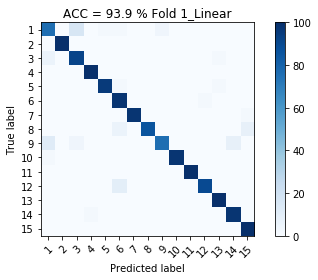

              precision    recall  f1-score   support

           1       0.79      0.76      0.78        50
           2       1.00      1.00      1.00        50
           3       0.82      0.92      0.87        50
           4       0.98      1.00      0.99        51
           5       0.98      0.96      0.97        50
           6       0.83      0.98      0.90        50
           7       1.00      0.98      0.99        51
           8       1.00      0.86      0.92        50
           9       0.95      0.76      0.84        50
          10       1.00      0.98      0.99        50
          11       1.00      1.00      1.00        51
          12       0.98      0.90      0.94        50
          13       0.96      1.00      0.98        51
          14       0.92      0.98      0.95        50
          15       0.91      1.00      0.95        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

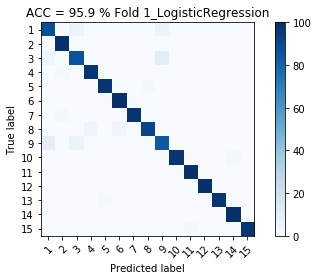

              precision    recall  f1-score   support

           1       0.86      0.88      0.87        50
           2       0.96      1.00      0.98        50
           3       0.88      0.86      0.87        50
           4       0.96      0.98      0.97        51
           5       0.98      0.98      0.98        50
           6       0.96      1.00      0.98        50
           7       1.00      0.98      0.99        51
           8       0.98      0.92      0.95        50
           9       0.84      0.84      0.84        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        51
          12       1.00      1.00      1.00        50
          13       1.00      0.98      0.99        51
          14       0.98      1.00      0.99        50
          15       1.00      0.98      0.99        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

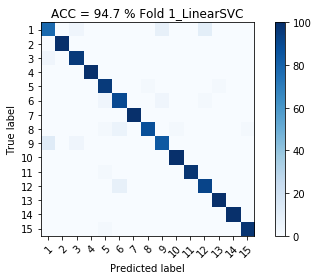

1it [28:47, 1727.79s/it]

              precision    recall  f1-score   support

           1       0.83      0.78      0.80        50
           2       1.00      1.00      1.00        50
           3       0.92      0.96      0.94        50
           4       1.00      1.00      1.00        51
           5       0.91      0.96      0.93        50
           6       0.87      0.90      0.88        50
           7       1.00      1.00      1.00        51
           8       0.98      0.88      0.93        50
           9       0.88      0.84      0.86        50
          10       0.98      1.00      0.99        50
          11       1.00      0.98      0.99        51
          12       0.88      0.92      0.90        50
          13       0.98      1.00      0.99        51
          14       1.00      1.00      1.00        50
          15       0.98      0.98      0.98        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

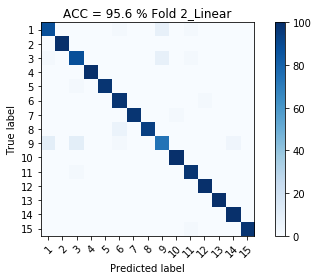

              precision    recall  f1-score   support

           1       0.88      0.88      0.88        50
           2       1.00      1.00      1.00        50
           3       0.86      0.88      0.87        50
           4       1.00      1.00      1.00        51
           5       1.00      0.98      0.99        50
           6       0.91      0.98      0.94        51
           7       1.00      0.98      0.99        50
           8       1.00      0.94      0.97        51
           9       0.82      0.74      0.78        50
          10       0.98      1.00      0.99        50
          11       0.94      0.98      0.96        50
          12       0.98      1.00      0.99        50
          13       1.00      1.00      1.00        50
          14       0.96      1.00      0.98        51
          15       1.00      0.98      0.99        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

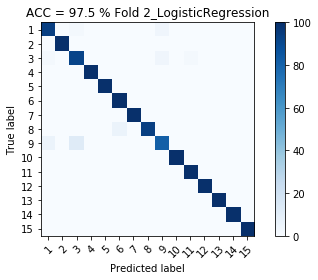

              precision    recall  f1-score   support

           1       0.92      0.94      0.93        50
           2       1.00      1.00      1.00        50
           3       0.87      0.92      0.89        50
           4       1.00      1.00      1.00        51
           5       1.00      1.00      1.00        50
           6       0.94      1.00      0.97        51
           7       1.00      1.00      1.00        50
           8       1.00      0.94      0.97        51
           9       0.91      0.82      0.86        50
          10       1.00      1.00      1.00        50
          11       0.98      1.00      0.99        50
          12       1.00      1.00      1.00        50
          13       1.00      1.00      1.00        50
          14       1.00      1.00      1.00        51
          15       1.00      1.00      1.00        50

    accuracy                           0.97       754
   macro avg       0.98      0.97      0.97       754
weighted avg       0.98   

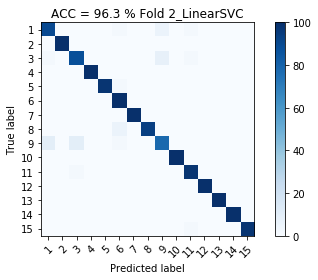

2it [58:13, 1739.15s/it]

              precision    recall  f1-score   support

           1       0.88      0.90      0.89        50
           2       1.00      1.00      1.00        50
           3       0.88      0.88      0.88        50
           4       1.00      1.00      1.00        51
           5       1.00      0.98      0.99        50
           6       0.89      1.00      0.94        51
           7       1.00      1.00      1.00        50
           8       1.00      0.94      0.97        51
           9       0.85      0.78      0.81        50
          10       1.00      1.00      1.00        50
          11       0.94      0.98      0.96        50
          12       1.00      1.00      1.00        50
          13       1.00      1.00      1.00        50
          14       1.00      1.00      1.00        51
          15       1.00      0.98      0.99        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

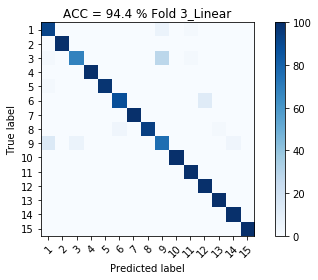

              precision    recall  f1-score   support

           1       0.84      0.92      0.88        50
           2       1.00      1.00      1.00        50
           3       0.92      0.68      0.78        50
           4       1.00      1.00      1.00        51
           5       1.00      0.98      0.99        51
           6       0.96      0.88      0.92        50
           7       1.00      1.00      1.00        51
           8       1.00      0.94      0.97        50
           9       0.69      0.76      0.72        50
          10       1.00      1.00      1.00        50
          11       0.96      1.00      0.98        50
          12       0.89      1.00      0.94        50
          13       0.98      1.00      0.99        51
          14       0.96      1.00      0.98        50
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.95      0.94      0.94       754
weighted avg       0.95   

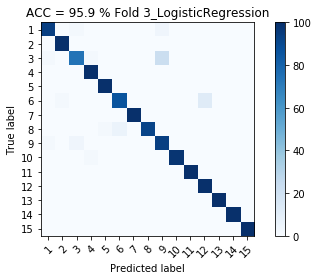

              precision    recall  f1-score   support

           1       0.96      0.94      0.95        50
           2       0.98      1.00      0.99        50
           3       0.93      0.74      0.82        50
           4       0.96      1.00      0.98        51
           5       0.98      1.00      0.99        51
           6       0.93      0.86      0.90        50
           7       1.00      1.00      1.00        51
           8       1.00      0.92      0.96        50
           9       0.78      0.94      0.85        50
          10       1.00      0.98      0.99        50
          11       1.00      1.00      1.00        50
          12       0.89      1.00      0.94        50
          13       1.00      1.00      1.00        51
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

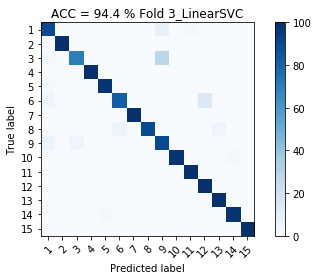

3it [1:27:36, 1746.44s/it]

              precision    recall  f1-score   support

           1       0.87      0.90      0.88        50
           2       1.00      1.00      1.00        50
           3       0.95      0.70      0.80        50
           4       1.00      1.00      1.00        51
           5       0.98      0.98      0.98        51
           6       0.93      0.82      0.87        50
           7       1.00      1.00      1.00        51
           8       1.00      0.90      0.95        50
           9       0.71      0.90      0.80        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.88      1.00      0.93        50
          13       0.96      1.00      0.98        51
          14       0.98      0.98      0.98        50
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.95      0.94      0.94       754
weighted avg       0.95   

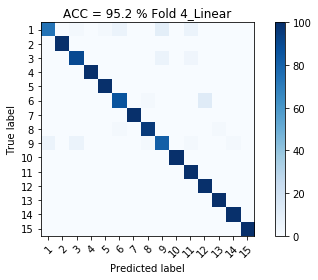

              precision    recall  f1-score   support

           1       0.93      0.74      0.82        50
           2       1.00      1.00      1.00        51
           3       0.92      0.90      0.91        51
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        50
           6       0.91      0.86      0.89        50
           7       1.00      1.00      1.00        51
           8       0.96      0.96      0.96        50
           9       0.84      0.82      0.83        50
          10       1.00      1.00      1.00        51
          11       0.89      1.00      0.94        50
          12       0.89      1.00      0.94        50
          13       0.98      1.00      0.99        50
          14       0.98      1.00      0.99        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

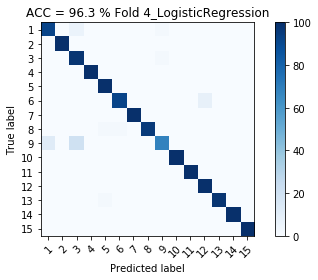

              precision    recall  f1-score   support

           1       0.88      0.92      0.90        50
           2       1.00      1.00      1.00        51
           3       0.79      0.98      0.88        51
           4       1.00      1.00      1.00        50
           5       0.96      1.00      0.98        50
           6       0.98      0.92      0.95        50
           7       1.00      1.00      1.00        51
           8       1.00      0.96      0.98        50
           9       0.94      0.68      0.79        50
          10       1.00      1.00      1.00        51
          11       1.00      1.00      1.00        50
          12       0.93      1.00      0.96        50
          13       1.00      0.98      0.99        50
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.97      0.96      0.96       754
weighted avg       0.97   

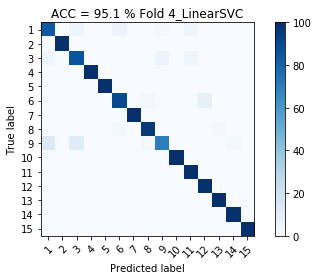

4it [1:55:54, 1731.92s/it]

              precision    recall  f1-score   support

           1       0.82      0.84      0.83        50
           2       1.00      1.00      1.00        51
           3       0.85      0.86      0.85        51
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        50
           6       0.92      0.90      0.91        50
           7       1.00      1.00      1.00        51
           8       0.96      0.96      0.96        50
           9       0.90      0.70      0.79        50
          10       1.00      1.00      1.00        51
          11       0.93      1.00      0.96        50
          12       0.93      1.00      0.96        50
          13       0.98      1.00      0.99        50
          14       0.98      1.00      0.99        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

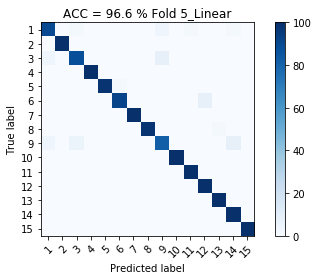

              precision    recall  f1-score   support

           1       0.92      0.90      0.91        50
           2       1.00      1.00      1.00        51
           3       0.92      0.88      0.90        50
           4       1.00      1.00      1.00        50
           5       1.00      0.98      0.99        50
           6       0.98      0.92      0.95        50
           7       1.00      1.00      1.00        51
           8       1.00      0.98      0.99        50
           9       0.87      0.82      0.85        50
          10       1.00      1.00      1.00        50
          11       0.98      1.00      0.99        50
          12       0.93      1.00      0.96        51
          13       0.98      1.00      0.99        50
          14       0.91      1.00      0.95        51
          15       1.00      1.00      1.00        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   

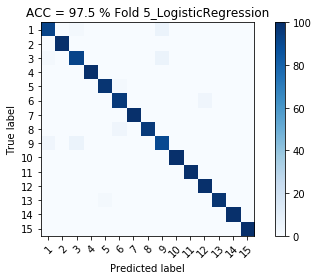

              precision    recall  f1-score   support

           1       0.94      0.92      0.93        50
           2       1.00      1.00      1.00        51
           3       0.92      0.92      0.92        50
           4       1.00      1.00      1.00        50
           5       0.98      0.98      0.98        50
           6       0.94      0.96      0.95        50
           7       1.00      1.00      1.00        51
           8       1.00      0.96      0.98        50
           9       0.88      0.90      0.89        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.96      1.00      0.98        51
          13       1.00      0.98      0.99        50
          14       1.00      1.00      1.00        51
          15       1.00      1.00      1.00        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.98   

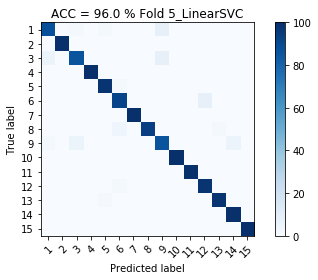

5it [2:23:53, 1715.99s/it]

              precision    recall  f1-score   support

           1       0.92      0.88      0.90        50
           2       1.00      1.00      1.00        51
           3       0.91      0.86      0.89        50
           4       1.00      1.00      1.00        50
           5       0.96      0.98      0.97        50
           6       0.92      0.92      0.92        50
           7       1.00      1.00      1.00        51
           8       1.00      0.94      0.97        50
           9       0.84      0.86      0.85        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.93      0.98      0.95        51
          13       0.98      0.98      0.98        50
          14       0.94      1.00      0.97        51
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

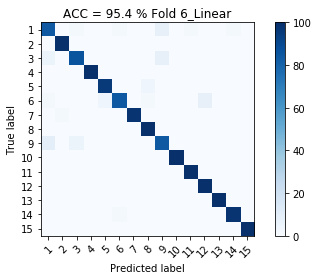

              precision    recall  f1-score   support

           1       0.83      0.84      0.83        51
           2       0.98      1.00      0.99        50
           3       0.92      0.86      0.89        51
           4       1.00      1.00      1.00        50
           5       0.96      0.96      0.96        50
           6       0.96      0.84      0.90        51
           7       1.00      0.98      0.99        50
           8       0.94      1.00      0.97        51
           9       0.84      0.84      0.84        50
          10       1.00      1.00      1.00        50
          11       0.98      1.00      0.99        50
          12       0.93      1.00      0.96        50
          13       1.00      1.00      1.00        50
          14       0.98      0.98      0.98        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

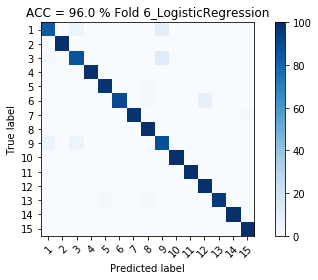

              precision    recall  f1-score   support

           1       0.91      0.84      0.88        51
           2       1.00      1.00      1.00        50
           3       0.88      0.86      0.87        51
           4       1.00      1.00      1.00        50
           5       0.98      0.98      0.98        50
           6       1.00      0.90      0.95        51
           7       1.00      0.98      0.99        50
           8       0.94      1.00      0.97        51
           9       0.80      0.88      0.84        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.93      1.00      0.96        50
          13       1.00      0.96      0.98        50
          14       1.00      1.00      1.00        50
          15       0.98      1.00      0.99        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

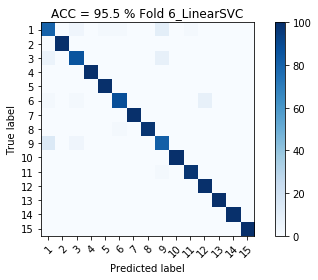

6it [2:51:32, 1698.68s/it]

              precision    recall  f1-score   support

           1       0.79      0.80      0.80        51
           2       1.00      1.00      1.00        50
           3       0.90      0.86      0.88        51
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        50
           6       0.96      0.88      0.92        51
           7       1.00      1.00      1.00        50
           8       1.00      0.98      0.99        51
           9       0.80      0.82      0.81        50
          10       1.00      1.00      1.00        50
          11       0.98      0.98      0.98        50
          12       0.93      1.00      0.96        50
          13       1.00      1.00      1.00        50
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

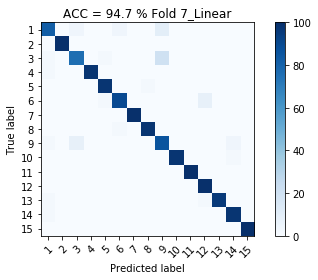

              precision    recall  f1-score   support

           1       0.89      0.82      0.86        51
           2       1.00      1.00      1.00        51
           3       0.86      0.76      0.81        50
           4       1.00      0.98      0.99        51
           5       0.96      0.98      0.97        50
           6       0.94      0.90      0.92        50
           7       1.00      1.00      1.00        51
           8       0.98      0.98      0.98        50
           9       0.74      0.86      0.80        50
          10       1.00      0.98      0.99        50
          11       1.00      1.00      1.00        50
          12       0.91      1.00      0.95        50
          13       1.00      0.96      0.98        50
          14       0.94      0.98      0.96        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

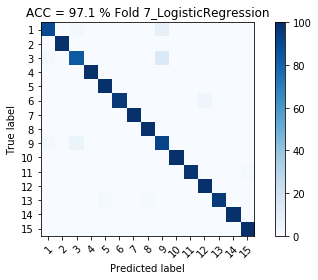

              precision    recall  f1-score   support

           1       0.96      0.90      0.93        51
           2       1.00      1.00      1.00        51
           3       0.91      0.84      0.87        50
           4       1.00      1.00      1.00        51
           5       0.98      1.00      0.99        50
           6       1.00      0.96      0.98        50
           7       1.00      1.00      1.00        51
           8       0.98      1.00      0.99        50
           9       0.81      0.92      0.86        50
          10       1.00      1.00      1.00        50
          11       1.00      0.98      0.99        50
          12       0.96      1.00      0.98        50
          13       1.00      0.96      0.98        50
          14       1.00      1.00      1.00        50
          15       0.98      1.00      0.99        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   

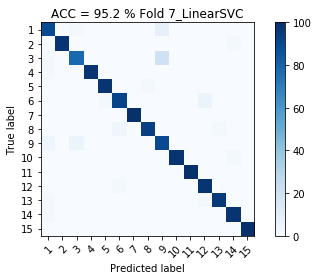

7it [3:21:27, 1727.79s/it]

              precision    recall  f1-score   support

           1       0.88      0.90      0.89        51
           2       1.00      0.98      0.99        51
           3       0.91      0.78      0.84        50
           4       1.00      0.98      0.99        51
           5       0.98      0.98      0.98        50
           6       0.94      0.92      0.93        50
           7       1.00      1.00      1.00        51
           8       0.98      0.94      0.96        50
           9       0.76      0.90      0.83        50
          10       1.00      0.98      0.99        50
          11       1.00      1.00      1.00        50
          12       0.92      0.98      0.95        50
          13       0.98      0.96      0.97        50
          14       0.96      0.98      0.97        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

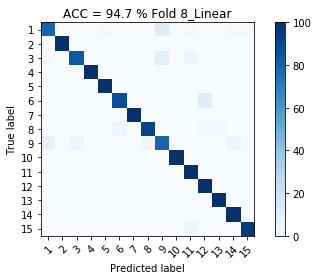

              precision    recall  f1-score   support

           1       0.89      0.80      0.84        50
           2       1.00      1.00      1.00        50
           3       0.95      0.84      0.89        50
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        50
           6       0.96      0.88      0.92        51
           7       1.00      1.00      1.00        50
           8       0.96      0.92      0.94        51
           9       0.78      0.80      0.79        50
          10       1.00      1.00      1.00        51
          11       0.91      1.00      0.95        50
          12       0.88      1.00      0.93        50
          13       0.98      1.00      0.99        51
          14       0.94      1.00      0.97        50
          15       0.98      0.96      0.97        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

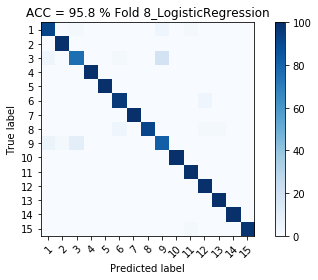

              precision    recall  f1-score   support

           1       0.90      0.92      0.91        50
           2       0.98      1.00      0.99        50
           3       0.86      0.76      0.81        50
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        50
           6       0.94      0.96      0.95        51
           7       1.00      1.00      1.00        50
           8       1.00      0.92      0.96        51
           9       0.79      0.82      0.80        50
          10       1.00      1.00      1.00        51
          11       0.96      1.00      0.98        50
          12       0.94      1.00      0.97        50
          13       0.98      1.00      0.99        51
          14       1.00      1.00      1.00        50
          15       1.00      0.98      0.99        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

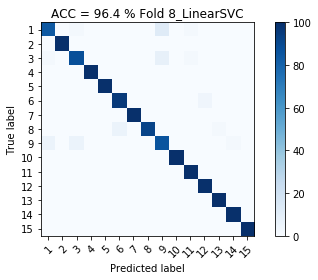

8it [3:49:22, 1711.91s/it]

              precision    recall  f1-score   support

           1       0.91      0.84      0.87        50
           2       1.00      1.00      1.00        50
           3       0.92      0.88      0.90        50
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        50
           6       0.94      0.96      0.95        51
           7       1.00      1.00      1.00        50
           8       1.00      0.92      0.96        51
           9       0.81      0.86      0.83        50
          10       1.00      1.00      1.00        51
          11       0.96      1.00      0.98        50
          12       0.96      1.00      0.98        50
          13       0.98      1.00      0.99        51
          14       0.98      1.00      0.99        50
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

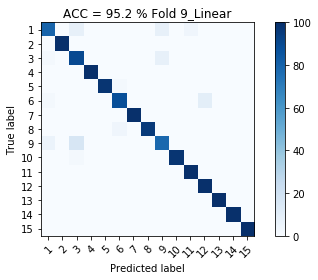

              precision    recall  f1-score   support

           1       0.89      0.80      0.84        50
           2       1.00      1.00      1.00        51
           3       0.78      0.90      0.83        50
           4       1.00      1.00      1.00        50
           5       1.00      0.98      0.99        50
           6       0.94      0.88      0.91        50
           7       1.00      1.00      1.00        50
           8       1.00      0.96      0.98        50
           9       0.83      0.78      0.81        51
          10       1.00      0.98      0.99        50
          11       0.96      1.00      0.98        50
          12       0.91      1.00      0.95        51
          13       1.00      1.00      1.00        50
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        51

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

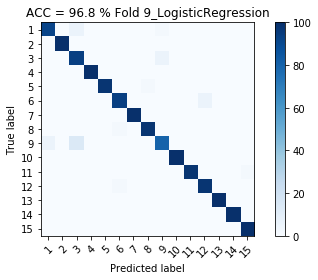

              precision    recall  f1-score   support

           1       0.94      0.92      0.93        50
           2       1.00      1.00      1.00        51
           3       0.82      0.94      0.88        50
           4       1.00      1.00      1.00        50
           5       1.00      0.98      0.99        50
           6       0.96      0.94      0.95        50
           7       1.00      1.00      1.00        50
           8       0.98      0.98      0.98        50
           9       0.91      0.80      0.85        51
          10       1.00      1.00      1.00        50
          11       1.00      0.98      0.99        50
          12       0.94      0.98      0.96        51
          13       1.00      1.00      1.00        50
          14       1.00      1.00      1.00        50
          15       0.98      1.00      0.99        51

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   

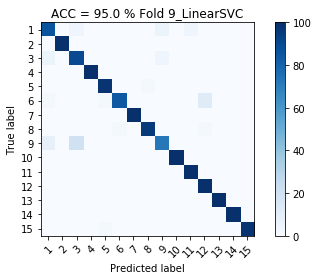

9it [4:17:07, 1697.69s/it]

              precision    recall  f1-score   support

           1       0.84      0.86      0.85        50
           2       1.00      1.00      1.00        51
           3       0.79      0.90      0.84        50
           4       1.00      1.00      1.00        50
           5       0.96      0.98      0.97        50
           6       0.98      0.84      0.90        50
           7       1.00      1.00      1.00        50
           8       0.98      0.96      0.97        50
           9       0.88      0.73      0.80        51
          10       1.00      1.00      1.00        50
          11       0.96      1.00      0.98        50
          12       0.88      1.00      0.94        51
          13       1.00      1.00      1.00        50
          14       1.00      1.00      1.00        50
          15       1.00      0.98      0.99        51

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

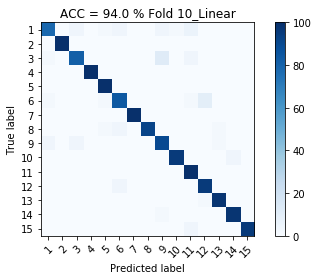

              precision    recall  f1-score   support

           1       0.91      0.78      0.84        51
           2       1.00      1.00      1.00        51
           3       0.91      0.82      0.86        50
           4       1.00      1.00      1.00        50
           5       0.94      1.00      0.97        50
           6       0.88      0.84      0.86        50
           7       1.00      1.00      1.00        50
           8       1.00      0.92      0.96        50
           9       0.83      0.90      0.87        50
          10       0.98      0.96      0.97        50
          11       0.86      1.00      0.93        51
          12       0.89      0.96      0.92        51
          13       0.96      0.98      0.97        50
          14       0.96      0.98      0.97        50
          15       1.00      0.96      0.98        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

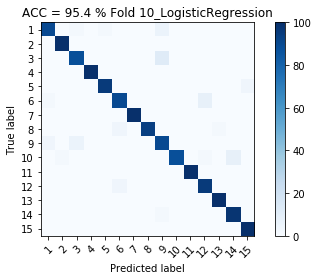

              precision    recall  f1-score   support

           1       0.94      0.90      0.92        51
           2       0.98      1.00      0.99        51
           3       0.92      0.88      0.90        50
           4       1.00      1.00      1.00        50
           5       0.98      0.96      0.97        50
           6       0.92      0.90      0.91        50
           7       1.00      1.00      1.00        50
           8       1.00      0.94      0.97        50
           9       0.82      0.90      0.86        50
          10       1.00      0.88      0.94        50
          11       1.00      1.00      1.00        51
          12       0.91      0.96      0.93        51
          13       0.98      1.00      0.99        50
          14       0.92      0.98      0.95        50
          15       0.96      1.00      0.98        50

    accuracy                           0.95       754
   macro avg       0.96      0.95      0.95       754
weighted avg       0.96   

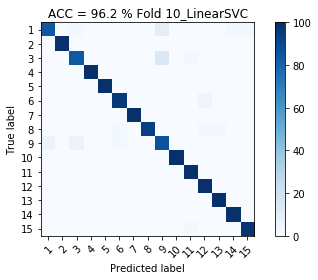

10it [4:45:26, 1712.60s/it]

              precision    recall  f1-score   support

           1       0.93      0.84      0.89        51
           2       1.00      1.00      1.00        51
           3       0.91      0.84      0.87        50
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        50
           6       0.96      0.96      0.96        50
           7       1.00      1.00      1.00        50
           8       1.00      0.94      0.97        50
           9       0.78      0.86      0.82        50
          10       1.00      1.00      1.00        50
          11       0.96      1.00      0.98        51
          12       0.94      1.00      0.97        51
          13       0.98      1.00      0.99        50
          14       0.98      1.00      0.99        50
          15       0.98      0.98      0.98        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

In [ ]:
# Traininig/Testing loop

for train_index, test_index in tqdm(sss.split(X,y)):
    # Training/testing index storage
    train_idx += [train_index]
    test_idx  += [test_index]
    
    # Number of partitions flag
    fold = fold + 1
    print("Iteration = ", str(fold) +'/'+ str(n_partitions))
    
    # Iteration file name 
    filename = "Fold" + str(fold)
    
    # Train/Test 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]


    # ---------------------------------------------------------------------------------------------------------------------------
    # Training
    
    # Linear
    print('Linear Model')
    # Using GridSearchCV 
    # hs_Lineal = GridSearchCV(Pipeline(steps[0]), parameters[0], n_jobs = 6, cv = 5, scoring = 'balanced_accuracy', verbose = 50)
    # Using RandomizedSearchCV
    hs_Lineal = RandomizedSearchCV(Pipeline(steps[0]), param_distributions=parameters[0],n_iter=10, cv=5, iid=False, n_jobs=20)
    hs_Lineal.fit(X_train,y_train)
    nfeats_L     += [hs_Lineal.best_estimator_.named_steps['FeatureSelectnRel'].n_features_to_select]
    sel_fts_L    += [hs_Lineal.best_estimator_.named_steps['FeatureSelectnRel'].top_features_]
    scores_rlff_L+= [hs_Lineal.best_estimator_.named_steps['FeatureSelectnRel'].feature_importances_]


    # Logistic Regression
    print('Logistic Regression Model')
    # Usaing GridSearchCV 
    # hs_LogR = GridSearchCV(Pipeline(steps[1]), parameters[1], n_jobs = 6, cv = 5, scoring = 'balanced_accuracy', verbose = 50)
    # Using RandomizedSearchCV
    hs_LogR = RandomizedSearchCV(Pipeline(steps[1]), param_distributions=parameters[1],n_iter=10, cv=5, iid=False,n_jobs=20)
    hs_LogR.fit(X_train,y_train)
    # Features selected by ReliefF method
    nfeats_LogR     += [hs_LogR.best_estimator_.named_steps['FeatureSelectnRel'].n_features_to_select]
    sel_fts_LogR    += [hs_LogR.best_estimator_.named_steps['FeatureSelectnRel'].top_features_]
    scores_rlff_LogR+= [hs_LogR.best_estimator_.named_steps['FeatureSelectnRel'].feature_importances_]
  

    # Linear SVM
    print('Linear SVM Model')
    # Using GridSearchCV 
    #hs_lSVM = GridSearchCV(Pipeline(steps[2]), parameters[2], n_jobs = 6, cv = 5, scoring = 'balanced_accuracy', verbose = 50)
    # Using RandomizedSearchCV
    hs_lSVM = RandomizedSearchCV(Pipeline(steps[2]), param_distributions=parameters[2],n_iter=10, cv=5, iid=False, n_jobs=20)  
    hs_lSVM.fit(X_train,y_train)
    # Features selected by ReliefF method
    nfeats_lSVM     += [hs_lSVM.best_estimator_.named_steps['FeatureSelectnRel'].n_features_to_select]
    sel_fts_lSVM    += [hs_lSVM.best_estimator_.named_steps['FeatureSelectnRel'].top_features_]
    scores_rlff_lSVM+= [hs_lSVM.best_estimator_.named_steps['FeatureSelectnRel'].feature_importances_]

    # ---------------------------------------------------------------------------------------------------------------------------
    # Validation
    
    # Linear
    y_pred_L           = hs_Lineal.best_estimator_.predict(X_test)
    accuracy_L[fold-1] = accuracy_score(y_test,y_pred_L)
    cm_temp            = confusion_matrix(y_test,y_pred_L)
    cm_L[fold-1,:,:]   = 100*cm_temp.astype('float') / cm_temp.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(y_test, y_pred_L, classes=np.unique(y),normalize=True,title='ACC = %.1f %% Fold %d' % (100*accuracy_L[fold-1],fold) + '_'+ label_models[0])
    plt.autoscale()
    save_fig(img_path,label_models[0]+'_Fold'+str(fold))                      
    plt.show()
    cr_L += [classification_report(y_test,y_pred_L)]
    print(cr_L[-1])
    # Best model storage
    # best_mod_L += [hs_Lineal.best_estimator_, accuracy_L,cm_L,cr_L, sel_fts_L]
    # best_mod_L += [hs_Lineal.best_estimator_]
    best_pms_L += [hs_Lineal.best_params_]


    # Logistic Regression
    y_pred_LogR          = hs_LogR.best_estimator_.predict(X_test)
    accuracy_LogR[fold-1]= accuracy_score(y_test,y_pred_LogR)
    cm_temp              = confusion_matrix(y_test,y_pred_LogR)
    cm_LogR[fold-1,:,:]  = 100*cm_temp.astype('float') / cm_temp.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(y_test, y_pred_LogR, classes=np.unique(y),normalize=True,title='ACC = %.1f %% Fold %d' % (100*accuracy_LogR[fold-1],fold) + '_'+ label_models[1])
    plt.autoscale()
    save_fig(img_path,label_models[1]+'_Fold'+str(fold))                      
    plt.show()
    cr_LogR += [classification_report(y_test,y_pred_LogR)]
    print(cr_LogR[-1])
    # Best model storage
    # best_mod_LogR += [hs_LogR.best_estimator_, accuracy_LogR,cm_LogR,cr_LogR, sel_fts_LogR]
    # best_mod_LogR += [hs_LogR.best_estimator_]
    best_pms_LogR += [hs_LogR.best_params_]

    # Linear SVM
    y_pred_lSVM          = hs_lSVM.best_estimator_.predict(X_test)
    accuracy_lSVM[fold-1]= accuracy_score(y_test,y_pred_lSVM)
    cm_temp              = confusion_matrix(y_test,y_pred_lSVM)
    cm_LogR[fold-1,:,:]  = 100*cm_temp.astype('float') / cm_temp.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(y_test, y_pred_lSVM, classes=np.unique(y),normalize=True,title='ACC = %.1f %% Fold %d' % (100*accuracy_lSVM[fold-1],fold) + '_'+ label_models[2])
    plt.autoscale()
    save_fig(img_path,label_models[2]+'_Fold'+str(fold))                      
    plt.show()
    cr_lSVM += [classification_report(y_test,y_pred_lSVM)]
    print(cr_lSVM[-1])
    # Best model storage
    # best_mod_lSVM += [hs_lSVM.best_estimator_, accuracy_lSVM,cm_lSVM,cr_lSVM, sel_fts_lSVM]
    # best_mod_lSVM += [hs_lSVM.best_estimator_]
    best_pms_lSVM += [hs_lSVM.best_params_]

    # Results dictionary creation
    L_dict = {'accuracy_L': accuracy_L,
              'best_pms_L': best_pms_L,
              'cm_L': cm_L,
              'cr_L': cr_L,
              'sel_fts_L':sel_fts_L,
              'scores_rlff_L':scores_rlff_L,
              'nfeats_L': nfeats_L}

    LogR_dict = {'accuracy_LogR': accuracy_LogR,
                 'best_pms_LogR': best_pms_LogR,
                'cm_LogR': cm_LogR,
                'cr_LogR': cr_LogR,
                'sel_fts_LogR':sel_fts_LogR,
                'scores_rlff_LogR':scores_rlff_LogR,
                'nfeats_LogR': nfeats_LogR}

    lSVM_dict = {'accuracy_lSVM': accuracy_lSVM,
                 'best_pms_lSVM': best_pms_lSVM,
                'cm_lSVM': cm_lSVM,
                'cr_lSVM': cr_lSVM,
                'sel_fts_lSVM':sel_fts_lSVM,
                'scores_rlff_lSVM':scores_rlff_lSVM,
                'nfeats_lSVM': nfeats_lSVM}

    Results = [L_dict, LogR_dict, lSVM_dict]

    joblib.dump(Results, rslt_dir + "Fold" + str(fold) + ".pkl")

The number of features is reported according to the best feature selection result

In [ ]:
n_folds     = 10
hist_ftr_vec= np.zeros((len(Results),len(list(Results[0].values())[4][0])))
mean_ftr_vec= np.zeros((10,1))

# Loop to run over results lists:
for i in range(0,len(Results)):
    # Matrix creation to count feature appearances
    temp_matrix = np.zeros((n_folds,len(list(Results[i].values())[4][0])))
    # Loop to iterate over dictionary entries:
    for l in Results[i]:
        # Loop to run over list of selected features:
        for j in range(0,n_folds):
            if l == 'sel_fts_L' or l == 'sel_fts_LogR' or l == 'sel_fts_lSVM':
                temp_vec    = Results[i][l][j][0:list(Results[i].values())[6][j]]
                temp_matrix[j][temp_vec] = 1
    # Vector of feature appearances
    hist_ftr_vec[i][:] = np.sum(temp_matrix,axis = 0)
    mean_ftr_vec[i]    = np.mean(Results[i][l])
    
# Printing results:
print('Linear Classifier')
print(str(np.mean(np.array(Results[0]['accuracy_L']))*100) + '+/-' + str(np.std(np.array(Results[0]['accuracy_L']))*100))
print('Number of features = ' + str(mean_ftr_vec[0]))

print('Logistic Regression Classifier')
print(str(np.mean(np.array(Results[1]['accuracy_LogR']))*100) + '+/-' + str(np.std(np.array(Results[1]['accuracy_LogR']))*100))
print('Number of features = ' + str(mean_ftr_vec[1]))

print('Linear SVM Classifier')
print(str(np.mean(np.array(Results[2]['accuracy_lSVM']))*100) + '+/-' + str(np.std(np.array(Results[2]['accuracy_lSVM']))*100))
print('Number of features = ' + str(mean_ftr_vec[2]))

Linear Classifier
94.97347480106102+/-0.7536378061101007
Number of features = [9675.]
Logistic Regression Classifier
96.40583554376659+/-0.7177750200389839
Number of features = [9225.]
Linear SVM Classifier
95.47745358090187+/-0.6695971120087175
Number of features = [9375.]


In [ ]:
from scipy.spatial.distance import cdist
# Ideal Result
Target       = np.array((100,0,0))
# Computing the minimum distance between the ideal result and our results
dist         = cdist(Target.reshape(1,-1),np.array(([np.mean(np.array(Results[0]['accuracy_L']))*100,np.std(np.array(Results[0]['accuracy_L']))*100,9675/31500],[np.mean(np.array(Results[1]['accuracy_LogR']))*100,np.std(np.array(Results[1]['accuracy_LogR']))*100,9225/31500],[np.mean(np.array(Results[2]['accuracy_lSVM']))*100,np.std(np.array(Results[2]['accuracy_lSVM']))*100,9375/31500])), 'euclidean')
print(dist)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

Region-based histogram building

In [ ]:
n_regions    = 21
G            = 1500           # Number of cetroid from BoCF dictionary learning
expected_feat= G*n_partitions # Expected number of features per region and fold
size         = len(list(Results[0].values())[4][0])
features     = np.arange(1,size+1,1)
region_vec   = np.arange(0,n_regions+1)*G
hist_region  = np.zeros((n_regions,10))
hist_region_s= np.zeros((n_regions,10))
region_vec_p = np.arange(1,n_regions+1)
hist_ftr_mat = np.concatenate((hist_ftr_vec,features.reshape(size,1).T),axis = 0).T
# Histogram with prunning
idx                 = hist_ftr_vec >= 6 
hist_ftr_vec_sampled= np.where(idx,hist_ftr_vec,hist_ftr_vec*0)
hist_ftr_mat_sampled= np.concatenate((hist_ftr_vec_sampled,features.reshape(size,1).T),axis = 0).T
# Now, histograms per region are obtained
for i in range(0,len(region_vec)-1):
  for j in range(0,hist_ftr_mat.shape[1]-1):          
      hist_region[i,j]  = np.sum(hist_ftr_mat[region_vec[i]:region_vec[i+1],j])/expected_feat
      hist_region_s[i,j]= np.sum(hist_ftr_mat_sampled[region_vec[i]:region_vec[i+1],j])/expected_feat

In [ ]:
# Storing data to plot histograms in Latex
    
# According to the values, are extracted the non-zero values
idx_nz     = np.argsort(-1*hist_ftr_vec[2,:])
hist_vec_nz= hist_ftr_vec[2,idx_nz]
# features_nz= features[idx_nz]
hist_mat_nz= np.concatenate((hist_vec_nz.reshape(features.shape[0],1).T,features.reshape(features.shape[0],1).T),axis = 0).T
np.savetxt(img_path + '/HistMatrix.dat', hist_mat_nz)

# For sampled histogram
idx_nz_s     = np.argsort(-1*hist_ftr_vec_sampled[2,:])
hist_vec_nz_s= hist_ftr_vec_sampled[2,idx_nz_s]
# features_nz_s= features[idx_nz_s]
hist_mat_nz_s= np.concatenate((hist_vec_nz_s.reshape(features.shape[0],1).T,features.reshape(features.shape[0],1).T),axis = 0).T
np.savetxt(img_path + '/HistMatrixSampled.dat', hist_mat_nz_s) 

Text(0.5, 0, 'Regions')

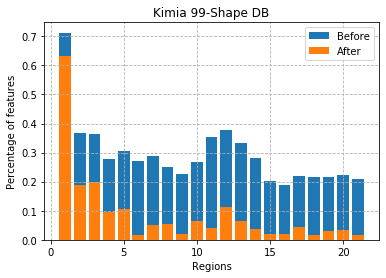

In [ ]:
# Plotting the histograms before and after apperance criteria is applied
plt.figure()
plt.title('Kimia 99-Shape DB')
plt.bar(region_vec_p,hist_region[:,1], label = 'Before')
plt.bar(region_vec_p,hist_region_s[:,1], label = 'After')
plt.legend()
plt.grid(linestyle='--')
plt.ylabel('Percentage of features')
plt.xlabel('Regions')

Feature selection indexing over the input matrix

In [ ]:
# Input matrix indexing
Xr = X.values
# Reduced matrix from feature selection indices
Xr = Xr[:,idx[1,:]]
Results = [hist_ftr_vec,hist_ftr_vec_sampled,Xr]
joblib.dump(Results, img_path + "ReductionSetResults"+ ".pkl")

['/home/jsblandon/Machine Learning/ML Codes/MLPython/Databases/CorrectedDBs/SL_DB_Corrected//FeatureSelection/SLDB_BoCF_E_ResultsReductionSetResults.pkl']

In [ ]:
# from zipfile import ZipFile

# # Crear el objeto ZipFile
# with ZipFile('SLDB_BoCF_E_Results.zip', 'w') as zipObj:
#    # Se recorren todos los archivos del directorio
#    for folderName, subfolders, filenames in os.walk(current_dir):
#        for filename in filenames: 
#            # Se crea la ruta del archivo completo en el directorio
#            filePath = os.path.join(folderName, filename)
#            print(filePath)
#            Se añaden archivos al zip 
#            zipObj.write(filePath)

# **Step 4: Centered Kernel Alignment projection**

Model description

In [ ]:
# Matrix declaration to store train/test matrices and their labels, and projection matrices from CKA
X_train_cka = []
X_test_cka  = []
y_train_cka = []
y_test_cka  = []
W_cka_L     = []
W_cka_LogR  = []
W_cka_lSVM  = []
    
# Step declaration
steps = [
        [('Preprocessing', StandardScaler()),
          ('Projection', MiniBatchCKA(Q = 0.95,batch = 70)),
          ('Preprocessing2',StandardScaler()),
          ('Classification',SGDClassifier())],      # Clasificador Lineal
        [('Preprocessing', StandardScaler()),
          ('Projection', MiniBatchCKA(Q = 0.95,batch = 70)),
          ('Preprocessing2',StandardScaler()),
          ('Classification',LogisticRegression())], # Regresion Logistica
        [('Preprocessing', StandardScaler()),
          ('Projection', MiniBatchCKA(Q = 0.95,batch = 70)),
          ('Preprocessing2',StandardScaler()),
          ('Classification',LinearSVC())],          # Maquina de Vectores de Soporte
        ]
    
# Grid declaration
parameters = [
            {'Classification__penalty': ['l1', 'l2', 'elasticnet'] },
            {'Classification__C': [0.01,0.1,1,10]},
            {'Classification__C': [0.1,1,10,100,1000]}
            ]

# Model labels
label_models = ['LinearCKA','LogisticRegressionCKA','LinearSVCKA']

In [ ]:
# Directory to save results and plots

rslt_dir     = img_dir + '/NLDR/SL_DB_CKA_Results/Results_ReliefF_CKA_RS_BoCF_Py'
sys.path.append(rslt_dir)
img_path     = img_dir + '/NLDR/SL_DB_CKA_Results/'
sys.path.append(img_path)

In [ ]:
# # Directory to save results and plots

# # rslt_dir     = '/content/drive/My Drive/Machine Learning/ML Codes/MLPython/Databases/CorrectedDBs/Animals_DB_Corrected/RegionSelection/ReliefF_CKA_RS_BoCF/Results_ReliefF_CKA_RS_BoCF_Py'
# # img_path     = '/content/drive/My Drive/Machine Learning/ML Codes/MLPython/Databases/CorrectedDBs/Animals_DB_Corrected/RegionSelection/ReliefF_CKA_RS_BoCF/'

# # # rslt_dir     = '/content/drive/My Drive/Machine Learning/ML Codes/MLPython/Databases/CorrectedDBs/Kimia99Shape_DB_Corrected/RegionSelection/ReliefF_RS_BoCF/Results_ReliefF_CKA_RS_BoCF'
# # # img_path     = '/content/drive/My Drive/Machine Learning/ML Codes/MLPython/Databases/CorrectedDBs/Kimia99Shape_DB_Corrected/RegionSelection/ReliefF_RS_BoCF/'

# rslt_dir     = '/content/drive/My Drive/Machine Learning/ML Codes/MLPython/Databases/CorrectedDBs/MPEG7_DB_Corrected/RegionSelection/ReliefF_CKA_RS_BoCF/Results_ReliefF_CKA_RS_BoCF_Py'
# img_path     = '/content/drive/My Drive/Machine Learning/ML Codes/MLPython/Databases/CorrectedDBs/MPEG7_DB_Corrected/RegionSelection/ReliefF_CKA_RS_BoCF/'

Loop to optimize CKA projection

0it [00:00, ?it/s]

Iteration =  1/10
Linear Model
it:1/50---cost:-2.11e+00--- elapsed:0.84 [s]



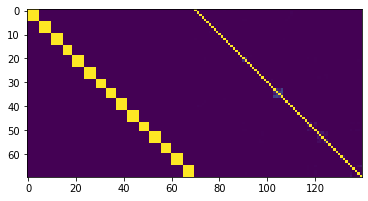

Logistic Regression Model
it:1/50---cost:-2.13e+00--- elapsed:0.82 [s]



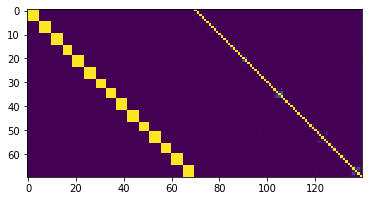

Linear SVM Model
it:1/50---cost:-2.11e+00--- elapsed:0.76 [s]



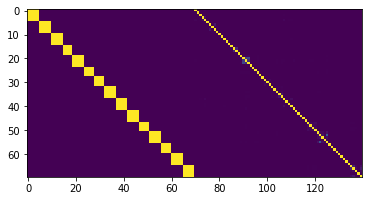

Guardando... LinearCKA_Fold1


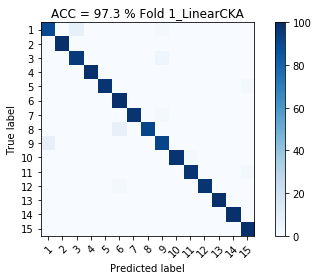

              precision    recall  f1-score   support

           1       0.92      0.90      0.91        50
           2       1.00      1.00      1.00        50
           3       0.92      0.96      0.94        50
           4       1.00      1.00      1.00        51
           5       1.00      0.98      0.99        50
           6       0.91      1.00      0.95        50
           7       1.00      0.98      0.99        51
           8       1.00      0.92      0.96        50
           9       0.92      0.92      0.92        50
          10       1.00      0.98      0.99        50
          11       0.98      0.98      0.98        51
          12       1.00      0.98      0.99        50
          13       1.00      1.00      1.00        51
          14       1.00      1.00      1.00        50
          15       0.96      1.00      0.98        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   

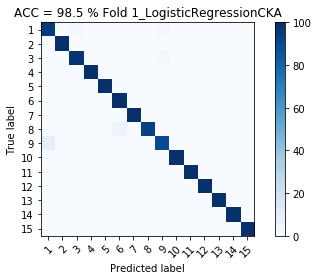

              precision    recall  f1-score   support

           1       0.91      0.96      0.93        50
           2       1.00      1.00      1.00        50
           3       0.98      0.98      0.98        50
           4       1.00      1.00      1.00        51
           5       1.00      1.00      1.00        50
           6       0.94      1.00      0.97        50
           7       1.00      1.00      1.00        51
           8       1.00      0.94      0.97        50
           9       0.96      0.90      0.93        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        51
          12       1.00      1.00      1.00        50
          13       1.00      1.00      1.00        51
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.99       754
   macro avg       0.99      0.99      0.99       754
weighted avg       0.99   

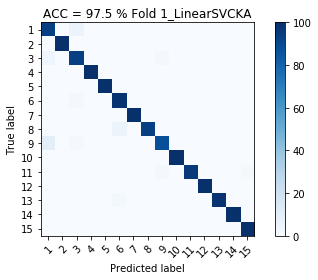

1it [00:20, 20.53s/it]

              precision    recall  f1-score   support

           1       0.87      0.94      0.90        50
           2       1.00      1.00      1.00        50
           3       0.90      0.94      0.92        50
           4       1.00      1.00      1.00        51
           5       1.00      1.00      1.00        50
           6       0.92      0.98      0.95        50
           7       1.00      1.00      1.00        51
           8       1.00      0.94      0.97        50
           9       0.96      0.88      0.92        50
          10       1.00      1.00      1.00        50
          11       1.00      0.96      0.98        51
          12       1.00      1.00      1.00        50
          13       1.00      0.98      0.99        51
          14       1.00      1.00      1.00        50
          15       0.98      1.00      0.99        50

    accuracy                           0.97       754
   macro avg       0.98      0.97      0.97       754
weighted avg       0.98   

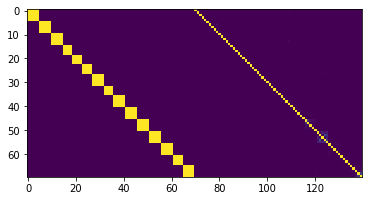

Logistic Regression Model
it:1/50---cost:-2.13e+00--- elapsed:0.75 [s]



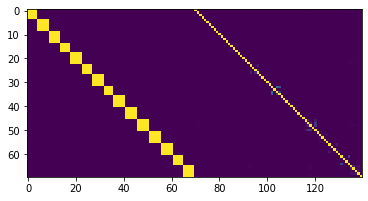

Linear SVM Model
it:1/50---cost:-2.10e+00--- elapsed:0.84 [s]



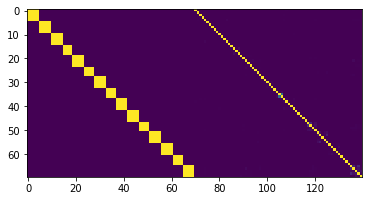

Guardando... LinearCKA_Fold2


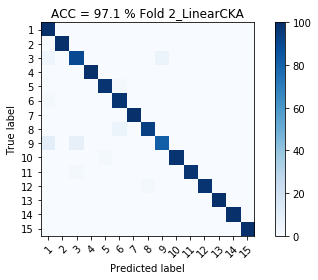

              precision    recall  f1-score   support

           1       0.86      1.00      0.93        50
           2       1.00      1.00      1.00        50
           3       0.90      0.90      0.90        50
           4       1.00      1.00      1.00        51
           5       0.98      0.98      0.98        50
           6       0.93      0.98      0.95        51
           7       1.00      1.00      1.00        50
           8       0.98      0.94      0.96        51
           9       0.93      0.82      0.87        50
          10       1.00      0.98      0.99        50
          11       1.00      0.98      0.99        50
          12       1.00      0.98      0.99        50
          13       1.00      1.00      1.00        50
          14       1.00      1.00      1.00        51
          15       1.00      1.00      1.00        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   

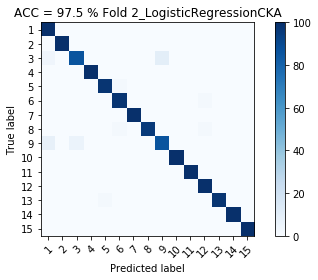

              precision    recall  f1-score   support

           1       0.89      1.00      0.94        50
           2       1.00      1.00      1.00        50
           3       0.93      0.86      0.90        50
           4       1.00      1.00      1.00        51
           5       0.98      0.98      0.98        50
           6       0.96      0.98      0.97        51
           7       1.00      1.00      1.00        50
           8       1.00      0.96      0.98        51
           9       0.90      0.86      0.88        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.96      1.00      0.98        50
          13       1.00      0.98      0.99        50
          14       1.00      1.00      1.00        51
          15       1.00      1.00      1.00        50

    accuracy                           0.97       754
   macro avg       0.98      0.97      0.97       754
weighted avg       0.98   

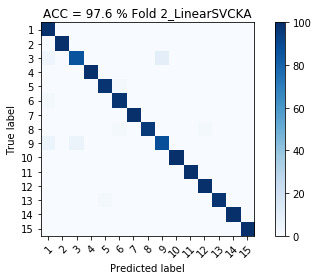

2it [00:39, 19.93s/it]

              precision    recall  f1-score   support

           1       0.89      1.00      0.94        50
           2       1.00      1.00      1.00        50
           3       0.93      0.86      0.90        50
           4       1.00      1.00      1.00        51
           5       0.98      0.98      0.98        50
           6       0.96      0.98      0.97        51
           7       1.00      1.00      1.00        50
           8       1.00      0.96      0.98        51
           9       0.90      0.88      0.89        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.98      1.00      0.99        50
          13       1.00      0.98      0.99        50
          14       1.00      1.00      1.00        51
          15       1.00      1.00      1.00        50

    accuracy                           0.98       754
   macro avg       0.98      0.98      0.98       754
weighted avg       0.98   

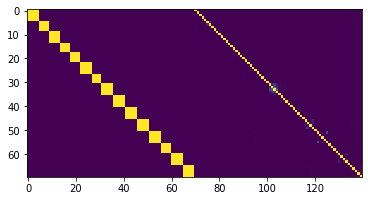

Logistic Regression Model
it:1/50---cost:-2.12e+00--- elapsed:0.77 [s]



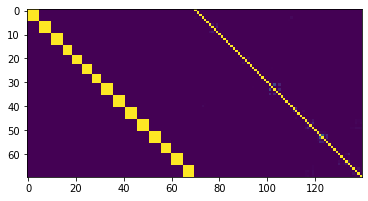

Linear SVM Model
it:1/50---cost:-2.11e+00--- elapsed:0.73 [s]



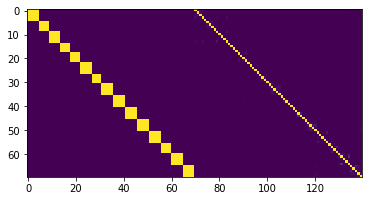

Guardando... LinearCKA_Fold3


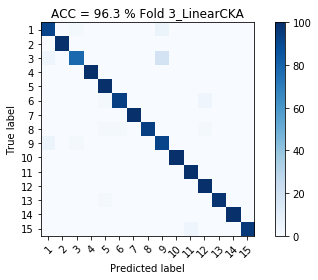

              precision    recall  f1-score   support

           1       0.90      0.92      0.91        50
           2       1.00      1.00      1.00        50
           3       0.95      0.78      0.86        50
           4       1.00      1.00      1.00        51
           5       0.94      1.00      0.97        51
           6       0.98      0.94      0.96        50
           7       1.00      1.00      1.00        51
           8       1.00      0.94      0.97        50
           9       0.79      0.92      0.85        50
          10       1.00      1.00      1.00        50
          11       0.96      1.00      0.98        50
          12       0.94      1.00      0.97        50
          13       1.00      0.98      0.99        51
          14       1.00      1.00      1.00        50
          15       1.00      0.96      0.98        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.97   

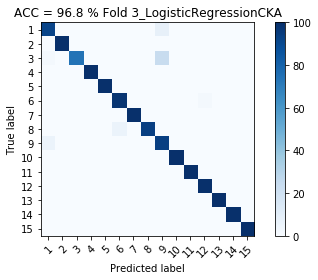

              precision    recall  f1-score   support

           1       0.92      0.92      0.92        50
           2       1.00      1.00      1.00        50
           3       1.00      0.74      0.85        50
           4       1.00      1.00      1.00        51
           5       1.00      1.00      1.00        51
           6       0.94      0.98      0.96        50
           7       1.00      1.00      1.00        51
           8       1.00      0.94      0.97        50
           9       0.75      0.94      0.83        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.98      1.00      0.99        50
          13       1.00      1.00      1.00        51
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   

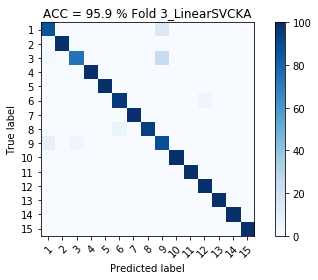

3it [00:58, 19.72s/it]

              precision    recall  f1-score   support

           1       0.90      0.86      0.88        50
           2       1.00      1.00      1.00        50
           3       0.95      0.74      0.83        50
           4       1.00      1.00      1.00        51
           5       1.00      1.00      1.00        51
           6       0.94      0.96      0.95        50
           7       1.00      1.00      1.00        51
           8       1.00      0.94      0.97        50
           9       0.70      0.88      0.78        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.96      1.00      0.98        50
          13       1.00      1.00      1.00        51
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

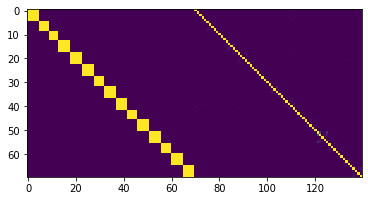

Logistic Regression Model
it:1/50---cost:-2.10e+00--- elapsed:0.77 [s]



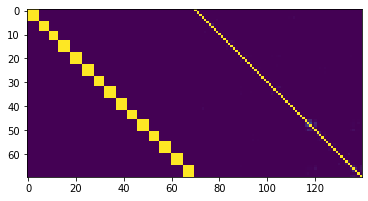

Linear SVM Model
it:1/50---cost:-2.11e+00--- elapsed:0.80 [s]



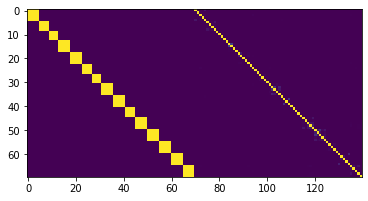

Guardando... LinearCKA_Fold4


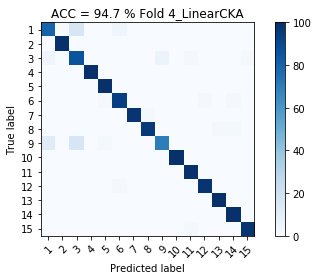

              precision    recall  f1-score   support

           1       0.83      0.80      0.82        50
           2       1.00      1.00      1.00        51
           3       0.73      0.86      0.79        51
           4       1.00      1.00      1.00        50
           5       0.96      1.00      0.98        50
           6       0.94      0.94      0.94        50
           7       1.00      0.98      0.99        51
           8       0.98      0.96      0.97        50
           9       0.92      0.70      0.80        50
          10       1.00      1.00      1.00        51
          11       0.96      1.00      0.98        50
          12       0.98      0.98      0.98        50
          13       0.98      1.00      0.99        50
          14       0.96      1.00      0.98        50
          15       0.98      0.98      0.98        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

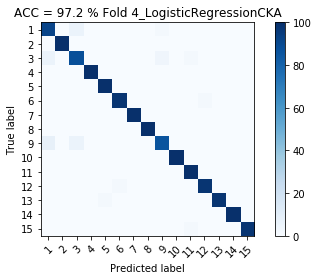

              precision    recall  f1-score   support

           1       0.87      0.92      0.89        50
           2       1.00      1.00      1.00        51
           3       0.88      0.88      0.88        51
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        50
           6       0.98      0.98      0.98        50
           7       1.00      1.00      1.00        51
           8       1.00      1.00      1.00        50
           9       0.93      0.86      0.90        50
          10       1.00      1.00      1.00        51
          11       0.96      1.00      0.98        50
          12       0.98      0.98      0.98        50
          13       1.00      0.98      0.99        50
          14       1.00      1.00      1.00        50
          15       1.00      0.98      0.99        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   

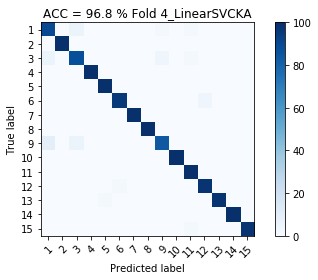

4it [01:15, 18.88s/it]

              precision    recall  f1-score   support

           1       0.85      0.90      0.87        50
           2       1.00      1.00      1.00        51
           3       0.88      0.88      0.88        51
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        50
           6       0.98      0.96      0.97        50
           7       1.00      1.00      1.00        51
           8       1.00      1.00      1.00        50
           9       0.93      0.84      0.88        50
          10       1.00      1.00      1.00        51
          11       0.94      1.00      0.97        50
          12       0.96      0.98      0.97        50
          13       1.00      0.98      0.99        50
          14       1.00      1.00      1.00        50
          15       1.00      0.98      0.99        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   

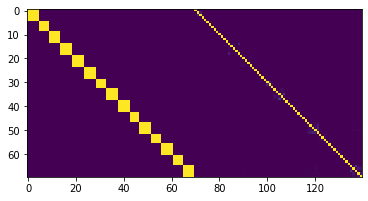

Logistic Regression Model
it:1/50---cost:-2.13e+00--- elapsed:0.79 [s]



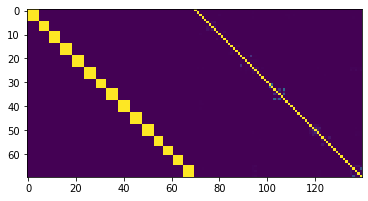

Linear SVM Model
it:1/50---cost:-2.10e+00--- elapsed:0.77 [s]



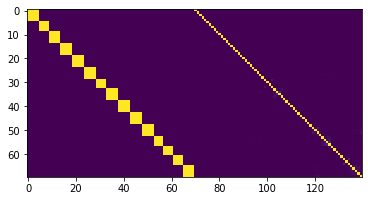

Guardando... LinearCKA_Fold5


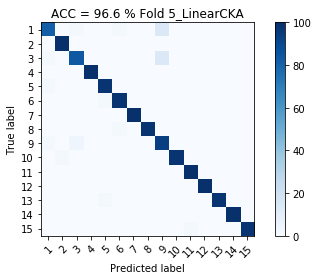

              precision    recall  f1-score   support

           1       0.93      0.82      0.87        50
           2       0.98      1.00      0.99        51
           3       0.93      0.84      0.88        50
           4       1.00      1.00      1.00        50
           5       0.96      0.98      0.97        50
           6       0.96      0.98      0.97        50
           7       1.00      1.00      1.00        51
           8       1.00      0.98      0.99        50
           9       0.77      0.94      0.85        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       1.00      1.00      1.00        51
          13       1.00      0.98      0.99        50
          14       1.00      1.00      1.00        51
          15       1.00      0.98      0.99        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   

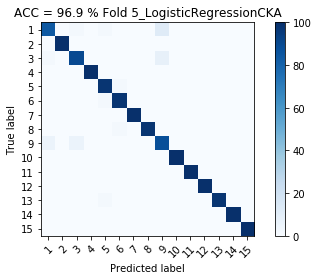

              precision    recall  f1-score   support

           1       0.91      0.84      0.87        50
           2       1.00      1.00      1.00        51
           3       0.92      0.90      0.91        50
           4       1.00      1.00      1.00        50
           5       0.94      0.98      0.96        50
           6       0.96      0.98      0.97        50
           7       1.00      1.00      1.00        51
           8       1.00      0.98      0.99        50
           9       0.81      0.88      0.85        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       1.00      1.00      1.00        51
          13       1.00      0.98      0.99        50
          14       1.00      1.00      1.00        51
          15       1.00      1.00      1.00        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   

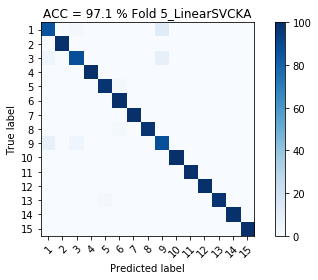

              precision    recall  f1-score   support

           1       0.88      0.86      0.87        50
           2       1.00      1.00      1.00        51
           3       0.94      0.88      0.91        50
           4       1.00      1.00      1.00        50
           5       0.98      0.98      0.98        50
           6       0.96      1.00      0.98        50
           7       1.00      1.00      1.00        51
           8       1.00      0.98      0.99        50
           9       0.81      0.88      0.85        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       1.00      1.00      1.00        51
          13       1.00      0.98      0.99        50
          14       1.00      1.00      1.00        51
          15       1.00      1.00      1.00        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   

5it [01:32, 18.37s/it]

Iteration =  6/10
Linear Model
it:1/50---cost:-2.11e+00--- elapsed:0.81 [s]



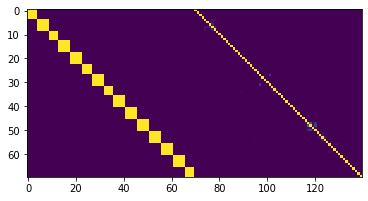

Logistic Regression Model
it:1/50---cost:-2.10e+00--- elapsed:0.80 [s]



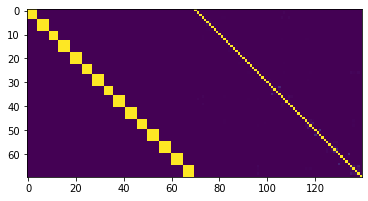

Linear SVM Model
it:1/50---cost:-2.11e+00--- elapsed:0.77 [s]



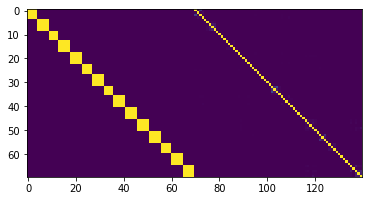

Guardando... LinearCKA_Fold6


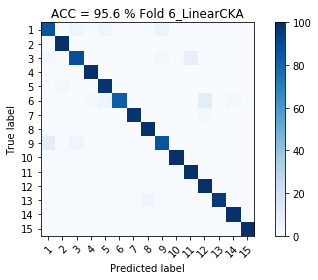

              precision    recall  f1-score   support

           1       0.88      0.86      0.87        51
           2       0.98      1.00      0.99        50
           3       0.92      0.88      0.90        51
           4       0.98      1.00      0.99        50
           5       0.92      0.98      0.95        50
           6       1.00      0.82      0.90        51
           7       1.00      0.98      0.99        50
           8       0.96      1.00      0.98        51
           9       0.91      0.86      0.89        50
          10       1.00      1.00      1.00        50
          11       0.93      1.00      0.96        50
          12       0.89      1.00      0.94        50
          13       1.00      0.96      0.98        50
          14       0.98      1.00      0.99        50
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

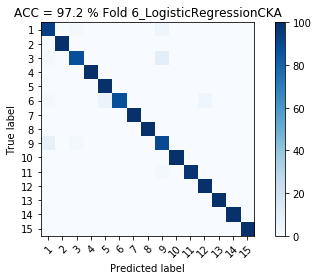

              precision    recall  f1-score   support

           1       0.89      0.94      0.91        51
           2       1.00      1.00      1.00        50
           3       0.96      0.88      0.92        51
           4       1.00      1.00      1.00        50
           5       0.94      1.00      0.97        50
           6       1.00      0.88      0.94        51
           7       1.00      1.00      1.00        50
           8       1.00      1.00      1.00        51
           9       0.85      0.90      0.87        50
          10       1.00      1.00      1.00        50
          11       1.00      0.98      0.99        50
          12       0.96      1.00      0.98        50
          13       1.00      1.00      1.00        50
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   

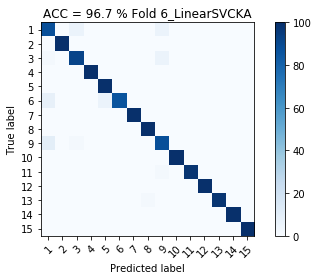

              precision    recall  f1-score   support

           1       0.82      0.88      0.85        51
           2       1.00      1.00      1.00        50
           3       0.92      0.92      0.92        51
           4       1.00      1.00      1.00        50
           5       0.94      1.00      0.97        50
           6       1.00      0.86      0.93        51
           7       1.00      1.00      1.00        50
           8       0.98      1.00      0.99        51
           9       0.86      0.88      0.87        50
          10       1.00      1.00      1.00        50
          11       1.00      0.98      0.99        50
          12       1.00      1.00      1.00        50
          13       1.00      0.98      0.99        50
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   

6it [01:50, 18.33s/it]

Iteration =  7/10
Linear Model
it:1/50---cost:-2.12e+00--- elapsed:0.75 [s]



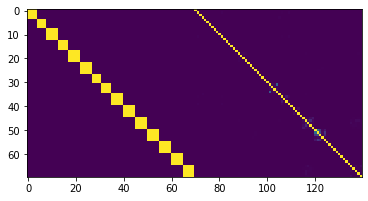

Logistic Regression Model
it:1/50---cost:-2.13e+00--- elapsed:0.78 [s]



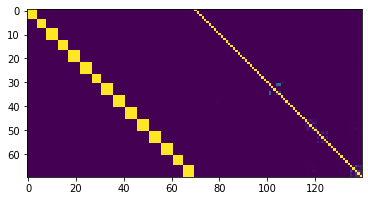

Linear SVM Model
it:1/50---cost:-2.13e+00--- elapsed:0.79 [s]



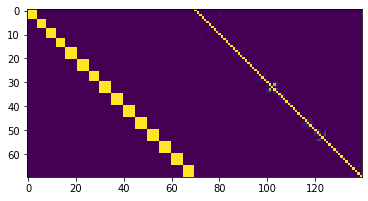

Guardando... LinearCKA_Fold7


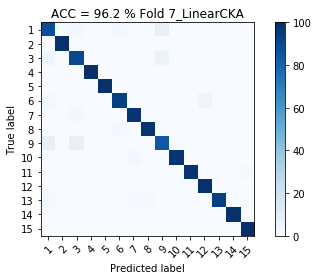

              precision    recall  f1-score   support

           1       0.85      0.88      0.87        51
           2       1.00      1.00      1.00        51
           3       0.88      0.90      0.89        50
           4       1.00      1.00      1.00        51
           5       1.00      1.00      1.00        50
           6       0.96      0.94      0.95        50
           7       0.96      0.98      0.97        51
           8       0.98      0.98      0.98        50
           9       0.86      0.84      0.85        50
          10       1.00      0.98      0.99        50
          11       1.00      0.98      0.99        50
          12       0.96      1.00      0.98        50
          13       1.00      0.94      0.97        50
          14       1.00      1.00      1.00        50
          15       0.98      1.00      0.99        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

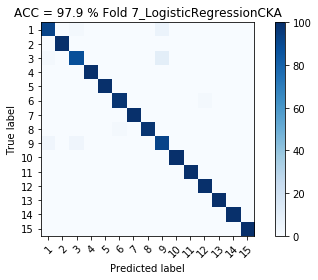

              precision    recall  f1-score   support

           1       0.94      0.92      0.93        51
           2       1.00      1.00      1.00        51
           3       0.94      0.88      0.91        50
           4       1.00      1.00      1.00        51
           5       1.00      1.00      1.00        50
           6       0.98      0.98      0.98        50
           7       1.00      1.00      1.00        51
           8       1.00      0.98      0.99        50
           9       0.85      0.92      0.88        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.98      1.00      0.99        50
          13       1.00      1.00      1.00        50
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.98       754
   macro avg       0.98      0.98      0.98       754
weighted avg       0.98   

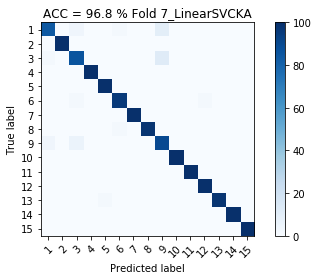

              precision    recall  f1-score   support

           1       0.93      0.84      0.89        51
           2       1.00      1.00      1.00        51
           3       0.88      0.86      0.87        50
           4       1.00      1.00      1.00        51
           5       0.98      1.00      0.99        50
           6       0.96      0.96      0.96        50
           7       1.00      1.00      1.00        51
           8       1.00      0.98      0.99        50
           9       0.80      0.90      0.85        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.98      1.00      0.99        50
          13       1.00      0.98      0.99        50
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   

7it [02:10, 18.69s/it]

Iteration =  8/10
Linear Model
it:1/50---cost:-2.11e+00--- elapsed:0.74 [s]



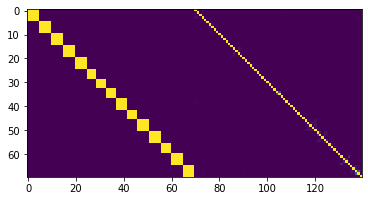

Logistic Regression Model
it:1/50---cost:-2.10e+00--- elapsed:0.73 [s]



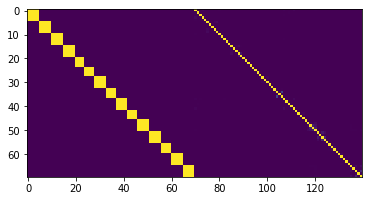

Linear SVM Model
it:1/50---cost:-2.13e+00--- elapsed:0.79 [s]



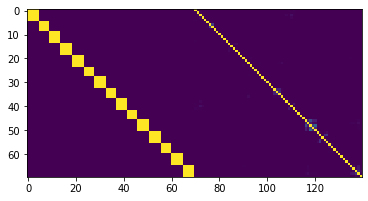

Guardando... LinearCKA_Fold8


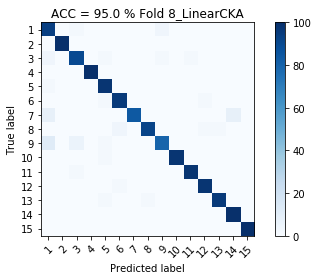

              precision    recall  f1-score   support

           1       0.78      0.94      0.85        50
           2       1.00      1.00      1.00        50
           3       0.90      0.90      0.90        50
           4       1.00      1.00      1.00        50
           5       0.91      0.98      0.94        50
           6       0.94      0.96      0.95        51
           7       1.00      0.84      0.91        50
           8       0.98      0.92      0.95        51
           9       0.93      0.80      0.86        50
          10       1.00      0.98      0.99        51
          11       0.98      0.98      0.98        50
          12       0.96      0.98      0.97        50
          13       0.98      0.96      0.97        51
          14       0.93      1.00      0.96        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

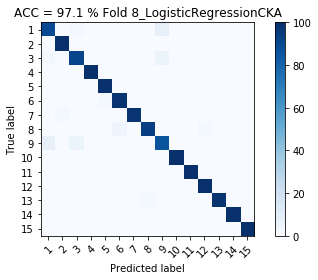

              precision    recall  f1-score   support

           1       0.90      0.90      0.90        50
           2       0.98      1.00      0.99        50
           3       0.92      0.92      0.92        50
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        50
           6       0.96      0.98      0.97        51
           7       1.00      0.98      0.99        50
           8       0.98      0.94      0.96        51
           9       0.86      0.86      0.86        50
          10       1.00      1.00      1.00        51
          11       1.00      1.00      1.00        50
          12       0.98      1.00      0.99        50
          13       1.00      0.98      0.99        51
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   

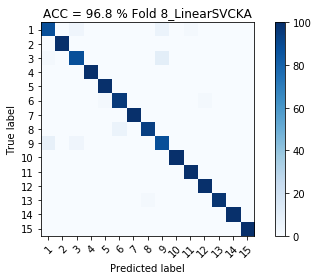

              precision    recall  f1-score   support

           1       0.90      0.88      0.89        50
           2       1.00      1.00      1.00        50
           3       0.92      0.88      0.90        50
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        50
           6       0.94      0.96      0.95        51
           7       1.00      1.00      1.00        50
           8       0.98      0.94      0.96        51
           9       0.85      0.88      0.86        50
          10       1.00      1.00      1.00        51
          11       0.98      1.00      0.99        50
          12       0.98      1.00      0.99        50
          13       1.00      0.98      0.99        51
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   

8it [02:30, 19.17s/it]

Iteration =  9/10
Linear Model
it:1/50---cost:-2.12e+00--- elapsed:0.74 [s]



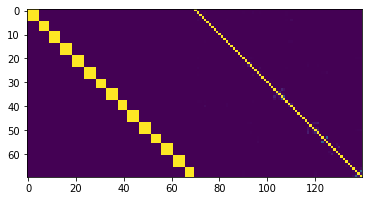

Logistic Regression Model
it:1/50---cost:-2.08e+00--- elapsed:0.73 [s]



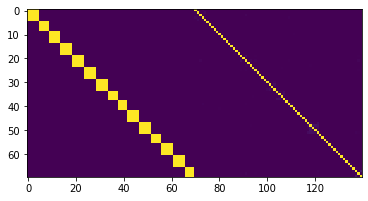

Linear SVM Model
it:1/50---cost:-2.12e+00--- elapsed:0.82 [s]



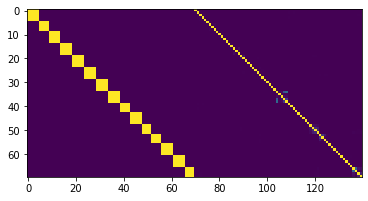

Guardando... LinearCKA_Fold9


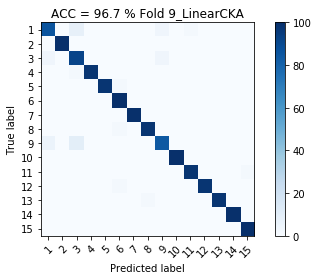

              precision    recall  f1-score   support

           1       0.90      0.86      0.88        50
           2       1.00      1.00      1.00        51
           3       0.82      0.92      0.87        50
           4       1.00      0.98      0.99        50
           5       1.00      0.98      0.99        50
           6       0.94      1.00      0.97        50
           7       1.00      1.00      1.00        50
           8       0.98      0.98      0.98        50
           9       0.91      0.84      0.88        51
          10       1.00      1.00      1.00        50
          11       0.98      0.98      0.98        50
          12       1.00      0.98      0.99        51
          13       1.00      0.98      0.99        50
          14       1.00      1.00      1.00        50
          15       0.98      1.00      0.99        51

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   

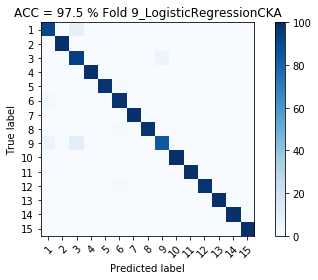

              precision    recall  f1-score   support

           1       0.92      0.92      0.92        50
           2       1.00      1.00      1.00        51
           3       0.84      0.94      0.89        50
           4       1.00      1.00      1.00        50
           5       1.00      0.98      0.99        50
           6       0.94      0.98      0.96        50
           7       1.00      1.00      1.00        50
           8       1.00      0.98      0.99        50
           9       0.93      0.84      0.89        51
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       1.00      0.98      0.99        51
          13       1.00      1.00      1.00        50
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        51

    accuracy                           0.97       754
   macro avg       0.98      0.97      0.97       754
weighted avg       0.98   

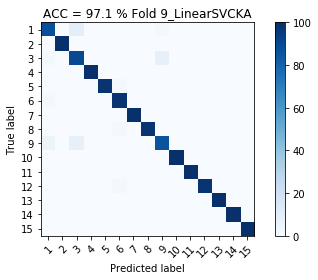

              precision    recall  f1-score   support

           1       0.90      0.88      0.89        50
           2       1.00      1.00      1.00        51
           3       0.83      0.90      0.87        50
           4       1.00      1.00      1.00        50
           5       1.00      0.98      0.99        50
           6       0.94      0.98      0.96        50
           7       1.00      1.00      1.00        50
           8       1.00      0.98      0.99        50
           9       0.90      0.86      0.88        51
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       1.00      0.98      0.99        51
          13       1.00      1.00      1.00        50
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        51

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   

9it [02:48, 18.92s/it]

Iteration =  10/10
Linear Model
it:1/50---cost:-2.10e+00--- elapsed:0.79 [s]



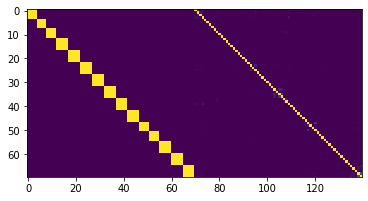

Logistic Regression Model
it:1/50---cost:-2.15e+00--- elapsed:0.74 [s]



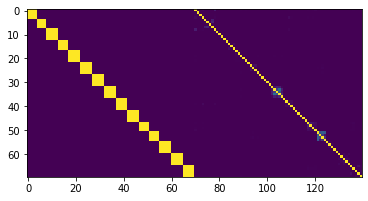

Linear SVM Model
it:1/50---cost:-2.11e+00--- elapsed:0.72 [s]



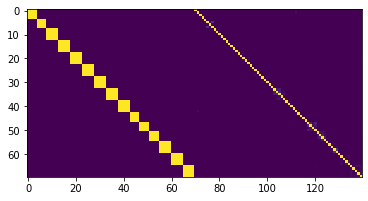

Guardando... LinearCKA_Fold10


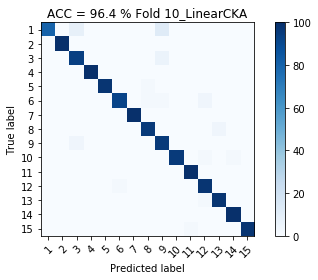

              precision    recall  f1-score   support

           1       1.00      0.80      0.89        51
           2       1.00      1.00      1.00        51
           3       0.89      0.94      0.91        50
           4       1.00      1.00      1.00        50
           5       1.00      0.98      0.99        50
           6       0.98      0.92      0.95        50
           7       1.00      1.00      1.00        50
           8       0.96      0.96      0.96        50
           9       0.83      0.96      0.89        50
          10       1.00      0.96      0.98        50
          11       0.98      1.00      0.99        51
          12       0.93      0.98      0.95        51
          13       0.96      0.98      0.97        50
          14       0.98      1.00      0.99        50
          15       1.00      0.98      0.99        50

    accuracy                           0.96       754
   macro avg       0.97      0.96      0.96       754
weighted avg       0.97   

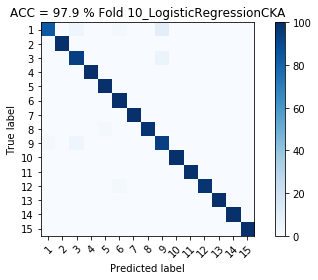

              precision    recall  f1-score   support

           1       0.98      0.84      0.91        51
           2       1.00      1.00      1.00        51
           3       0.92      0.94      0.93        50
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        50
           6       0.96      1.00      0.98        50
           7       1.00      1.00      1.00        50
           8       1.00      0.98      0.99        50
           9       0.85      0.94      0.90        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        51
          12       1.00      0.98      0.99        51
          13       1.00      1.00      1.00        50
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.98       754
   macro avg       0.98      0.98      0.98       754
weighted avg       0.98   

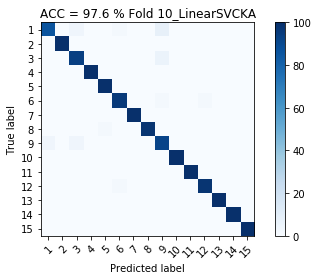

              precision    recall  f1-score   support

           1       0.96      0.86      0.91        51
           2       1.00      1.00      1.00        51
           3       0.92      0.94      0.93        50
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        50
           6       0.96      0.96      0.96        50
           7       1.00      1.00      1.00        50
           8       1.00      0.98      0.99        50
           9       0.85      0.92      0.88        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        51
          12       0.98      0.98      0.98        51
          13       1.00      1.00      1.00        50
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.98       754
   macro avg       0.98      0.98      0.98       754
weighted avg       0.98   

10it [03:06, 18.62s/it]


In [ ]:
# Traininig/Testing loop
fold = 0

for train_index, test_index in tqdm(sss.split(X,y)):
    # Training/testing index storage
    train_idx += [train_index]
    test_idx  += [test_index]
    
    # Number of partitions flag
    fold = fold + 1
    print("Iteration = ", str(fold) +'/'+ str(n_partitions))
    
    # Iteration file name 
    filename = img_path + "/Fold" + str(fold)

    # Train/Test partition and matrix storing to apply CKA over them for 
    # visualization
    X_train, X_test = Xr[train_index,:], Xr[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    X_train_cka += [X_train]
    X_test_cka  += [X_test]
    y_train_cka += [y_train]
    y_test_cka  += [y_test]

    # ---------------------------------------------------------------------------------------------------------------------------
    # Training
    
    # Linear
    print('Linear Model')
    # Using GridSearchCV 
    # hs_Lineal = GridSearchCV(Pipeline(steps[0]), parameters[0], n_jobs = 6, cv = 5, scoring = 'balanced_accuracy', verbose = 50)
    # Using RandomizedSearchCV
    hs_Lineal = RandomizedSearchCV(Pipeline(steps[0]), param_distributions=parameters[0],n_iter=10, cv=5, iid=False, n_jobs=20)
    hs_Lineal.fit(X_train,y_train)
    # Projection matrix from CKA
    W_cka_L += [hs_Lineal.best_estimator_.named_steps['Projection'].Wcka]


    # Logistic Regression
    print('Logistic Regression Model')
    # Usaing GridSearchCV 
    # hs_LogR = GridSearchCV(Pipeline(steps[1]), parameters[1], n_jobs = 6, cv = 5, scoring = 'balanced_accuracy', verbose = 50)
    # Using RandomizedSearchCV
    hs_LogR = RandomizedSearchCV(Pipeline(steps[1]), param_distributions=parameters[1],n_iter=10, cv=5, iid=False,n_jobs=20)
    hs_LogR.fit(X_train,y_train)
    # Projection matrix from CKA
    W_cka_LogR += [hs_LogR.best_estimator_.named_steps['Projection'].Wcka]
  

    # Linear SVM
    print('Linear SVM Model')
    # Using GridSearchCV 
    #hs_lSVM = GridSearchCV(Pipeline(steps[2]), parameters[2], n_jobs = 6, cv = 5, scoring = 'balanced_accuracy', verbose = 50)
    # Using RandomizedSearchCV
    hs_lSVM = RandomizedSearchCV(Pipeline(steps[2]), param_distributions=parameters[2],n_iter=10, cv=5, iid=False, n_jobs=20)  
    hs_lSVM.fit(X_train,y_train)
    # Projection matrix from CKA
    W_cka_lSVM += [hs_lSVM.best_estimator_.named_steps['Projection'].Wcka]

    # ---------------------------------------------------------------------------------------------------------------------------
    # Validation
    
    # Linear
    y_pred_L           = hs_Lineal.best_estimator_.predict(X_test)
    accuracy_L[fold-1] = accuracy_score(y_test,y_pred_L)
    cm_temp            = confusion_matrix(y_test,y_pred_L)
    cm_L[fold-1,:,:]   = 100*cm_temp.astype('float') / cm_temp.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(y_test, y_pred_L, classes=np.unique(y),normalize=True,title='ACC = %.1f %% Fold %d' % (100*accuracy_L[fold-1],fold) + '_'+ label_models[0])
    plt.autoscale()
    save_fig(img_path,label_models[0]+'_Fold'+str(fold))                      
    plt.show()
    cr_L += [classification_report(y_test,y_pred_L)]
    print(cr_L[-1])
    # Best model storage
    # best_mod_L += [hs_Lineal.best_estimator_, accuracy_L,cm_L,cr_L, sel_fts_L]
    # best_mod_L += [hs_Lineal.best_estimator_]
    best_pms_L += [hs_Lineal.best_params_]
    joblib.dump(best_pms_L, filename + "LinealCKA" + ".pkl")


    # Logistic Regression
    y_pred_LogR          = hs_LogR.best_estimator_.predict(X_test)
    accuracy_LogR[fold-1]= accuracy_score(y_test,y_pred_LogR)
    cm_temp              = confusion_matrix(y_test,y_pred_LogR)
    cm_LogR[fold-1,:,:]  = 100*cm_temp.astype('float') / cm_temp.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(y_test, y_pred_LogR, classes=np.unique(y),normalize=True,title='ACC = %.1f %% Fold %d' % (100*accuracy_LogR[fold-1],fold) + '_'+ label_models[1])
    plt.autoscale()
    save_fig(img_path,label_models[1]+'_Fold'+str(fold))                      
    plt.show()
    cr_LogR += [classification_report(y_test,y_pred_LogR)]
    print(cr_LogR[-1])
    # Best model storage
    # best_mod_LogR += [hs_LogR.best_estimator_, accuracy_LogR,cm_LogR,cr_LogR, sel_fts_LogR]
    # best_mod_LogR += [hs_LogR.best_estimator_]
    best_pms_LogR += [hs_LogR.best_params_]
    joblib.dump(best_pms_LogR, filename + "LogRCKA" + ".pkl")


    # Linear SVM
    y_pred_lSVM          = hs_lSVM.best_estimator_.predict(X_test)
    accuracy_lSVM[fold-1]= accuracy_score(y_test,y_pred_lSVM)
    cm_temp              = confusion_matrix(y_test,y_pred_lSVM)
    cm_LogR[fold-1,:,:]  = 100*cm_temp.astype('float') / cm_temp.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(y_test, y_pred_lSVM, classes=np.unique(y),normalize=True,title='ACC = %.1f %% Fold %d' % (100*accuracy_lSVM[fold-1],fold) + '_'+ label_models[2])
    plt.autoscale()
    save_fig(img_path,label_models[2]+'_Fold'+str(fold))                      
    plt.show()
    cr_lSVM += [classification_report(y_test,y_pred_lSVM)]
    print(cr_lSVM[-1])
    # Best model storage
    # best_mod_lSVM += [hs_lSVM.best_estimator_, accuracy_lSVM,cm_lSVM,cr_lSVM, sel_fts_lSVM]
    # best_mod_lSVM += [hs_lSVM.best_estimator_]
    best_pms_lSVM += [hs_lSVM.best_params_]
    joblib.dump(best_pms_lSVM, filename + "lSVMCKA" + ".pkl")
    
    # Results dictionary creation
    L_dict = {'accuracy_L': accuracy_L,
              'cm_L': cm_L,
              'cr_L': cr_L,
              'W_cka_L': W_cka_L,
              'X_train_cka': X_train_cka,
              'X_test_cka': X_test_cka,
              'y_train_cka':y_train_cka,
              'y_test_cka':y_test_cka}

    LogR_dict = {'accuracy_LogR': accuracy_LogR,
                'cm_LogR': cm_LogR,
                'cr_LogR': cr_LogR,
                'W_cka_LogR': W_cka_LogR,
                'X_train_cka': X_train_cka,
                'X_test_cka': X_test_cka,
                'y_train_cka':y_train_cka,
                'y_test_cka':y_test_cka}

    lSVM_dict = {'accuracy_lSVM': accuracy_lSVM,
                'cm_lSVM': cm_lSVM,
                'cr_lSVM': cr_lSVM,
                'W_cka_lSVM': W_cka_lSVM,
                'X_train_cka': X_train_cka,
                'X_test_cka': X_test_cka,
                'y_train_cka':y_train_cka,
                'y_test_cka':y_test_cka}

    Results = [L_dict, LogR_dict, lSVM_dict]

    joblib.dump(Results, rslt_dir + "Fold" + str(fold) + ".pkl")

Average result printing

In [ ]:
print('Linear Classifier')
print(str(np.mean(np.array(Results[0]['accuracy_L']))*100) + '+/-' + str(np.std(np.array(Results[0]['accuracy_L']))*100))

print('Logistic Regression Classifier')
print(str(np.mean(np.array(Results[1]['accuracy_LogR']))*100) + '+/-' + str(np.std(np.array(Results[1]['accuracy_LogR']))*100))

print('Linear SVM Classifier')
print(str(np.mean(np.array(Results[2]['accuracy_lSVM']))*100) + '+/-' + str(np.std(np.array(Results[2]['accuracy_lSVM']))*100))

Linear Classifier
96.18037135278514+/-0.8149756761664299
Logistic Regression Classifier
97.45358090185677+/-0.49553160987452016
Linear SVM Classifier
96.9893899204244+/-0.4928621797363953


Projection matrix plotting

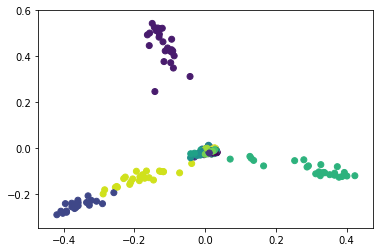

In [ ]:
W    = Results[1]['W_cka_LogR'][0]
Xp   = X_train_cka[0].dot(W)
# Plotting the projection matrix
plt.scatter(Xp[:,1],Xp[:,2],c = y_train_cka[0])

# **Step 5: Region Selection**

The algorithm now runs over the regions to know whose are more informative than others

In [ ]:
# Declaracion de variables
X            = X.to_numpy()
n_partitions = 10
test_per     = 0.67
n_classes    = len(np.unique(y))
f_step       = 1500
ftr_vec      = np.arange(f_step,int((X.shape[1]))+f_step,f_step).astype(int)
fold         = 0
# Arrays and lists to store at each fold
train_idx    = []
test_idx     = []
accuracy_L   = np.zeros((n_partitions,len(ftr_vec)))
accuracy_LogR= np.zeros((n_partitions,len(ftr_vec)))
accuracy_lSVM= np.zeros((n_partitions,len(ftr_vec)))
cm_L         = np.zeros((n_partitions,n_classes,n_classes))
cm_LogR      = np.zeros((n_partitions,n_classes,n_classes))
cm_lSVM      = np.zeros((n_partitions,n_classes,n_classes))
cr_L         = []
cr_LogR      = []
cr_lSVM      = []
best_mod_L   = []
best_mod_LogR= []
best_mod_lSVM= []
best_pms_L   = []
best_pms_LogR= []
best_pms_lSVM= []

In [ ]:
# Setting the data partition scheme to work like HoldOut validation
sss = StratifiedShuffleSplit(n_splits = n_partitions, test_size = test_per, random_state=42)

In [ ]:
# Step declaration
steps = [
        [('Preprocessing', StandardScaler()),
          ('Classification',SGDClassifier())],      # Clasificador Lineal
        ]
    
# Grid declaration
parameters = [
            {'Classification__penalty': ['l1', 'l2', 'elasticnet'] },
            ]

# Model labels
label_models = ['Linear']

In [ ]:
# Directory to save results and plots

rslt_dir     = img_dir + '/RegionSelection/RS_BoCF/Results_RS_BoCF_Py'
sys.path.append(rslt_dir)
img_path     = img_dir + '/RegionSelection/RS_BoCF/'
sys.path.append(img_path)

Loop to optimize the number of regions

0it [00:00, ?it/s]

Region =  1/21
Iteration =  1/10
Linear Model
Fitting 5 folds for each of 3 candidates, totalling 15 fits
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    1.0s
[Parallel(n_jobs=20)]: Done   2 out of  15 | elapsed:    1.0s remaining:    6.2s
[Parallel(n_jobs=20)]: Done   3 out of  15 | elapsed:    1.0s remaining:    3.8s
[Parallel(n_jobs=20)]: Done   4 out of  15 | elapsed:    1.0s remaining:    2.7s
[Parallel(n_jobs=20)]: Done   5 out of  15 | elapsed:    1.1s remaining:    2.2s
[Parallel(n_jobs=20)]: Done   6 out of  15 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=20)]: Done   7 out of  15 | elapsed:    1.4s remaining:    1.6s
[Parallel(n_jobs=20)]: Done   8 out of  15 | elapsed:    1.4s remaining:    1.2s
[Parallel(n_jobs=20)]: Done   9 out of  15 | elapsed:    1.4s remaining:    1.0s
[Parallel(n_jobs=20)]: Done  10 out of  15 | elapsed:    1.4s remaining:    0.7s
[Parallel(n_jobs=20)]: Don

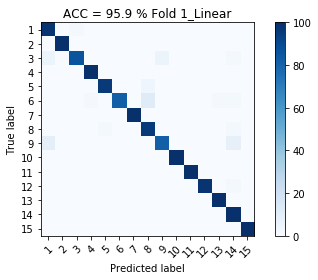

1it [00:02,  2.88s/it]

              precision    recall  f1-score   support

           1       0.86      0.98      0.92        50
           2       1.00      1.00      1.00        50
           3       0.98      0.86      0.91        50
           4       0.98      1.00      0.99        51
           5       0.98      0.96      0.97        50
           6       1.00      0.82      0.90        50
           7       1.00      1.00      1.00        51
           8       0.86      0.96      0.91        50
           9       0.93      0.82      0.87        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        51
          12       1.00      0.98      0.99        50
          13       0.98      1.00      0.99        51
          14       0.86      1.00      0.93        50
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

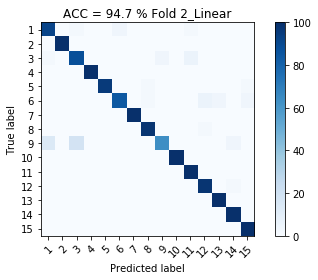

2it [00:05,  2.75s/it]

              precision    recall  f1-score   support

           1       0.85      0.92      0.88        50
           2       1.00      1.00      1.00        50
           3       0.81      0.88      0.85        50
           4       1.00      1.00      1.00        51
           5       1.00      0.96      0.98        50
           6       0.96      0.84      0.90        51
           7       1.00      1.00      1.00        50
           8       0.96      0.98      0.97        51
           9       0.94      0.64      0.76        50
          10       1.00      1.00      1.00        50
          11       0.93      1.00      0.96        50
          12       0.92      0.98      0.95        50
          13       0.96      1.00      0.98        50
          14       0.94      1.00      0.97        51
          15       0.94      1.00      0.97        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.94       754
weighted avg       0.95   

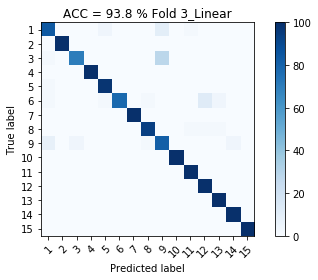

3it [00:07,  2.64s/it]

              precision    recall  f1-score   support

           1       0.86      0.84      0.85        50
           2       1.00      1.00      1.00        50
           3       0.95      0.70      0.80        50
           4       1.00      1.00      1.00        51
           5       0.94      0.98      0.96        51
           6       1.00      0.78      0.88        50
           7       1.00      1.00      1.00        51
           8       0.96      0.94      0.95        50
           9       0.68      0.82      0.75        50
          10       1.00      1.00      1.00        50
          11       0.96      1.00      0.98        50
          12       0.88      1.00      0.93        50
          13       0.94      1.00      0.97        51
          14       0.96      1.00      0.98        50
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

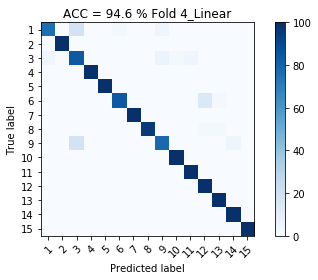

4it [00:09,  2.50s/it]

              precision    recall  f1-score   support

           1       0.95      0.76      0.84        50
           2       1.00      1.00      1.00        51
           3       0.70      0.84      0.77        51
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        50
           6       0.98      0.84      0.90        50
           7       1.00      1.00      1.00        51
           8       1.00      0.96      0.98        50
           9       0.89      0.78      0.83        50
          10       0.98      1.00      0.99        51
          11       0.96      1.00      0.98        50
          12       0.86      1.00      0.93        50
          13       0.96      1.00      0.98        50
          14       0.96      1.00      0.98        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

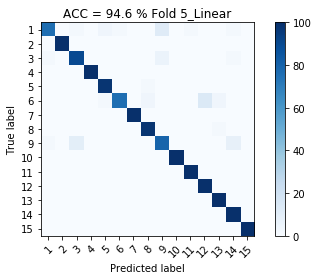

5it [00:11,  2.35s/it]

              precision    recall  f1-score   support

           1       0.95      0.76      0.84        50
           2       1.00      1.00      1.00        51
           3       0.88      0.90      0.89        50
           4       1.00      1.00      1.00        50
           5       0.94      0.98      0.96        50
           6       0.97      0.76      0.85        50
           7       1.00      1.00      1.00        51
           8       0.94      0.98      0.96        50
           9       0.82      0.80      0.81        50
          10       1.00      1.00      1.00        50
          11       0.98      1.00      0.99        50
          12       0.88      1.00      0.94        51
          13       0.94      1.00      0.97        50
          14       0.89      1.00      0.94        51
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.94       754
weighted avg       0.95   

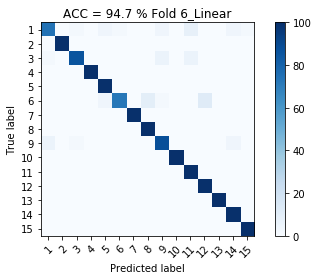

6it [00:14,  2.39s/it]

              precision    recall  f1-score   support

           1       0.90      0.75      0.82        51
           2       1.00      1.00      1.00        50
           3       0.96      0.86      0.91        51
           4       1.00      1.00      1.00        50
           5       0.93      1.00      0.96        50
           6       0.97      0.73      0.83        51
           7       1.00      1.00      1.00        50
           8       0.91      1.00      0.95        51
           9       0.88      0.88      0.88        50
          10       1.00      1.00      1.00        50
          11       0.88      1.00      0.93        50
          12       0.89      1.00      0.94        50
          13       1.00      1.00      1.00        50
          14       0.93      1.00      0.96        50
          15       0.98      1.00      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

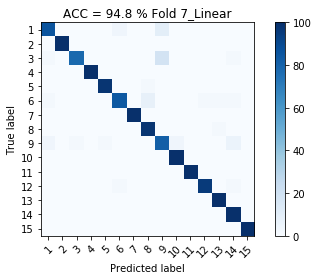

7it [00:16,  2.32s/it]

              precision    recall  f1-score   support

           1       0.92      0.86      0.89        51
           2       1.00      1.00      1.00        51
           3       0.97      0.78      0.87        50
           4       1.00      1.00      1.00        51
           5       0.98      0.98      0.98        50
           6       0.93      0.84      0.88        50
           7       1.00      1.00      1.00        51
           8       0.91      0.98      0.94        50
           9       0.75      0.82      0.78        50
          10       0.96      1.00      0.98        50
          11       1.00      1.00      1.00        50
          12       0.98      0.96      0.97        50
          13       0.96      1.00      0.98        50
          14       0.89      1.00      0.94        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

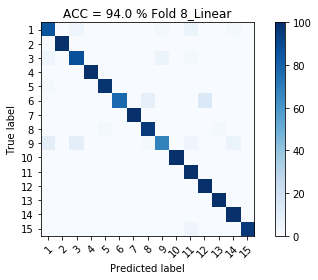

8it [00:18,  2.34s/it]

              precision    recall  f1-score   support

           1       0.84      0.86      0.85        50
           2       1.00      1.00      1.00        50
           3       0.86      0.88      0.87        50
           4       1.00      1.00      1.00        50
           5       0.98      0.98      0.98        50
           6       1.00      0.78      0.88        51
           7       1.00      1.00      1.00        50
           8       0.91      0.96      0.93        51
           9       0.89      0.68      0.77        50
          10       1.00      1.00      1.00        51
          11       0.86      1.00      0.93        50
          12       0.88      1.00      0.93        50
          13       0.98      1.00      0.99        51
          14       0.93      1.00      0.96        50
          15       1.00      0.96      0.98        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

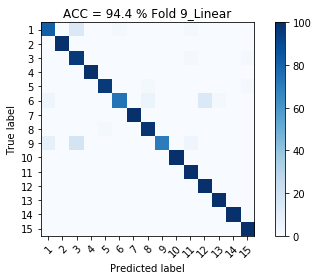

9it [00:20,  2.26s/it]

              precision    recall  f1-score   support

           1       0.87      0.82      0.85        50
           2       1.00      1.00      1.00        51
           3       0.75      0.96      0.84        50
           4       1.00      1.00      1.00        50
           5       0.98      0.96      0.97        50
           6       0.97      0.74      0.84        50
           7       1.00      1.00      1.00        50
           8       0.92      0.98      0.95        50
           9       1.00      0.71      0.83        51
          10       1.00      1.00      1.00        50
          11       0.93      1.00      0.96        50
          12       0.88      1.00      0.94        51
          13       0.98      1.00      0.99        50
          14       1.00      1.00      1.00        50
          15       0.96      1.00      0.98        51

    accuracy                           0.94       754
   macro avg       0.95      0.94      0.94       754
weighted avg       0.95   

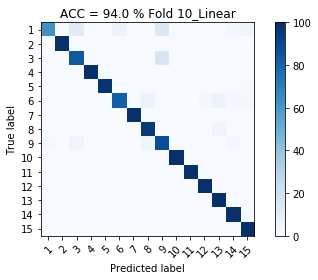

10it [00:22,  2.30s/it]
0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.97      0.63      0.76        51
           2       1.00      1.00      1.00        51
           3       0.84      0.84      0.84        50
           4       1.00      1.00      1.00        50
           5       1.00      0.98      0.99        50
           6       0.93      0.82      0.87        50
           7       1.00      1.00      1.00        50
           8       0.91      0.96      0.93        50
           9       0.75      0.88      0.81        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        51
          12       0.98      1.00      0.99        51
          13       0.91      1.00      0.95        50
          14       0.94      1.00      0.97        50
          15       0.93      1.00      0.96        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

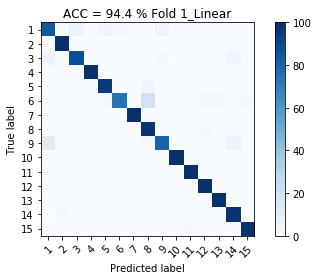

1it [00:05,  5.00s/it]

              precision    recall  f1-score   support

           1       0.82      0.84      0.83        50
           2       0.98      1.00      0.99        50
           3       0.94      0.88      0.91        50
           4       1.00      1.00      1.00        51
           5       0.94      0.96      0.95        50
           6       0.97      0.74      0.84        50
           7       1.00      1.00      1.00        51
           8       0.80      0.98      0.88        50
           9       0.93      0.80      0.86        50
          10       1.00      1.00      1.00        50
          11       0.98      1.00      0.99        51
          12       0.96      1.00      0.98        50
          13       0.98      1.00      0.99        51
          14       0.91      0.98      0.94        50
          15       0.98      0.98      0.98        50

    accuracy                           0.94       754
   macro avg       0.95      0.94      0.94       754
weighted avg       0.95   

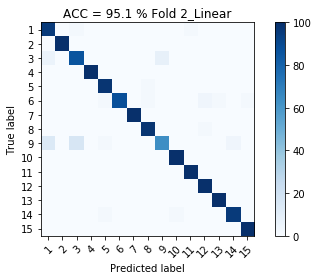

2it [00:09,  4.76s/it]

              precision    recall  f1-score   support

           1       0.83      0.96      0.89        50
           2       1.00      1.00      1.00        50
           3       0.83      0.86      0.84        50
           4       1.00      1.00      1.00        51
           5       0.94      0.98      0.96        50
           6       1.00      0.88      0.94        51
           7       1.00      1.00      1.00        50
           8       0.96      0.98      0.97        51
           9       0.89      0.64      0.74        50
          10       0.98      1.00      0.99        50
          11       0.98      1.00      0.99        50
          12       0.94      1.00      0.97        50
          13       0.98      1.00      0.99        50
          14       0.96      0.96      0.96        51
          15       0.98      1.00      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

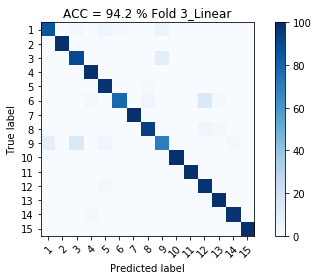

3it [00:13,  4.55s/it]

              precision    recall  f1-score   support

           1       0.90      0.86      0.88        50
           2       1.00      1.00      1.00        50
           3       0.85      0.90      0.87        50
           4       0.96      1.00      0.98        51
           5       0.91      0.98      0.94        51
           6       0.97      0.78      0.87        50
           7       1.00      1.00      1.00        51
           8       0.94      0.94      0.94        50
           9       0.81      0.70      0.75        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.84      0.98      0.91        50
          13       0.96      1.00      0.98        51
          14       0.98      0.98      0.98        50
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

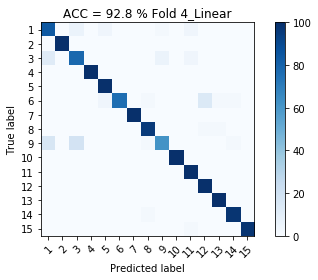

4it [00:17,  4.44s/it]

              precision    recall  f1-score   support

           1       0.75      0.84      0.79        50
           2       1.00      1.00      1.00        51
           3       0.77      0.78      0.78        51
           4       1.00      1.00      1.00        50
           5       0.93      1.00      0.96        50
           6       1.00      0.76      0.86        50
           7       1.00      1.00      1.00        51
           8       0.94      0.96      0.95        50
           9       0.89      0.62      0.73        50
          10       1.00      1.00      1.00        51
          11       0.91      1.00      0.95        50
          12       0.86      1.00      0.93        50
          13       0.96      1.00      0.98        50
          14       0.96      0.98      0.97        50
          15       1.00      0.98      0.99        50

    accuracy                           0.93       754
   macro avg       0.93      0.93      0.93       754
weighted avg       0.93   

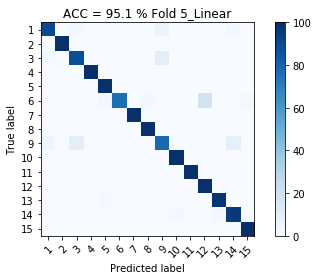

5it [00:21,  4.20s/it]

              precision    recall  f1-score   support

           1       0.94      0.90      0.92        50
           2       1.00      1.00      1.00        51
           3       0.88      0.88      0.88        50
           4       1.00      1.00      1.00        50
           5       0.96      1.00      0.98        50
           6       1.00      0.76      0.86        50
           7       1.00      1.00      1.00        51
           8       0.98      1.00      0.99        50
           9       0.83      0.78      0.80        50
          10       0.98      1.00      0.99        50
          11       1.00      1.00      1.00        50
          12       0.85      1.00      0.92        51
          13       0.98      0.98      0.98        50
          14       0.91      0.96      0.93        51
          15       0.98      1.00      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

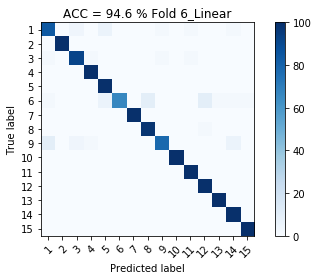

6it [00:23,  3.78s/it]

              precision    recall  f1-score   support

           1       0.86      0.84      0.85        51
           2       1.00      1.00      1.00        50
           3       0.92      0.92      0.92        51
           4       0.96      1.00      0.98        50
           5       0.89      1.00      0.94        50
           6       1.00      0.67      0.80        51
           7       1.00      1.00      1.00        50
           8       0.91      0.98      0.94        51
           9       0.95      0.78      0.86        50
          10       1.00      1.00      1.00        50
          11       0.96      1.00      0.98        50
          12       0.89      1.00      0.94        50
          13       0.98      1.00      0.99        50
          14       0.91      1.00      0.95        50
          15       0.98      1.00      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.94       754
weighted avg       0.95   

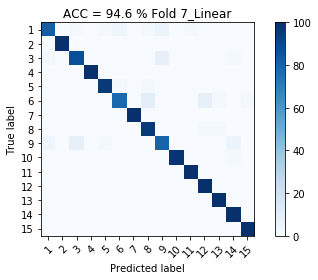

7it [00:27,  3.78s/it]

              precision    recall  f1-score   support

           1       0.93      0.82      0.87        51
           2       1.00      1.00      1.00        51
           3       0.90      0.88      0.89        50
           4       1.00      1.00      1.00        51
           5       0.96      0.96      0.96        50
           6       0.93      0.78      0.85        50
           7       1.00      1.00      1.00        51
           8       0.87      0.96      0.91        50
           9       0.85      0.80      0.82        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.91      1.00      0.95        50
          13       0.96      1.00      0.98        50
          14       0.91      1.00      0.95        50
          15       0.98      1.00      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.94       754
weighted avg       0.95   

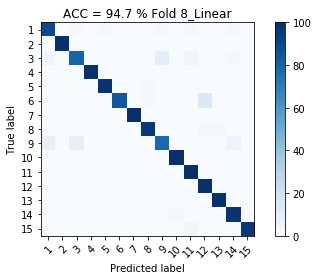

8it [00:31,  3.73s/it]

              precision    recall  f1-score   support

           1       0.88      0.90      0.89        50
           2       1.00      1.00      1.00        50
           3       0.89      0.80      0.84        50
           4       1.00      1.00      1.00        50
           5       0.98      0.98      0.98        50
           6       1.00      0.84      0.91        51
           7       1.00      1.00      1.00        50
           8       0.96      0.96      0.96        51
           9       0.87      0.78      0.82        50
          10       0.98      1.00      0.99        51
          11       0.91      1.00      0.95        50
          12       0.86      1.00      0.93        50
          13       0.98      1.00      0.99        51
          14       0.91      0.98      0.94        50
          15       1.00      0.96      0.98        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

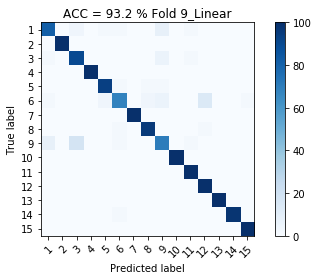

9it [00:34,  3.70s/it]

              precision    recall  f1-score   support

           1       0.87      0.82      0.85        50
           2       1.00      1.00      1.00        51
           3       0.80      0.90      0.85        50
           4       1.00      1.00      1.00        50
           5       0.94      0.94      0.94        50
           6       0.87      0.68      0.76        50
           7       1.00      1.00      1.00        50
           8       0.94      0.96      0.95        50
           9       0.77      0.71      0.73        51
          10       1.00      1.00      1.00        50
          11       0.94      1.00      0.97        50
          12       0.86      1.00      0.93        51
          13       1.00      1.00      1.00        50
          14       1.00      0.98      0.99        50
          15       0.98      1.00      0.99        51

    accuracy                           0.93       754
   macro avg       0.93      0.93      0.93       754
weighted avg       0.93   

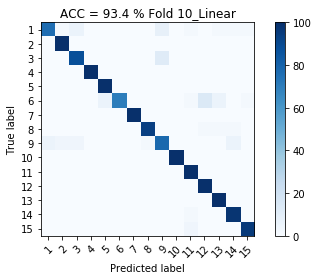

10it [00:37,  3.76s/it]
0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.93      0.76      0.84        51
           2       0.94      1.00      0.97        51
           3       0.90      0.88      0.89        50
           4       1.00      1.00      1.00        50
           5       0.94      1.00      0.97        50
           6       1.00      0.70      0.82        50
           7       1.00      1.00      1.00        50
           8       0.98      0.94      0.96        50
           9       0.80      0.78      0.79        50
          10       1.00      1.00      1.00        50
          11       0.91      1.00      0.95        51
          12       0.86      1.00      0.93        51
          13       0.91      1.00      0.95        50
          14       0.91      0.98      0.94        50
          15       0.96      0.96      0.96        50

    accuracy                           0.93       754
   macro avg       0.94      0.93      0.93       754
weighted avg       0.94   

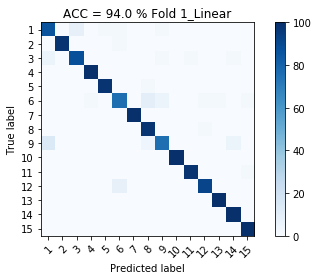

1it [00:05,  5.91s/it]

              precision    recall  f1-score   support

           1       0.81      0.86      0.83        50
           2       1.00      0.98      0.99        50
           3       0.92      0.88      0.90        50
           4       0.98      1.00      0.99        51
           5       0.98      0.98      0.98        50
           6       0.86      0.76      0.81        50
           7       1.00      1.00      1.00        51
           8       0.86      0.98      0.92        50
           9       0.88      0.76      0.82        50
          10       1.00      1.00      1.00        50
          11       0.98      0.98      0.98        51
          12       0.96      0.92      0.94        50
          13       0.98      1.00      0.99        51
          14       0.93      1.00      0.96        50
          15       0.96      1.00      0.98        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

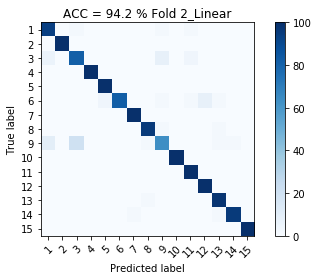

2it [00:11,  5.91s/it]

              precision    recall  f1-score   support

           1       0.85      0.94      0.90        50
           2       1.00      1.00      1.00        50
           3       0.79      0.82      0.80        50
           4       1.00      1.00      1.00        51
           5       0.96      1.00      0.98        50
           6       1.00      0.82      0.90        51
           7       0.98      1.00      0.99        50
           8       0.96      0.96      0.96        51
           9       0.82      0.64      0.72        50
          10       1.00      1.00      1.00        50
          11       0.93      1.00      0.96        50
          12       0.93      1.00      0.96        50
          13       0.92      0.98      0.95        50
          14       0.98      0.96      0.97        51
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

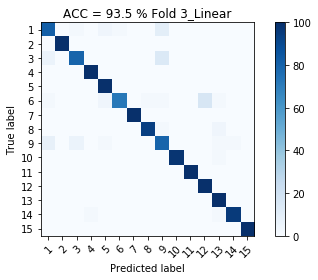

3it [00:17,  5.97s/it]

              precision    recall  f1-score   support

           1       0.84      0.82      0.83        50
           2       1.00      1.00      1.00        50
           3       0.91      0.80      0.85        50
           4       0.98      1.00      0.99        51
           5       0.91      1.00      0.95        51
           6       0.97      0.72      0.83        50
           7       1.00      1.00      1.00        51
           8       0.98      0.94      0.96        50
           9       0.74      0.80      0.77        50
          10       1.00      0.98      0.99        50
          11       1.00      1.00      1.00        50
          12       0.86      1.00      0.93        50
          13       0.89      1.00      0.94        51
          14       0.98      0.96      0.97        50
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.94      0.93      0.93       754
weighted avg       0.94   

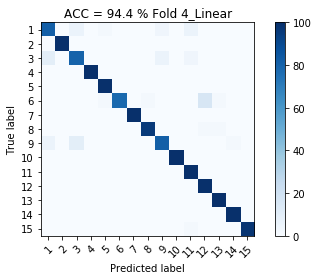

4it [00:24,  6.18s/it]

              precision    recall  f1-score   support

           1       0.84      0.82      0.83        50
           2       1.00      1.00      1.00        51
           3       0.84      0.80      0.82        51
           4       1.00      1.00      1.00        50
           5       0.96      1.00      0.98        50
           6       1.00      0.78      0.88        50
           7       1.00      1.00      1.00        51
           8       0.98      0.96      0.97        50
           9       0.89      0.82      0.85        50
          10       1.00      1.00      1.00        51
          11       0.89      1.00      0.94        50
          12       0.85      1.00      0.92        50
          13       0.96      1.00      0.98        50
          14       0.98      1.00      0.99        50
          15       1.00      0.98      0.99        50

    accuracy                           0.94       754
   macro avg       0.95      0.94      0.94       754
weighted avg       0.95   

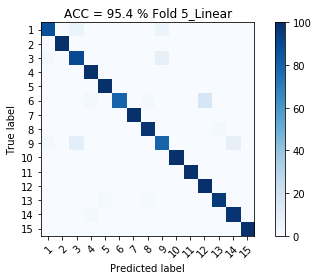

5it [00:31,  6.30s/it]

              precision    recall  f1-score   support

           1       0.96      0.88      0.92        50
           2       1.00      1.00      1.00        51
           3       0.85      0.90      0.87        50
           4       0.96      1.00      0.98        50
           5       0.98      1.00      0.99        50
           6       1.00      0.80      0.89        50
           7       1.00      1.00      1.00        51
           8       0.96      0.98      0.97        50
           9       0.85      0.80      0.82        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.86      1.00      0.93        51
          13       0.98      0.96      0.97        50
          14       0.93      0.98      0.95        51
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.96      0.95      0.95       754
weighted avg       0.96   

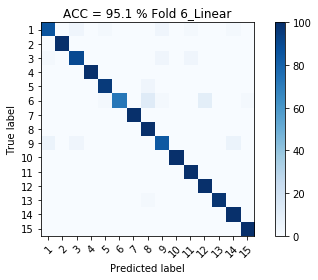

6it [00:37,  6.21s/it]

              precision    recall  f1-score   support

           1       0.92      0.86      0.89        51
           2       1.00      1.00      1.00        50
           3       0.92      0.90      0.91        51
           4       1.00      1.00      1.00        50
           5       0.96      0.96      0.96        50
           6       1.00      0.73      0.84        51
           7       1.00      1.00      1.00        50
           8       0.85      1.00      0.92        51
           9       0.89      0.84      0.87        50
          10       1.00      1.00      1.00        50
          11       0.94      1.00      0.97        50
          12       0.91      1.00      0.95        50
          13       1.00      0.98      0.99        50
          14       0.93      1.00      0.96        50
          15       0.98      1.00      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

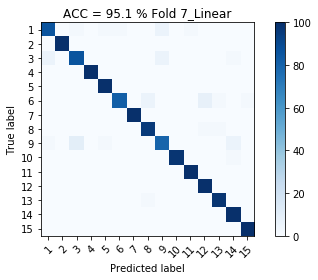

7it [00:43,  6.27s/it]

              precision    recall  f1-score   support

           1       0.92      0.86      0.89        51
           2       1.00      1.00      1.00        51
           3       0.88      0.86      0.87        50
           4       1.00      1.00      1.00        51
           5       0.96      1.00      0.98        50
           6       0.98      0.82      0.89        50
           7       1.00      1.00      1.00        51
           8       0.92      0.96      0.94        50
           9       0.87      0.80      0.83        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.91      1.00      0.95        50
          13       0.96      0.98      0.97        50
          14       0.91      1.00      0.95        50
          15       0.98      1.00      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

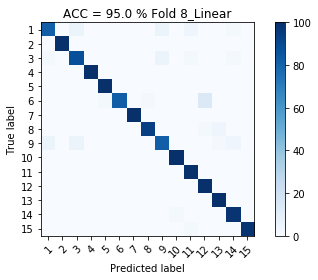

8it [00:49,  6.29s/it]

              precision    recall  f1-score   support

           1       0.91      0.82      0.86        50
           2       1.00      1.00      1.00        50
           3       0.88      0.88      0.88        50
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        50
           6       1.00      0.82      0.90        51
           7       1.00      1.00      1.00        50
           8       0.98      0.94      0.96        51
           9       0.87      0.82      0.85        50
          10       0.98      1.00      0.99        51
          11       0.93      1.00      0.96        50
          12       0.86      1.00      0.93        50
          13       0.94      1.00      0.97        51
          14       0.92      0.98      0.95        50
          15       1.00      0.98      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

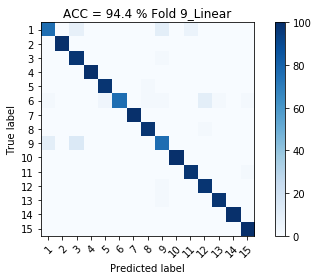

9it [00:54,  5.78s/it]

              precision    recall  f1-score   support

           1       0.86      0.76      0.81        50
           2       1.00      1.00      1.00        51
           3       0.82      0.98      0.89        50
           4       1.00      1.00      1.00        50
           5       0.96      0.98      0.97        50
           6       1.00      0.76      0.86        50
           7       1.00      1.00      1.00        50
           8       0.96      0.98      0.97        50
           9       0.81      0.76      0.79        51
          10       1.00      1.00      1.00        50
          11       0.94      0.98      0.96        50
          12       0.89      0.98      0.93        51
          13       0.98      0.98      0.98        50
          14       1.00      1.00      1.00        50
          15       0.96      1.00      0.98        51

    accuracy                           0.94       754
   macro avg       0.95      0.94      0.94       754
weighted avg       0.95   

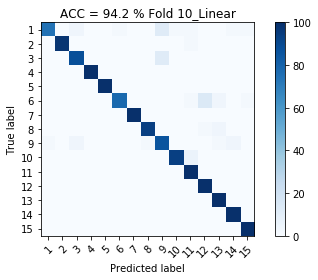

10it [01:00,  6.08s/it]
0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.97      0.75      0.84        51
           2       1.00      0.98      0.99        51
           3       0.92      0.88      0.90        50
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        50
           6       0.97      0.78      0.87        50
           7       1.00      1.00      1.00        50
           8       0.98      0.94      0.96        50
           9       0.78      0.86      0.82        50
          10       0.98      0.94      0.96        50
          11       0.89      1.00      0.94        51
          12       0.86      1.00      0.93        51
          13       0.91      1.00      0.95        50
          14       0.94      1.00      0.97        50
          15       0.96      1.00      0.98        50

    accuracy                           0.94       754
   macro avg       0.95      0.94      0.94       754
weighted avg       0.95   

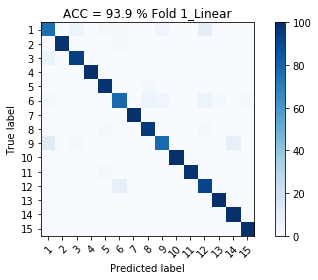

1it [00:08,  8.53s/it]

              precision    recall  f1-score   support

           1       0.79      0.76      0.78        50
           2       1.00      0.98      0.99        50
           3       0.92      0.94      0.93        50
           4       1.00      1.00      1.00        51
           5       0.94      0.98      0.96        50
           6       0.87      0.78      0.82        50
           7       1.00      1.00      1.00        51
           8       0.92      0.96      0.94        50
           9       0.91      0.78      0.84        50
          10       1.00      1.00      1.00        50
          11       1.00      0.98      0.99        51
          12       0.84      0.92      0.88        50
          13       0.98      1.00      0.99        51
          14       0.93      1.00      0.96        50
          15       0.98      1.00      0.99        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

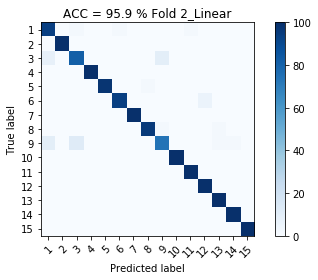

2it [00:16,  8.43s/it]

              precision    recall  f1-score   support

           1       0.84      0.94      0.89        50
           2       1.00      1.00      1.00        50
           3       0.85      0.82      0.84        50
           4       1.00      1.00      1.00        51
           5       1.00      0.98      0.99        50
           6       0.98      0.94      0.96        51
           7       1.00      1.00      1.00        50
           8       0.98      0.96      0.97        51
           9       0.86      0.74      0.80        50
          10       1.00      1.00      1.00        50
          11       0.98      1.00      0.99        50
          12       0.94      1.00      0.97        50
          13       0.96      1.00      0.98        50
          14       0.98      1.00      0.99        51
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

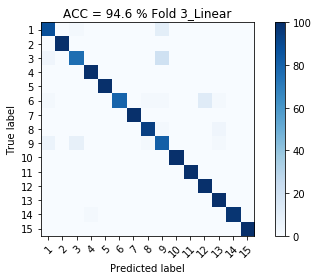

3it [00:25,  8.66s/it]

              precision    recall  f1-score   support

           1       0.88      0.88      0.88        50
           2       1.00      1.00      1.00        50
           3       0.88      0.76      0.82        50
           4       0.98      1.00      0.99        51
           5       1.00      1.00      1.00        51
           6       1.00      0.80      0.89        50
           7       1.00      1.00      1.00        51
           8       0.96      0.94      0.95        50
           9       0.71      0.82      0.76        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.89      1.00      0.94        50
          13       0.93      1.00      0.96        51
          14       1.00      0.98      0.99        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

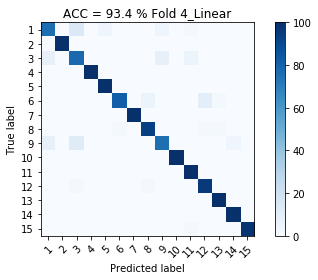

4it [00:34,  8.56s/it]

              precision    recall  f1-score   support

           1       0.83      0.76      0.79        50
           2       1.00      1.00      1.00        51
           3       0.74      0.78      0.76        51
           4       1.00      1.00      1.00        50
           5       0.96      1.00      0.98        50
           6       0.98      0.82      0.89        50
           7       1.00      1.00      1.00        51
           8       0.92      0.94      0.93        50
           9       0.86      0.76      0.81        50
          10       1.00      1.00      1.00        51
          11       0.91      1.00      0.95        50
          12       0.89      0.96      0.92        50
          13       0.96      1.00      0.98        50
          14       0.96      1.00      0.98        50
          15       1.00      0.98      0.99        50

    accuracy                           0.93       754
   macro avg       0.93      0.93      0.93       754
weighted avg       0.93   

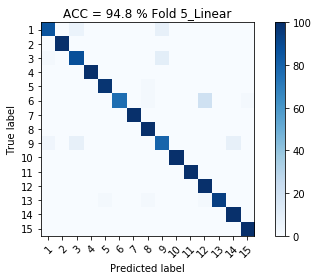

5it [00:39,  7.69s/it]

              precision    recall  f1-score   support

           1       0.93      0.86      0.90        50
           2       1.00      1.00      1.00        51
           3       0.86      0.88      0.87        50
           4       1.00      1.00      1.00        50
           5       0.98      0.98      0.98        50
           6       1.00      0.76      0.86        50
           7       1.00      1.00      1.00        51
           8       0.94      1.00      0.97        50
           9       0.82      0.80      0.81        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.82      1.00      0.90        51
          13       1.00      0.94      0.97        50
          14       0.93      1.00      0.96        51
          15       0.98      1.00      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

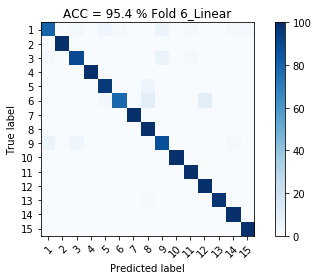

6it [00:48,  7.88s/it]

              precision    recall  f1-score   support

           1       0.91      0.80      0.85        51
           2       1.00      1.00      1.00        50
           3       0.94      0.90      0.92        51
           4       1.00      1.00      1.00        50
           5       0.94      0.96      0.95        50
           6       0.98      0.78      0.87        51
           7       1.00      1.00      1.00        50
           8       0.86      1.00      0.93        51
           9       0.88      0.88      0.88        50
          10       1.00      1.00      1.00        50
          11       0.96      1.00      0.98        50
          12       0.91      1.00      0.95        50
          13       1.00      0.98      0.99        50
          14       0.96      1.00      0.98        50
          15       0.98      1.00      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

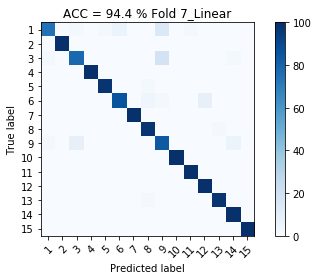

7it [00:56,  8.11s/it]

              precision    recall  f1-score   support

           1       0.95      0.75      0.84        51
           2       1.00      1.00      1.00        51
           3       0.89      0.78      0.83        50
           4       1.00      1.00      1.00        51
           5       0.98      0.98      0.98        50
           6       0.93      0.86      0.90        50
           7       1.00      1.00      1.00        51
           8       0.92      0.98      0.95        50
           9       0.71      0.84      0.77        50
          10       1.00      1.00      1.00        50
          11       0.98      1.00      0.99        50
          12       0.93      1.00      0.96        50
          13       0.98      0.98      0.98        50
          14       0.93      1.00      0.96        50
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.95      0.94      0.94       754
weighted avg       0.95   

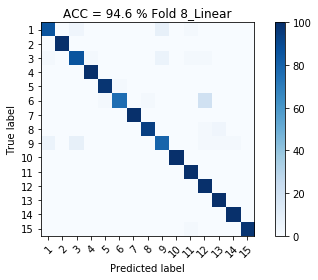

8it [01:05,  8.22s/it]

              precision    recall  f1-score   support

           1       0.91      0.86      0.89        50
           2       1.00      1.00      1.00        50
           3       0.88      0.86      0.87        50
           4       0.98      1.00      0.99        50
           5       0.98      0.98      0.98        50
           6       0.97      0.76      0.86        51
           7       1.00      1.00      1.00        50
           8       0.98      0.94      0.96        51
           9       0.85      0.80      0.82        50
          10       1.00      1.00      1.00        51
          11       0.94      1.00      0.97        50
          12       0.79      1.00      0.88        50
          13       0.94      1.00      0.97        51
          14       0.98      1.00      0.99        50
          15       1.00      0.98      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.94       754
weighted avg       0.95   

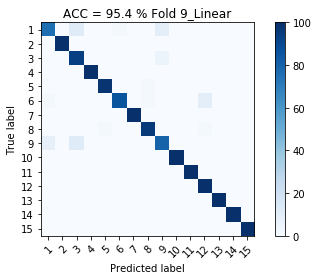

9it [01:16,  8.99s/it]

              precision    recall  f1-score   support

           1       0.88      0.76      0.82        50
           2       1.00      1.00      1.00        51
           3       0.80      0.94      0.86        50
           4       1.00      1.00      1.00        50
           5       0.98      0.98      0.98        50
           6       0.98      0.86      0.91        50
           7       1.00      1.00      1.00        50
           8       0.96      0.96      0.96        50
           9       0.84      0.80      0.82        51
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.89      1.00      0.94        51
          13       1.00      1.00      1.00        50
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        51

    accuracy                           0.95       754
   macro avg       0.96      0.95      0.95       754
weighted avg       0.96   

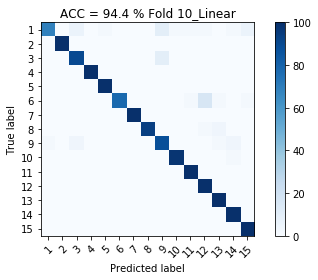

10it [01:21,  8.19s/it]
0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.97      0.69      0.80        51
           2       1.00      1.00      1.00        51
           3       0.90      0.90      0.90        50
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        50
           6       1.00      0.78      0.88        50
           7       1.00      1.00      1.00        50
           8       1.00      0.94      0.97        50
           9       0.81      0.88      0.85        50
          10       0.98      0.98      0.98        50
          11       0.96      1.00      0.98        51
          12       0.84      1.00      0.91        51
          13       0.93      1.00      0.96        50
          14       0.93      1.00      0.96        50
          15       0.93      1.00      0.96        50

    accuracy                           0.94       754
   macro avg       0.95      0.94      0.94       754
weighted avg       0.95   

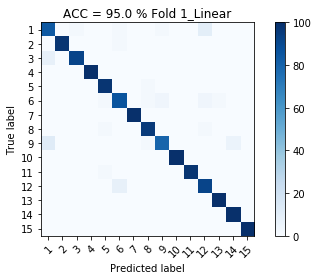

1it [00:10, 10.87s/it]

              precision    recall  f1-score   support

           1       0.81      0.84      0.82        50
           2       1.00      0.98      0.99        50
           3       0.98      0.92      0.95        50
           4       1.00      1.00      1.00        51
           5       0.94      0.98      0.96        50
           6       0.88      0.86      0.87        50
           7       1.00      1.00      1.00        51
           8       0.94      0.96      0.95        50
           9       0.93      0.80      0.86        50
          10       1.00      1.00      1.00        50
          11       1.00      0.98      0.99        51
          12       0.85      0.92      0.88        50
          13       0.98      1.00      0.99        51
          14       0.94      1.00      0.97        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

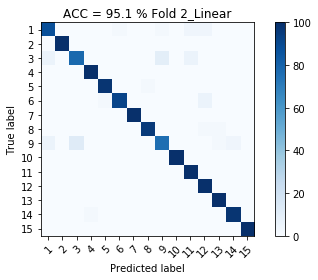

2it [00:17,  9.65s/it]

              precision    recall  f1-score   support

           1       0.88      0.88      0.88        50
           2       1.00      1.00      1.00        50
           3       0.87      0.78      0.82        50
           4       0.98      1.00      0.99        51
           5       0.98      0.98      0.98        50
           6       0.98      0.92      0.95        51
           7       1.00      1.00      1.00        50
           8       0.98      0.96      0.97        51
           9       0.86      0.76      0.81        50
          10       1.00      1.00      1.00        50
          11       0.91      1.00      0.95        50
          12       0.89      1.00      0.94        50
          13       0.96      1.00      0.98        50
          14       0.96      0.98      0.97        51
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

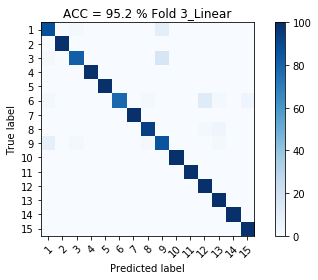

3it [00:29, 10.41s/it]

              precision    recall  f1-score   support

           1       0.88      0.88      0.88        50
           2       1.00      1.00      1.00        50
           3       0.95      0.82      0.88        50
           4       1.00      1.00      1.00        51
           5       1.00      1.00      1.00        51
           6       1.00      0.78      0.88        50
           7       1.00      1.00      1.00        51
           8       0.96      0.94      0.95        50
           9       0.77      0.86      0.81        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.88      1.00      0.93        50
          13       0.93      1.00      0.96        51
          14       1.00      1.00      1.00        50
          15       0.96      1.00      0.98        50

    accuracy                           0.95       754
   macro avg       0.96      0.95      0.95       754
weighted avg       0.96   

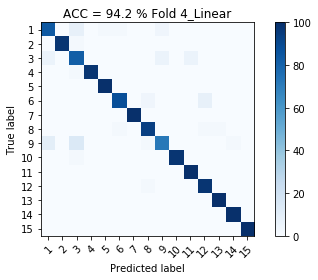

4it [00:40, 10.56s/it]

              precision    recall  f1-score   support

           1       0.84      0.84      0.84        50
           2       1.00      0.98      0.99        51
           3       0.75      0.82      0.79        51
           4       1.00      0.98      0.99        50
           5       0.98      1.00      0.99        50
           6       0.96      0.88      0.92        50
           7       1.00      1.00      1.00        51
           8       0.92      0.94      0.93        50
           9       0.88      0.72      0.79        50
          10       1.00      0.98      0.99        51
          11       0.94      1.00      0.97        50
          12       0.91      0.98      0.94        50
          13       0.98      1.00      0.99        50
          14       0.98      1.00      0.99        50
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

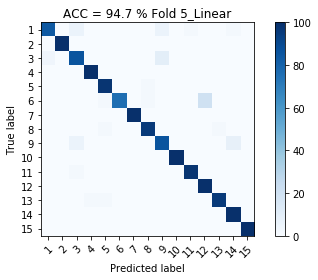

5it [00:53, 11.06s/it]

              precision    recall  f1-score   support

           1       0.95      0.84      0.89        50
           2       1.00      1.00      1.00        51
           3       0.86      0.86      0.86        50
           4       0.98      1.00      0.99        50
           5       0.94      0.98      0.96        50
           6       1.00      0.76      0.86        50
           7       1.00      1.00      1.00        51
           8       0.96      0.96      0.96        50
           9       0.84      0.86      0.85        50
          10       1.00      1.00      1.00        50
          11       0.98      0.98      0.98        50
          12       0.84      1.00      0.91        51
          13       0.98      0.96      0.97        50
          14       0.91      1.00      0.95        51
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

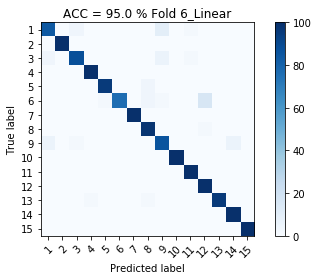

6it [01:04, 11.28s/it]

              precision    recall  f1-score   support

           1       0.90      0.84      0.87        51
           2       1.00      1.00      1.00        50
           3       0.94      0.88      0.91        51
           4       0.98      1.00      0.99        50
           5       0.98      0.96      0.97        50
           6       1.00      0.76      0.87        51
           7       1.00      1.00      1.00        50
           8       0.91      0.98      0.94        51
           9       0.83      0.86      0.84        50
          10       1.00      1.00      1.00        50
          11       0.96      1.00      0.98        50
          12       0.85      1.00      0.92        50
          13       1.00      0.96      0.98        50
          14       0.94      1.00      0.97        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

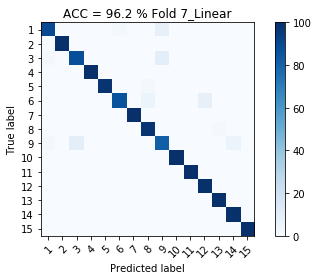

7it [01:16, 11.51s/it]

              precision    recall  f1-score   support

           1       0.96      0.90      0.93        51
           2       1.00      1.00      1.00        51
           3       0.90      0.88      0.89        50
           4       1.00      1.00      1.00        51
           5       1.00      0.98      0.99        50
           6       0.98      0.86      0.91        50
           7       1.00      1.00      1.00        51
           8       0.92      0.98      0.95        50
           9       0.82      0.82      0.82        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.93      1.00      0.96        50
          13       0.98      1.00      0.99        50
          14       0.94      1.00      0.97        50
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

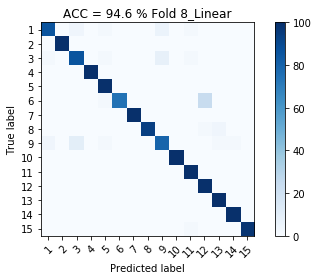

8it [01:28, 11.66s/it]

              precision    recall  f1-score   support

           1       0.93      0.86      0.90        50
           2       1.00      1.00      1.00        50
           3       0.86      0.86      0.86        50
           4       1.00      1.00      1.00        50
           5       0.93      1.00      0.96        50
           6       1.00      0.75      0.85        51
           7       1.00      1.00      1.00        50
           8       1.00      0.94      0.97        51
           9       0.85      0.80      0.82        50
          10       1.00      1.00      1.00        51
          11       0.94      1.00      0.97        50
          12       0.79      1.00      0.88        50
          13       0.94      1.00      0.97        51
          14       0.98      1.00      0.99        50
          15       1.00      0.98      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.94       754
weighted avg       0.95   

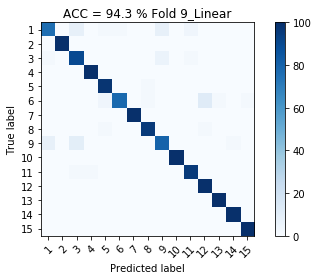

9it [01:39, 11.24s/it]

              precision    recall  f1-score   support

           1       0.88      0.76      0.82        50
           2       1.00      1.00      1.00        51
           3       0.82      0.90      0.86        50
           4       0.98      1.00      0.99        50
           5       0.92      0.98      0.95        50
           6       0.97      0.78      0.87        50
           7       1.00      1.00      1.00        50
           8       0.96      0.96      0.96        50
           9       0.85      0.80      0.83        51
          10       1.00      1.00      1.00        50
          11       0.94      0.96      0.95        50
          12       0.88      1.00      0.94        51
          13       0.98      1.00      0.99        50
          14       0.98      1.00      0.99        50
          15       0.98      1.00      0.99        51

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

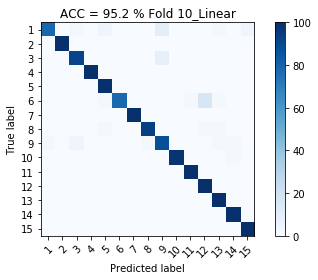

10it [01:50, 11.04s/it]
0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.98      0.78      0.87        51
           2       1.00      1.00      1.00        51
           3       0.94      0.92      0.93        50
           4       1.00      1.00      1.00        50
           5       0.93      1.00      0.96        50
           6       1.00      0.78      0.88        50
           7       1.00      1.00      1.00        50
           8       0.98      0.94      0.96        50
           9       0.83      0.88      0.85        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        51
          12       0.85      1.00      0.92        51
          13       0.93      1.00      0.96        50
          14       0.96      1.00      0.98        50
          15       0.96      1.00      0.98        50

    accuracy                           0.95       754
   macro avg       0.96      0.95      0.95       754
weighted avg       0.96   

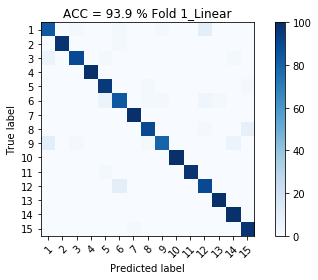

1it [00:12, 12.31s/it]

              precision    recall  f1-score   support

           1       0.84      0.84      0.84        50
           2       1.00      0.98      0.99        50
           3       0.96      0.90      0.93        50
           4       1.00      1.00      1.00        51
           5       0.91      0.96      0.93        50
           6       0.86      0.84      0.85        50
           7       0.98      1.00      0.99        51
           8       0.94      0.90      0.92        50
           9       0.95      0.80      0.87        50
          10       1.00      1.00      1.00        50
          11       1.00      0.98      0.99        51
          12       0.85      0.90      0.87        50
          13       0.98      1.00      0.99        51
          14       0.93      1.00      0.96        50
          15       0.91      0.98      0.94        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

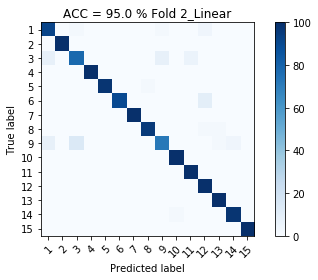

2it [00:19, 10.92s/it]

              precision    recall  f1-score   support

           1       0.85      0.92      0.88        50
           2       1.00      1.00      1.00        50
           3       0.83      0.78      0.80        50
           4       1.00      1.00      1.00        51
           5       1.00      0.98      0.99        50
           6       1.00      0.90      0.95        51
           7       1.00      1.00      1.00        50
           8       0.98      0.96      0.97        51
           9       0.88      0.72      0.79        50
          10       0.98      1.00      0.99        50
          11       0.94      1.00      0.97        50
          12       0.86      1.00      0.93        50
          13       0.96      1.00      0.98        50
          14       0.96      0.98      0.97        51
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

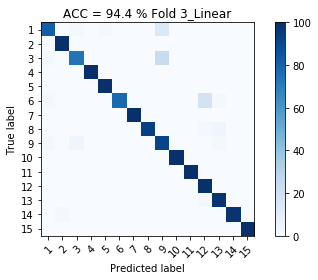

3it [00:32, 11.47s/it]

              precision    recall  f1-score   support

           1       0.93      0.82      0.87        50
           2       0.98      1.00      0.99        50
           3       0.93      0.74      0.82        50
           4       1.00      1.00      1.00        51
           5       0.98      1.00      0.99        51
           6       1.00      0.78      0.88        50
           7       1.00      1.00      1.00        51
           8       1.00      0.94      0.97        50
           9       0.71      0.92      0.80        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.82      1.00      0.90        50
          13       0.93      0.98      0.95        51
          14       1.00      0.98      0.99        50
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.95      0.94      0.94       754
weighted avg       0.95   

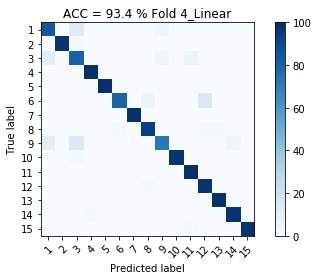

4it [00:46, 12.25s/it]

              precision    recall  f1-score   support

           1       0.81      0.84      0.82        50
           2       1.00      0.98      0.99        51
           3       0.73      0.80      0.77        51
           4       0.98      1.00      0.99        50
           5       1.00      1.00      1.00        50
           6       0.98      0.80      0.88        50
           7       1.00      1.00      1.00        51
           8       0.92      0.94      0.93        50
           9       0.90      0.72      0.80        50
          10       1.00      0.98      0.99        51
          11       0.93      1.00      0.96        50
          12       0.86      0.98      0.92        50
          13       0.98      1.00      0.99        50
          14       0.96      0.98      0.97        50
          15       1.00      0.98      0.99        50

    accuracy                           0.93       754
   macro avg       0.94      0.93      0.93       754
weighted avg       0.94   

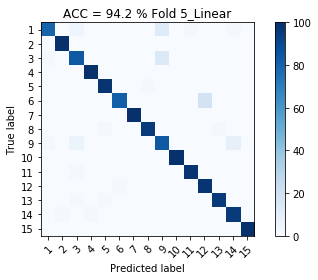

5it [01:00, 12.66s/it]

              precision    recall  f1-score   support

           1       0.95      0.80      0.87        50
           2       0.98      1.00      0.99        51
           3       0.86      0.84      0.85        50
           4       0.98      1.00      0.99        50
           5       0.96      0.98      0.97        50
           6       0.98      0.82      0.89        50
           7       1.00      1.00      1.00        51
           8       0.98      0.96      0.97        50
           9       0.76      0.84      0.80        50
          10       1.00      1.00      1.00        50
          11       0.98      0.98      0.98        50
          12       0.85      0.98      0.91        51
          13       0.98      0.96      0.97        50
          14       0.91      0.96      0.93        51
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

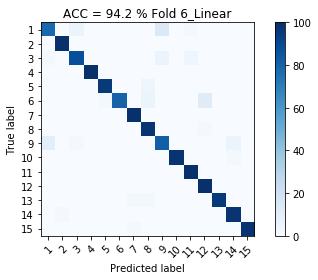

6it [01:11, 12.30s/it]

              precision    recall  f1-score   support

           1       0.87      0.78      0.82        51
           2       0.98      1.00      0.99        50
           3       0.92      0.88      0.90        51
           4       1.00      1.00      1.00        50
           5       0.98      0.96      0.97        50
           6       1.00      0.80      0.89        51
           7       0.96      1.00      0.98        50
           8       0.89      0.98      0.93        51
           9       0.80      0.82      0.81        50
          10       1.00      0.98      0.99        50
          11       0.94      1.00      0.97        50
          12       0.88      1.00      0.93        50
          13       1.00      0.96      0.98        50
          14       0.92      0.98      0.95        50
          15       1.00      0.98      0.99        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

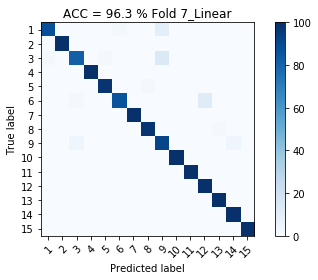

7it [01:24, 12.44s/it]

              precision    recall  f1-score   support

           1       0.98      0.88      0.93        51
           2       1.00      1.00      1.00        51
           3       0.93      0.82      0.87        50
           4       1.00      1.00      1.00        51
           5       0.98      0.98      0.98        50
           6       0.98      0.86      0.91        50
           7       1.00      1.00      1.00        51
           8       0.98      0.98      0.98        50
           9       0.79      0.92      0.85        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.89      1.00      0.94        50
          13       0.98      1.00      0.99        50
          14       0.96      1.00      0.98        50
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.97      0.96      0.96       754
weighted avg       0.97   

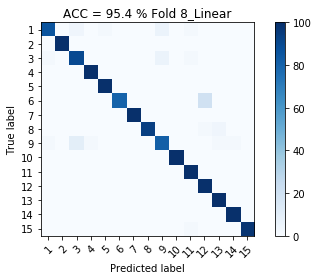

8it [01:38, 12.76s/it]

              precision    recall  f1-score   support

           1       0.96      0.86      0.91        50
           2       1.00      1.00      1.00        50
           3       0.87      0.90      0.88        50
           4       0.98      1.00      0.99        50
           5       0.98      1.00      0.99        50
           6       1.00      0.80      0.89        51
           7       1.00      1.00      1.00        50
           8       1.00      0.94      0.97        51
           9       0.87      0.82      0.85        50
          10       1.00      1.00      1.00        51
          11       0.94      1.00      0.97        50
          12       0.82      1.00      0.90        50
          13       0.94      1.00      0.97        51
          14       0.98      1.00      0.99        50
          15       1.00      0.98      0.99        50

    accuracy                           0.95       754
   macro avg       0.96      0.95      0.95       754
weighted avg       0.96   

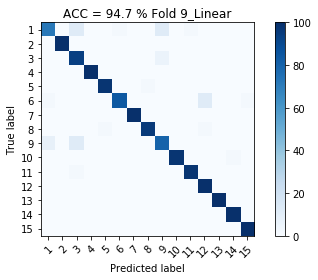

9it [01:52, 13.13s/it]

              precision    recall  f1-score   support

           1       0.88      0.72      0.79        50
           2       1.00      1.00      1.00        51
           3       0.78      0.94      0.85        50
           4       1.00      1.00      1.00        50
           5       0.98      0.98      0.98        50
           6       0.98      0.84      0.90        50
           7       1.00      1.00      1.00        50
           8       0.98      0.96      0.97        50
           9       0.82      0.80      0.81        51
          10       1.00      0.98      0.99        50
          11       0.98      0.98      0.98        50
          12       0.88      1.00      0.94        51
          13       1.00      1.00      1.00        50
          14       0.98      1.00      0.99        50
          15       0.98      1.00      0.99        51

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

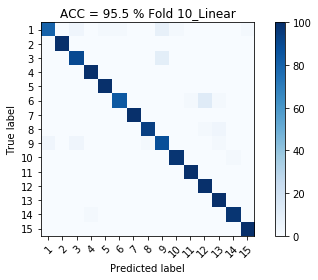

10it [02:04, 12.45s/it]
0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.95      0.80      0.87        51
           2       1.00      1.00      1.00        51
           3       0.92      0.90      0.91        50
           4       0.98      1.00      0.99        50
           5       0.98      1.00      0.99        50
           6       0.98      0.84      0.90        50
           7       1.00      1.00      1.00        50
           8       0.98      0.94      0.96        50
           9       0.83      0.88      0.85        50
          10       0.98      0.98      0.98        50
          11       0.98      1.00      0.99        51
          12       0.88      1.00      0.94        51
          13       0.93      1.00      0.96        50
          14       0.98      0.98      0.98        50
          15       0.98      1.00      0.99        50

    accuracy                           0.95       754
   macro avg       0.96      0.95      0.95       754
weighted avg       0.96   

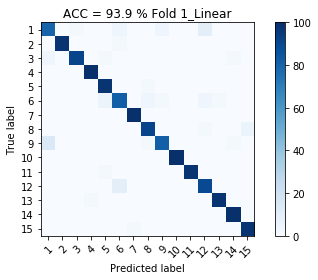

1it [00:17, 17.24s/it]

              precision    recall  f1-score   support

           1       0.82      0.80      0.81        50
           2       1.00      0.98      0.99        50
           3       0.98      0.92      0.95        50
           4       0.98      1.00      0.99        51
           5       0.91      0.98      0.94        50
           6       0.84      0.82      0.83        50
           7       0.98      1.00      0.99        51
           8       0.92      0.92      0.92        50
           9       0.93      0.82      0.87        50
          10       1.00      1.00      1.00        50
          11       1.00      0.98      0.99        51
          12       0.85      0.90      0.87        50
          13       0.98      0.98      0.98        51
          14       0.96      1.00      0.98        50
          15       0.94      0.98      0.96        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

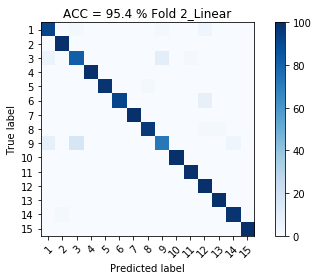

2it [00:32, 16.73s/it]

              precision    recall  f1-score   support

           1       0.87      0.92      0.89        50
           2       0.98      1.00      0.99        50
           3       0.82      0.82      0.82        50
           4       1.00      1.00      1.00        51
           5       1.00      0.98      0.99        50
           6       1.00      0.92      0.96        51
           7       1.00      1.00      1.00        50
           8       0.98      0.96      0.97        51
           9       0.86      0.72      0.78        50
          10       1.00      1.00      1.00        50
          11       0.98      1.00      0.99        50
          12       0.88      1.00      0.93        50
          13       0.98      1.00      0.99        50
          14       0.96      0.98      0.97        51
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

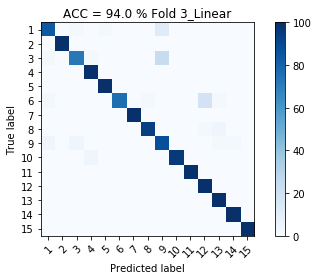

3it [00:47, 16.25s/it]

              precision    recall  f1-score   support

           1       0.91      0.84      0.87        50
           2       1.00      1.00      1.00        50
           3       0.92      0.72      0.81        50
           4       0.94      1.00      0.97        51
           5       0.98      1.00      0.99        51
           6       1.00      0.76      0.86        50
           7       1.00      1.00      1.00        51
           8       0.98      0.94      0.96        50
           9       0.71      0.88      0.79        50
          10       1.00      0.96      0.98        50
          11       1.00      1.00      1.00        50
          12       0.83      1.00      0.91        50
          13       0.93      1.00      0.96        51
          14       0.98      1.00      0.99        50
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.95      0.94      0.94       754
weighted avg       0.95   

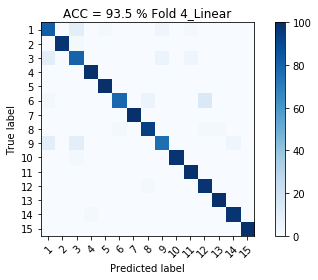

4it [01:02, 15.76s/it]

              precision    recall  f1-score   support

           1       0.79      0.82      0.80        50
           2       1.00      0.98      0.99        51
           3       0.77      0.80      0.79        51
           4       0.98      1.00      0.99        50
           5       0.98      1.00      0.99        50
           6       0.97      0.78      0.87        50
           7       1.00      1.00      1.00        51
           8       0.92      0.94      0.93        50
           9       0.88      0.76      0.82        50
          10       1.00      0.98      0.99        51
          11       0.94      1.00      0.97        50
          12       0.86      0.98      0.92        50
          13       0.98      1.00      0.99        50
          14       0.96      0.98      0.97        50
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.94      0.93      0.93       754
weighted avg       0.94   

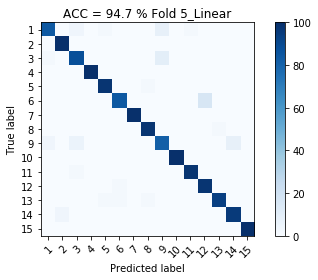

5it [01:17, 15.54s/it]

              precision    recall  f1-score   support

           1       0.93      0.84      0.88        50
           2       0.96      1.00      0.98        51
           3       0.88      0.88      0.88        50
           4       1.00      1.00      1.00        50
           5       0.96      0.98      0.97        50
           6       0.95      0.84      0.89        50
           7       1.00      1.00      1.00        51
           8       0.96      0.98      0.97        50
           9       0.82      0.82      0.82        50
          10       1.00      1.00      1.00        50
          11       0.98      0.98      0.98        50
          12       0.86      0.98      0.92        51
          13       0.98      0.94      0.96        50
          14       0.92      0.96      0.94        51
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

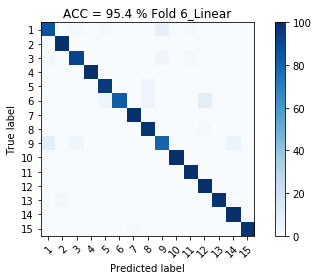

6it [01:33, 15.79s/it]

              precision    recall  f1-score   support

           1       0.88      0.86      0.87        51
           2       0.98      1.00      0.99        50
           3       0.94      0.92      0.93        51
           4       1.00      1.00      1.00        50
           5       0.94      0.96      0.95        50
           6       1.00      0.82      0.90        51
           7       0.98      1.00      0.99        50
           8       0.93      0.98      0.95        51
           9       0.87      0.80      0.83        50
          10       1.00      1.00      1.00        50
          11       0.96      1.00      0.98        50
          12       0.89      1.00      0.94        50
          13       1.00      0.98      0.99        50
          14       0.94      1.00      0.97        50
          15       1.00      0.98      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

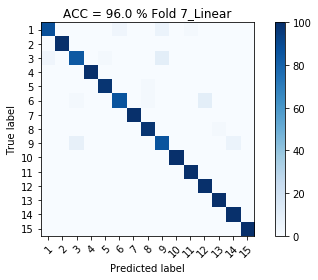

7it [01:49, 15.62s/it]

              precision    recall  f1-score   support

           1       0.96      0.88      0.92        51
           2       1.00      1.00      1.00        51
           3       0.89      0.84      0.87        50
           4       1.00      1.00      1.00        51
           5       0.98      0.98      0.98        50
           6       0.96      0.86      0.91        50
           7       1.00      1.00      1.00        51
           8       0.96      0.98      0.97        50
           9       0.84      0.86      0.85        50
          10       1.00      1.00      1.00        50
          11       0.98      1.00      0.99        50
          12       0.91      1.00      0.95        50
          13       0.98      1.00      0.99        50
          14       0.94      1.00      0.97        50
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

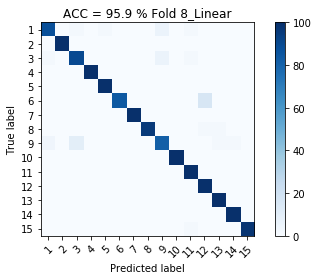

8it [02:04, 15.68s/it]

              precision    recall  f1-score   support

           1       0.94      0.88      0.91        50
           2       1.00      1.00      1.00        50
           3       0.88      0.90      0.89        50
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        50
           6       1.00      0.84      0.91        51
           7       1.00      1.00      1.00        50
           8       1.00      0.96      0.98        51
           9       0.87      0.82      0.85        50
          10       1.00      1.00      1.00        51
          11       0.94      1.00      0.97        50
          12       0.85      1.00      0.92        50
          13       0.96      1.00      0.98        51
          14       0.98      1.00      0.99        50
          15       1.00      0.98      0.99        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

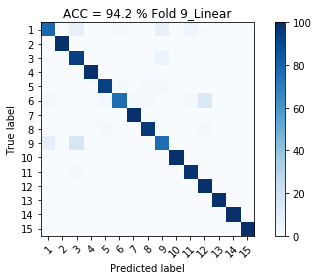

9it [02:19, 15.43s/it]

              precision    recall  f1-score   support

           1       0.89      0.78      0.83        50
           2       1.00      1.00      1.00        51
           3       0.78      0.94      0.85        50
           4       1.00      1.00      1.00        50
           5       0.96      0.94      0.95        50
           6       0.95      0.76      0.84        50
           7       0.98      1.00      0.99        50
           8       0.96      0.96      0.96        50
           9       0.83      0.76      0.80        51
          10       1.00      1.00      1.00        50
          11       0.94      0.98      0.96        50
          12       0.86      1.00      0.93        51
          13       1.00      1.00      1.00        50
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        51

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

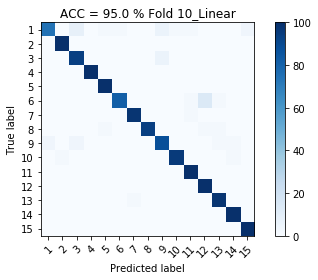

10it [02:36, 15.64s/it]
0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.95      0.75      0.84        51
           2       0.98      1.00      0.99        51
           3       0.89      0.94      0.91        50
           4       1.00      1.00      1.00        50
           5       0.96      1.00      0.98        50
           6       0.98      0.82      0.89        50
           7       0.98      0.98      0.98        50
           8       1.00      0.94      0.97        50
           9       0.88      0.88      0.88        50
          10       0.98      0.96      0.97        50
          11       0.94      1.00      0.97        51
          12       0.86      1.00      0.93        51
          13       0.94      0.98      0.96        50
          14       0.96      1.00      0.98        50
          15       0.96      1.00      0.98        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

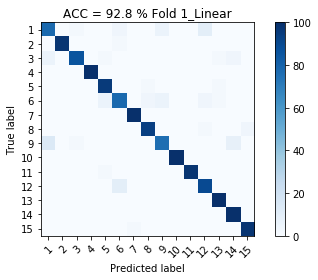

1it [00:11, 11.14s/it]

              precision    recall  f1-score   support

           1       0.80      0.78      0.79        50
           2       1.00      0.98      0.99        50
           3       0.96      0.86      0.91        50
           4       1.00      1.00      1.00        51
           5       0.91      0.96      0.93        50
           6       0.83      0.78      0.80        50
           7       0.98      1.00      0.99        51
           8       0.94      0.94      0.94        50
           9       0.86      0.76      0.81        50
          10       1.00      1.00      1.00        50
          11       1.00      0.98      0.99        51
          12       0.85      0.90      0.87        50
          13       0.94      1.00      0.97        51
          14       0.89      1.00      0.94        50
          15       0.96      0.98      0.97        50

    accuracy                           0.93       754
   macro avg       0.93      0.93      0.93       754
weighted avg       0.93   

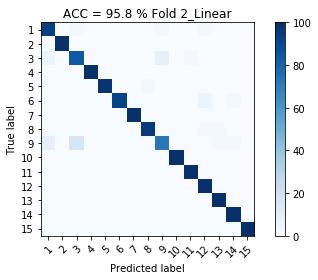

2it [00:28, 12.92s/it]

              precision    recall  f1-score   support

           1       0.87      0.94      0.90        50
           2       1.00      1.00      1.00        50
           3       0.82      0.84      0.83        50
           4       1.00      1.00      1.00        51
           5       1.00      0.98      0.99        50
           6       1.00      0.92      0.96        51
           7       1.00      1.00      1.00        50
           8       0.98      0.96      0.97        51
           9       0.88      0.72      0.79        50
          10       1.00      1.00      1.00        50
          11       0.98      1.00      0.99        50
          12       0.91      1.00      0.95        50
          13       0.96      1.00      0.98        50
          14       0.96      1.00      0.98        51
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

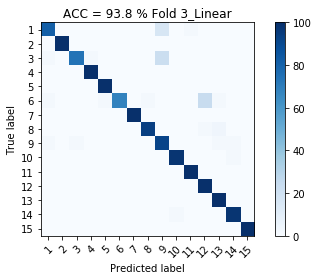

3it [00:46, 14.64s/it]

              precision    recall  f1-score   support

           1       0.93      0.82      0.87        50
           2       1.00      1.00      1.00        50
           3       0.97      0.74      0.84        50
           4       0.98      1.00      0.99        51
           5       0.98      1.00      0.99        51
           6       1.00      0.68      0.81        50
           7       1.00      1.00      1.00        51
           8       0.98      0.94      0.96        50
           9       0.71      0.92      0.80        50
          10       0.98      0.98      0.98        50
          11       0.98      1.00      0.99        50
          12       0.79      1.00      0.88        50
          13       0.93      1.00      0.96        51
          14       0.96      0.98      0.97        50
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.95      0.94      0.94       754
weighted avg       0.95   

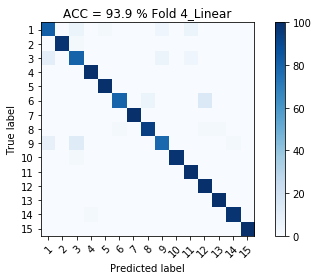

4it [01:05, 15.93s/it]

              precision    recall  f1-score   support

           1       0.82      0.82      0.82        50
           2       1.00      0.98      0.99        51
           3       0.79      0.80      0.80        51
           4       0.98      1.00      0.99        50
           5       0.98      1.00      0.99        50
           6       0.98      0.80      0.88        50
           7       1.00      1.00      1.00        51
           8       0.94      0.94      0.94        50
           9       0.89      0.78      0.83        50
          10       1.00      0.98      0.99        51
          11       0.91      1.00      0.95        50
          12       0.86      1.00      0.93        50
          13       0.98      1.00      0.99        50
          14       0.98      0.98      0.98        50
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

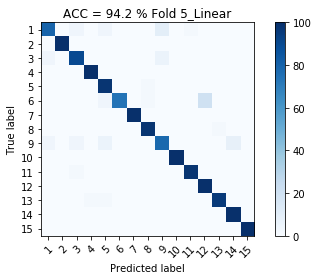

5it [01:18, 14.97s/it]

              precision    recall  f1-score   support

           1       0.91      0.80      0.85        50
           2       1.00      1.00      1.00        51
           3       0.90      0.90      0.90        50
           4       0.98      1.00      0.99        50
           5       0.86      0.98      0.92        50
           6       1.00      0.74      0.85        50
           7       1.00      1.00      1.00        51
           8       0.96      0.98      0.97        50
           9       0.83      0.78      0.80        50
          10       1.00      1.00      1.00        50
          11       0.98      0.98      0.98        50
          12       0.84      1.00      0.91        51
          13       0.98      0.96      0.97        50
          14       0.93      1.00      0.96        51
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

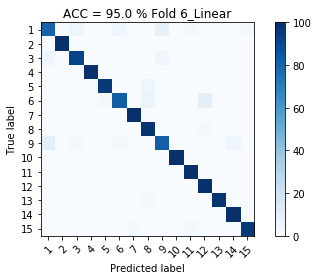

6it [01:29, 13.82s/it]

              precision    recall  f1-score   support

           1       0.85      0.80      0.83        51
           2       1.00      1.00      1.00        50
           3       0.94      0.92      0.93        51
           4       1.00      1.00      1.00        50
           5       0.98      0.96      0.97        50
           6       0.93      0.82      0.87        51
           7       0.98      1.00      0.99        50
           8       0.89      0.98      0.93        51
           9       0.87      0.82      0.85        50
          10       1.00      1.00      1.00        50
          11       0.96      1.00      0.98        50
          12       0.89      1.00      0.94        50
          13       1.00      0.98      0.99        50
          14       0.96      1.00      0.98        50
          15       0.98      0.96      0.97        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

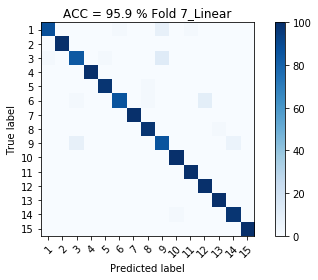

7it [01:49, 15.60s/it]

              precision    recall  f1-score   support

           1       0.98      0.88      0.93        51
           2       1.00      1.00      1.00        51
           3       0.89      0.84      0.87        50
           4       1.00      1.00      1.00        51
           5       0.98      0.98      0.98        50
           6       0.98      0.86      0.91        50
           7       1.00      1.00      1.00        51
           8       0.96      0.98      0.97        50
           9       0.81      0.86      0.83        50
          10       0.98      1.00      0.99        50
          11       0.98      1.00      0.99        50
          12       0.91      1.00      0.95        50
          13       0.98      1.00      0.99        50
          14       0.94      0.98      0.96        50
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

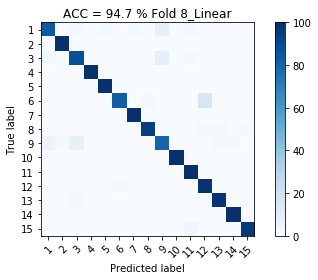

8it [02:08, 16.77s/it]

              precision    recall  f1-score   support

           1       0.91      0.84      0.87        50
           2       0.98      1.00      0.99        50
           3       0.88      0.88      0.88        50
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        50
           6       0.98      0.82      0.89        51
           7       0.98      1.00      0.99        50
           8       0.98      0.94      0.96        51
           9       0.83      0.80      0.82        50
          10       1.00      1.00      1.00        51
          11       0.93      1.00      0.96        50
          12       0.84      0.98      0.91        50
          13       0.96      0.98      0.97        51
          14       0.98      1.00      0.99        50
          15       0.98      0.96      0.97        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

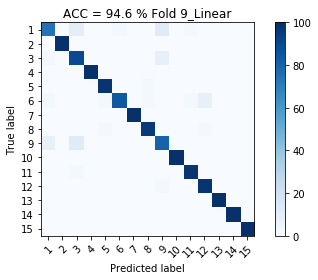

9it [02:26, 17.15s/it]

              precision    recall  f1-score   support

           1       0.86      0.74      0.80        50
           2       1.00      1.00      1.00        51
           3       0.79      0.90      0.84        50
           4       1.00      1.00      1.00        50
           5       0.96      0.98      0.97        50
           6       0.98      0.84      0.90        50
           7       1.00      1.00      1.00        50
           8       0.96      0.96      0.96        50
           9       0.79      0.80      0.80        51
          10       1.00      1.00      1.00        50
          11       0.96      0.98      0.97        50
          12       0.91      0.98      0.94        51
          13       1.00      1.00      1.00        50
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        51

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

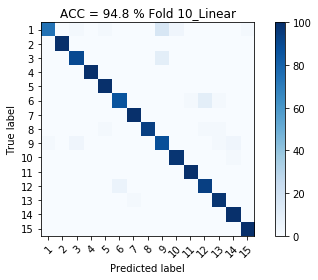

10it [02:45, 16.55s/it]
0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.97      0.75      0.84        51
           2       1.00      1.00      1.00        51
           3       0.94      0.90      0.92        50
           4       1.00      1.00      1.00        50
           5       0.96      1.00      0.98        50
           6       0.93      0.86      0.90        50
           7       0.98      1.00      0.99        50
           8       1.00      0.94      0.97        50
           9       0.77      0.88      0.82        50
          10       0.96      0.98      0.97        50
          11       0.98      1.00      0.99        51
          12       0.89      0.94      0.91        51
          13       0.94      0.98      0.96        50
          14       0.94      1.00      0.97        50
          15       0.98      1.00      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

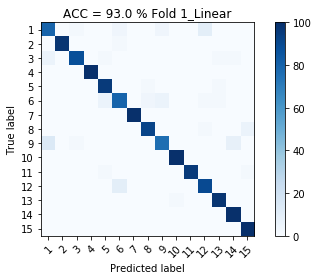

1it [00:26, 26.02s/it]

              precision    recall  f1-score   support

           1       0.80      0.80      0.80        50
           2       1.00      0.98      0.99        50
           3       0.96      0.88      0.92        50
           4       1.00      1.00      1.00        51
           5       0.91      0.96      0.93        50
           6       0.83      0.80      0.82        50
           7       1.00      1.00      1.00        51
           8       0.94      0.92      0.93        50
           9       0.88      0.76      0.82        50
          10       0.98      1.00      0.99        50
          11       1.00      0.96      0.98        51
          12       0.87      0.90      0.88        50
          13       0.94      0.98      0.96        51
          14       0.91      1.00      0.95        50
          15       0.93      1.00      0.96        50

    accuracy                           0.93       754
   macro avg       0.93      0.93      0.93       754
weighted avg       0.93   

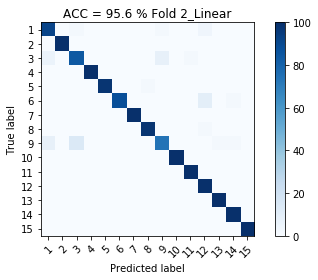

2it [00:46, 24.23s/it]

              precision    recall  f1-score   support

           1       0.87      0.92      0.89        50
           2       1.00      1.00      1.00        50
           3       0.84      0.84      0.84        50
           4       1.00      1.00      1.00        51
           5       1.00      0.98      0.99        50
           6       1.00      0.88      0.94        51
           7       1.00      1.00      1.00        50
           8       0.98      0.98      0.98        51
           9       0.88      0.74      0.80        50
          10       1.00      1.00      1.00        50
          11       0.98      1.00      0.99        50
          12       0.86      1.00      0.93        50
          13       0.98      1.00      0.99        50
          14       0.96      1.00      0.98        51
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

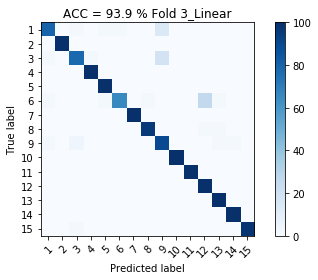

3it [00:59, 20.86s/it]

              precision    recall  f1-score   support

           1       0.93      0.80      0.86        50
           2       1.00      1.00      1.00        50
           3       0.91      0.78      0.84        50
           4       0.98      1.00      0.99        51
           5       0.96      1.00      0.98        51
           6       0.97      0.66      0.79        50
           7       1.00      1.00      1.00        51
           8       0.98      0.96      0.97        50
           9       0.74      0.90      0.81        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.78      1.00      0.88        50
          13       0.94      1.00      0.97        51
          14       0.98      1.00      0.99        50
          15       1.00      0.98      0.99        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.95   

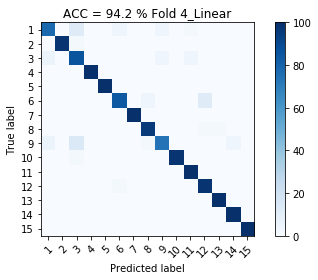

4it [01:21, 21.26s/it]

              precision    recall  f1-score   support

           1       0.87      0.78      0.82        50
           2       1.00      0.98      0.99        51
           3       0.75      0.86      0.80        51
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        50
           6       0.93      0.84      0.88        50
           7       1.00      1.00      1.00        51
           8       0.94      0.96      0.95        50
           9       0.90      0.74      0.81        50
          10       1.00      0.98      0.99        51
          11       0.94      1.00      0.97        50
          12       0.88      0.98      0.92        50
          13       0.98      1.00      0.99        50
          14       0.96      1.00      0.98        50
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

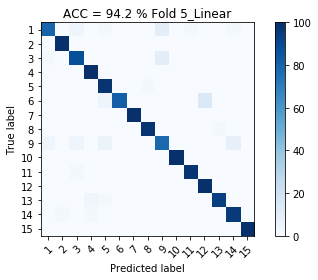

5it [01:41, 21.10s/it]

              precision    recall  f1-score   support

           1       0.93      0.80      0.86        50
           2       0.98      1.00      0.99        51
           3       0.90      0.88      0.89        50
           4       0.94      1.00      0.97        50
           5       0.88      0.98      0.92        50
           6       1.00      0.82      0.90        50
           7       1.00      1.00      1.00        51
           8       0.98      0.98      0.98        50
           9       0.80      0.78      0.79        50
          10       1.00      1.00      1.00        50
          11       0.98      0.98      0.98        50
          12       0.88      1.00      0.94        51
          13       0.98      0.94      0.96        50
          14       0.91      0.96      0.93        51
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

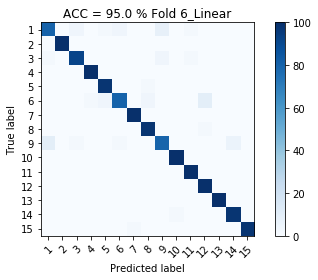

6it [02:01, 20.69s/it]

              precision    recall  f1-score   support

           1       0.87      0.80      0.84        51
           2       1.00      1.00      1.00        50
           3       0.94      0.92      0.93        51
           4       0.98      1.00      0.99        50
           5       0.94      0.98      0.96        50
           6       0.93      0.80      0.86        51
           7       0.98      1.00      0.99        50
           8       0.94      0.98      0.96        51
           9       0.87      0.80      0.83        50
          10       0.98      1.00      0.99        50
          11       0.96      1.00      0.98        50
          12       0.89      1.00      0.94        50
          13       1.00      1.00      1.00        50
          14       0.94      0.98      0.96        50
          15       1.00      0.98      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

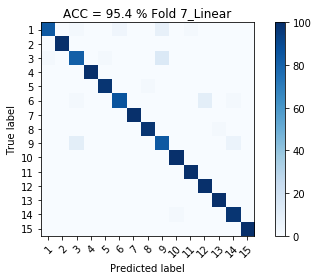

7it [02:22, 20.83s/it]

              precision    recall  f1-score   support

           1       0.98      0.84      0.91        51
           2       1.00      1.00      1.00        51
           3       0.85      0.82      0.84        50
           4       1.00      1.00      1.00        51
           5       0.98      0.98      0.98        50
           6       0.96      0.86      0.91        50
           7       1.00      1.00      1.00        51
           8       0.98      0.98      0.98        50
           9       0.79      0.84      0.82        50
          10       0.98      1.00      0.99        50
          11       0.98      1.00      0.99        50
          12       0.91      1.00      0.95        50
          13       0.98      1.00      0.99        50
          14       0.92      0.98      0.95        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

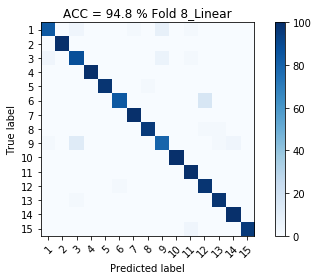

8it [02:44, 21.05s/it]

              precision    recall  f1-score   support

           1       0.93      0.84      0.88        50
           2       1.00      1.00      1.00        50
           3       0.83      0.88      0.85        50
           4       1.00      1.00      1.00        50
           5       1.00      0.98      0.99        50
           6       0.98      0.84      0.91        51
           7       0.98      1.00      0.99        50
           8       0.98      0.96      0.97        51
           9       0.85      0.80      0.82        50
          10       1.00      1.00      1.00        51
          11       0.93      1.00      0.96        50
          12       0.84      0.98      0.91        50
          13       0.96      0.98      0.97        51
          14       0.96      1.00      0.98        50
          15       1.00      0.96      0.98        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

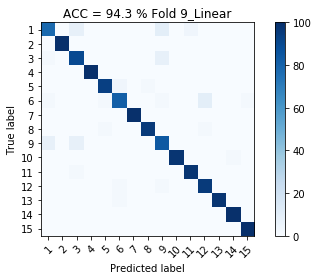

9it [03:07, 21.52s/it]

              precision    recall  f1-score   support

           1       0.87      0.78      0.82        50
           2       1.00      1.00      1.00        51
           3       0.83      0.90      0.87        50
           4       1.00      1.00      1.00        50
           5       0.96      0.94      0.95        50
           6       0.91      0.82      0.86        50
           7       1.00      1.00      1.00        50
           8       0.98      0.96      0.97        50
           9       0.80      0.84      0.82        51
          10       1.00      0.98      0.99        50
          11       0.96      0.98      0.97        50
          12       0.89      0.96      0.92        51
          13       1.00      0.98      0.99        50
          14       0.98      1.00      0.99        50
          15       0.98      1.00      0.99        51

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

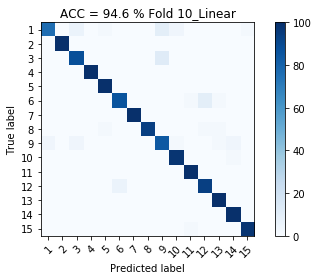

10it [03:31, 21.16s/it]
0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.95      0.76      0.85        51
           2       1.00      1.00      1.00        51
           3       0.90      0.88      0.89        50
           4       1.00      1.00      1.00        50
           5       0.96      1.00      0.98        50
           6       0.93      0.86      0.90        50
           7       1.00      1.00      1.00        50
           8       1.00      0.94      0.97        50
           9       0.79      0.84      0.82        50
          10       0.94      0.98      0.96        50
          11       0.96      1.00      0.98        51
          12       0.89      0.94      0.91        51
          13       0.94      1.00      0.97        50
          14       0.94      1.00      0.97        50
          15       0.98      0.98      0.98        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

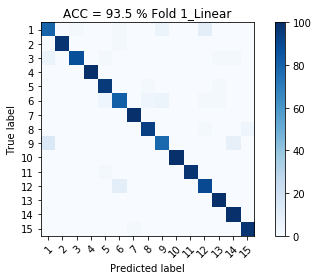

1it [00:24, 24.65s/it]

              precision    recall  f1-score   support

           1       0.80      0.80      0.80        50
           2       1.00      0.98      0.99        50
           3       0.98      0.88      0.93        50
           4       1.00      1.00      1.00        51
           5       0.92      0.96      0.94        50
           6       0.85      0.82      0.84        50
           7       0.98      1.00      0.99        51
           8       0.94      0.94      0.94        50
           9       0.87      0.78      0.82        50
          10       1.00      1.00      1.00        50
          11       1.00      0.98      0.99        51
          12       0.87      0.90      0.88        50
          13       0.94      1.00      0.97        51
          14       0.91      1.00      0.95        50
          15       0.96      0.98      0.97        50

    accuracy                           0.94       754
   macro avg       0.93      0.93      0.93       754
weighted avg       0.94   

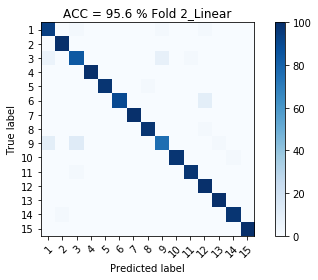

2it [00:48, 24.42s/it]

              precision    recall  f1-score   support

           1       0.85      0.94      0.90        50
           2       0.98      1.00      0.99        50
           3       0.84      0.84      0.84        50
           4       1.00      1.00      1.00        51
           5       1.00      0.98      0.99        50
           6       1.00      0.90      0.95        51
           7       1.00      1.00      1.00        50
           8       0.98      0.98      0.98        51
           9       0.88      0.76      0.82        50
          10       1.00      0.98      0.99        50
          11       0.98      0.98      0.98        50
          12       0.88      1.00      0.93        50
          13       0.98      1.00      0.99        50
          14       0.98      0.98      0.98        51
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

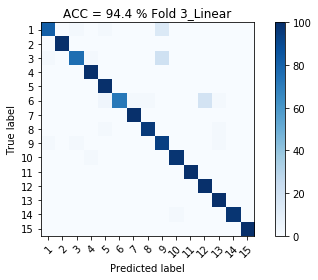

3it [01:16, 25.44s/it]

              precision    recall  f1-score   support

           1       0.95      0.82      0.88        50
           2       1.00      1.00      1.00        50
           3       0.95      0.76      0.84        50
           4       0.96      1.00      0.98        51
           5       0.93      1.00      0.96        51
           6       1.00      0.72      0.84        50
           7       0.98      1.00      0.99        51
           8       0.98      0.96      0.97        50
           9       0.73      0.94      0.82        50
          10       0.98      0.98      0.98        50
          11       1.00      1.00      1.00        50
          12       0.85      1.00      0.92        50
          13       0.94      1.00      0.97        51
          14       1.00      0.98      0.99        50
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.95      0.94      0.94       754
weighted avg       0.95   

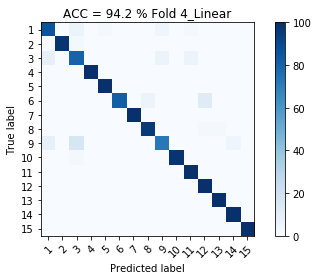

4it [01:41, 25.32s/it]

              precision    recall  f1-score   support

           1       0.84      0.86      0.85        50
           2       1.00      0.98      0.99        51
           3       0.76      0.80      0.78        51
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        50
           6       1.00      0.82      0.90        50
           7       1.00      1.00      1.00        51
           8       0.94      0.96      0.95        50
           9       0.88      0.72      0.79        50
          10       1.00      0.98      0.99        51
          11       0.93      1.00      0.96        50
          12       0.88      1.00      0.93        50
          13       0.98      1.00      0.99        50
          14       0.96      1.00      0.98        50
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

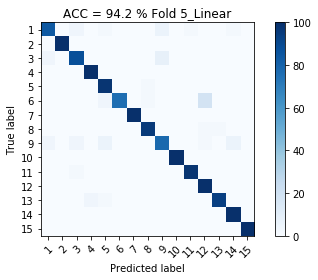

5it [02:15, 27.80s/it]

              precision    recall  f1-score   support

           1       0.91      0.84      0.87        50
           2       1.00      1.00      1.00        51
           3       0.90      0.88      0.89        50
           4       0.96      1.00      0.98        50
           5       0.88      0.98      0.92        50
           6       1.00      0.76      0.86        50
           7       1.00      1.00      1.00        51
           8       0.96      0.96      0.96        50
           9       0.85      0.78      0.81        50
          10       1.00      1.00      1.00        50
          11       0.98      0.98      0.98        50
          12       0.82      1.00      0.90        51
          13       0.98      0.94      0.96        50
          14       0.93      1.00      0.96        51
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

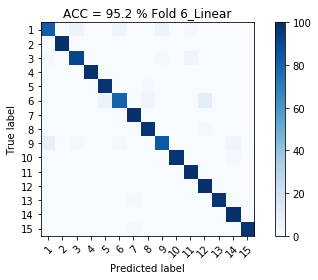

6it [02:39, 26.82s/it]

              precision    recall  f1-score   support

           1       0.89      0.82      0.86        51
           2       1.00      1.00      1.00        50
           3       0.92      0.92      0.92        51
           4       1.00      1.00      1.00        50
           5       0.94      0.98      0.96        50
           6       0.93      0.80      0.86        51
           7       0.96      1.00      0.98        50
           8       0.94      0.98      0.96        51
           9       0.91      0.84      0.87        50
          10       1.00      0.98      0.99        50
          11       0.94      1.00      0.97        50
          12       0.89      1.00      0.94        50
          13       1.00      0.98      0.99        50
          14       0.94      1.00      0.97        50
          15       1.00      0.98      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

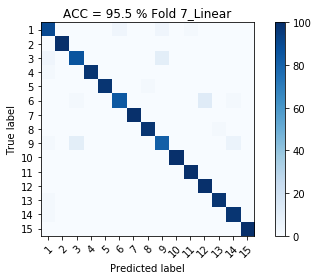

7it [03:02, 25.53s/it]

              precision    recall  f1-score   support

           1       0.88      0.90      0.89        51
           2       1.00      1.00      1.00        51
           3       0.88      0.86      0.87        50
           4       1.00      0.98      0.99        51
           5       1.00      0.98      0.99        50
           6       0.95      0.84      0.89        50
           7       1.00      1.00      1.00        51
           8       0.98      0.98      0.98        50
           9       0.85      0.82      0.84        50
          10       1.00      1.00      1.00        50
          11       0.98      1.00      0.99        50
          12       0.89      1.00      0.94        50
          13       0.98      0.98      0.98        50
          14       0.92      0.98      0.95        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.96      0.95      0.95       754
weighted avg       0.96   

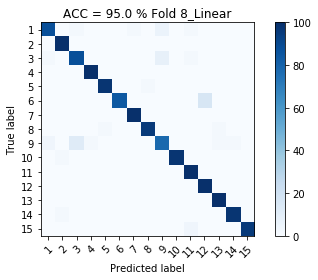

8it [03:27, 25.49s/it]

              precision    recall  f1-score   support

           1       0.94      0.88      0.91        50
           2       0.96      1.00      0.98        50
           3       0.86      0.88      0.87        50
           4       0.98      1.00      0.99        50
           5       0.98      0.98      0.98        50
           6       1.00      0.84      0.91        51
           7       0.98      1.00      0.99        50
           8       0.98      0.96      0.97        51
           9       0.85      0.78      0.81        50
          10       1.00      0.98      0.99        51
          11       0.93      1.00      0.96        50
          12       0.86      1.00      0.93        50
          13       0.96      1.00      0.98        51
          14       0.98      0.98      0.98        50
          15       1.00      0.96      0.98        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

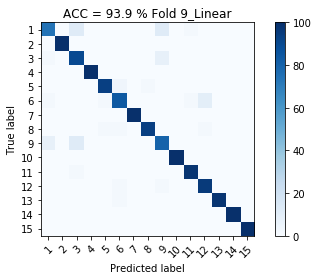

9it [03:50, 24.78s/it]

              precision    recall  f1-score   support

           1       0.86      0.74      0.80        50
           2       1.00      1.00      1.00        51
           3       0.78      0.90      0.83        50
           4       1.00      1.00      1.00        50
           5       0.96      0.94      0.95        50
           6       0.89      0.84      0.87        50
           7       1.00      1.00      1.00        50
           8       0.98      0.94      0.96        50
           9       0.79      0.80      0.80        51
          10       1.00      1.00      1.00        50
          11       0.96      0.98      0.97        50
          12       0.89      0.96      0.92        51
          13       1.00      0.98      0.99        50
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        51

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

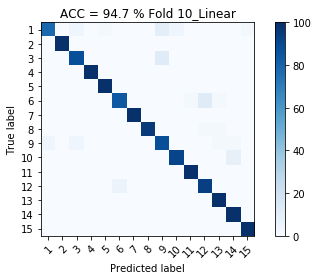

10it [04:13, 25.30s/it]
0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.95      0.78      0.86        51
           2       1.00      1.00      1.00        51
           3       0.92      0.88      0.90        50
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        50
           6       0.93      0.84      0.88        50
           7       1.00      1.00      1.00        50
           8       1.00      0.96      0.98        50
           9       0.80      0.88      0.84        50
          10       0.96      0.92      0.94        50
          11       0.98      1.00      0.99        51
          12       0.87      0.94      0.91        51
          13       0.94      1.00      0.97        50
          14       0.91      1.00      0.95        50
          15       0.98      1.00      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

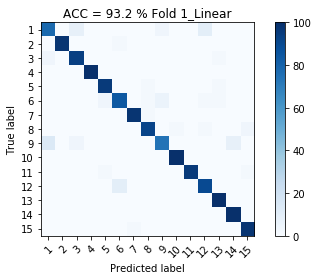

1it [00:26, 26.20s/it]

              precision    recall  f1-score   support

           1       0.81      0.78      0.80        50
           2       1.00      0.98      0.99        50
           3       0.89      0.94      0.91        50
           4       1.00      1.00      1.00        51
           5       0.94      0.96      0.95        50
           6       0.88      0.84      0.86        50
           7       0.98      0.98      0.98        51
           8       0.94      0.92      0.93        50
           9       0.88      0.74      0.80        50
          10       0.98      1.00      0.99        50
          11       1.00      0.96      0.98        51
          12       0.87      0.90      0.88        50
          13       0.94      1.00      0.97        51
          14       0.93      1.00      0.96        50
          15       0.94      0.98      0.96        50

    accuracy                           0.93       754
   macro avg       0.93      0.93      0.93       754
weighted avg       0.93   

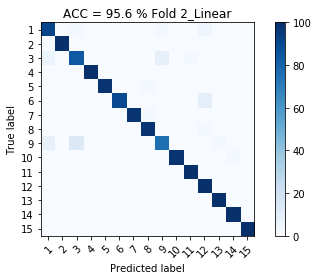

2it [00:58, 28.06s/it]

              precision    recall  f1-score   support

           1       0.87      0.92      0.89        50
           2       1.00      1.00      1.00        50
           3       0.84      0.84      0.84        50
           4       1.00      1.00      1.00        51
           5       1.00      0.98      0.99        50
           6       1.00      0.90      0.95        51
           7       1.00      0.98      0.99        50
           8       0.96      0.98      0.97        51
           9       0.88      0.76      0.82        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.86      1.00      0.93        50
          13       0.98      1.00      0.99        50
          14       0.98      1.00      0.99        51
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

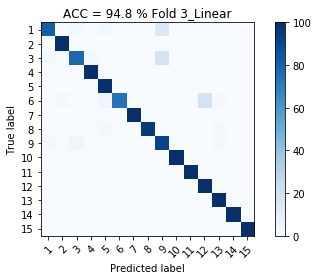

3it [01:27, 28.26s/it]

              precision    recall  f1-score   support

           1       0.95      0.82      0.88        50
           2       0.98      1.00      0.99        50
           3       0.93      0.78      0.85        50
           4       0.98      1.00      0.99        51
           5       0.93      1.00      0.96        51
           6       1.00      0.74      0.85        50
           7       1.00      1.00      1.00        51
           8       1.00      0.96      0.98        50
           9       0.74      0.92      0.82        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.85      1.00      0.92        50
          13       0.94      1.00      0.97        51
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

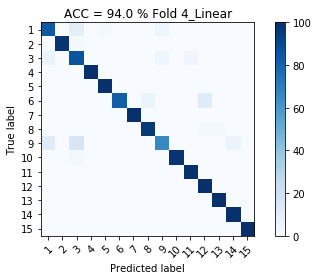

4it [01:55, 28.13s/it]

              precision    recall  f1-score   support

           1       0.82      0.84      0.83        50
           2       1.00      0.98      0.99        51
           3       0.75      0.86      0.80        51
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        50
           6       1.00      0.82      0.90        50
           7       1.00      1.00      1.00        51
           8       0.94      0.96      0.95        50
           9       0.89      0.66      0.76        50
          10       1.00      0.98      0.99        51
          11       0.96      1.00      0.98        50
          12       0.88      1.00      0.93        50
          13       0.98      1.00      0.99        50
          14       0.94      1.00      0.97        50
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

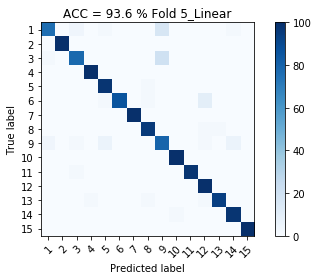

5it [02:10, 24.44s/it]

              precision    recall  f1-score   support

           1       0.93      0.76      0.84        50
           2       1.00      1.00      1.00        51
           3       0.91      0.78      0.84        50
           4       0.98      1.00      0.99        50
           5       0.91      0.98      0.94        50
           6       1.00      0.86      0.92        50
           7       1.00      1.00      1.00        51
           8       0.94      0.96      0.95        50
           9       0.69      0.80      0.74        50
          10       0.98      1.00      0.99        50
          11       1.00      0.98      0.99        50
          12       0.86      1.00      0.93        51
          13       0.98      0.94      0.96        50
          14       0.93      0.98      0.95        51
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

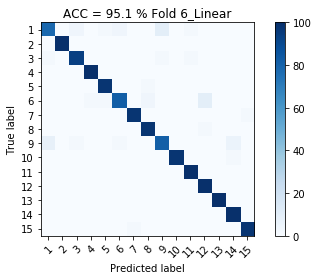

6it [02:36, 24.81s/it]

              precision    recall  f1-score   support

           1       0.89      0.78      0.83        51
           2       1.00      1.00      1.00        50
           3       0.94      0.94      0.94        51
           4       0.98      1.00      0.99        50
           5       0.96      0.98      0.97        50
           6       0.93      0.82      0.87        51
           7       0.98      0.98      0.98        50
           8       0.94      0.98      0.96        51
           9       0.87      0.82      0.85        50
          10       1.00      0.98      0.99        50
          11       0.96      1.00      0.98        50
          12       0.89      1.00      0.94        50
          13       1.00      1.00      1.00        50
          14       0.93      1.00      0.96        50
          15       0.98      0.98      0.98        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

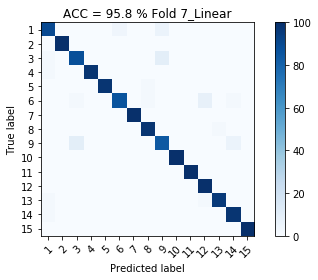

7it [03:00, 24.56s/it]

              precision    recall  f1-score   support

           1       0.92      0.90      0.91        51
           2       1.00      1.00      1.00        51
           3       0.88      0.88      0.88        50
           4       1.00      0.98      0.99        51
           5       1.00      0.98      0.99        50
           6       0.96      0.86      0.91        50
           7       1.00      1.00      1.00        51
           8       0.96      0.98      0.97        50
           9       0.84      0.84      0.84        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.91      1.00      0.95        50
          13       0.98      0.96      0.97        50
          14       0.92      0.98      0.95        50
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

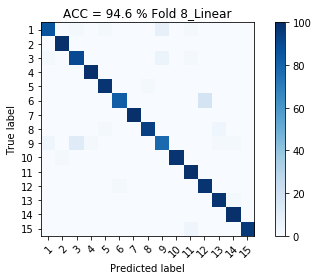

8it [03:29, 25.98s/it]

              precision    recall  f1-score   support

           1       0.93      0.86      0.90        50
           2       0.98      1.00      0.99        50
           3       0.87      0.90      0.88        50
           4       0.98      1.00      0.99        50
           5       0.96      0.98      0.97        50
           6       0.98      0.82      0.89        51
           7       1.00      1.00      1.00        50
           8       0.98      0.94      0.96        51
           9       0.85      0.78      0.81        50
          10       1.00      0.98      0.99        51
          11       0.93      1.00      0.96        50
          12       0.84      0.98      0.91        50
          13       0.94      0.98      0.96        51
          14       0.96      1.00      0.98        50
          15       1.00      0.96      0.98        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

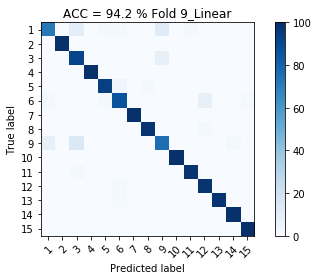

9it [03:58, 26.63s/it]

              precision    recall  f1-score   support

           1       0.88      0.72      0.79        50
           2       1.00      1.00      1.00        51
           3       0.78      0.92      0.84        50
           4       1.00      1.00      1.00        50
           5       0.96      0.94      0.95        50
           6       0.90      0.86      0.88        50
           7       1.00      1.00      1.00        50
           8       0.98      0.98      0.98        50
           9       0.80      0.76      0.78        51
          10       1.00      1.00      1.00        50
          11       0.98      0.98      0.98        50
          12       0.91      0.98      0.94        51
          13       1.00      0.98      0.99        50
          14       0.98      1.00      0.99        50
          15       0.98      1.00      0.99        51

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

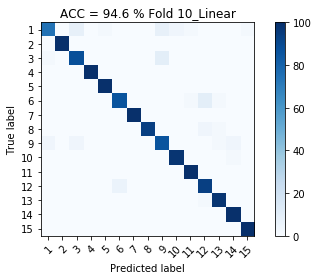

10it [04:34, 27.41s/it]
0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.93      0.75      0.83        51
           2       1.00      1.00      1.00        51
           3       0.88      0.88      0.88        50
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        50
           6       0.93      0.86      0.90        50
           7       1.00      1.00      1.00        50
           8       1.00      0.94      0.97        50
           9       0.83      0.86      0.84        50
          10       0.96      0.98      0.97        50
          11       0.96      1.00      0.98        51
          12       0.86      0.94      0.90        51
          13       0.94      0.98      0.96        50
          14       0.94      1.00      0.97        50
          15       0.98      1.00      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.94       754
weighted avg       0.95   

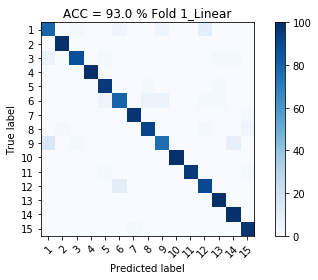

1it [00:29, 29.96s/it]

              precision    recall  f1-score   support

           1       0.80      0.80      0.80        50
           2       0.98      1.00      0.99        50
           3       0.96      0.88      0.92        50
           4       1.00      1.00      1.00        51
           5       0.92      0.96      0.94        50
           6       0.85      0.80      0.82        50
           7       0.98      0.98      0.98        51
           8       0.92      0.92      0.92        50
           9       0.88      0.76      0.82        50
          10       1.00      1.00      1.00        50
          11       1.00      0.96      0.98        51
          12       0.87      0.90      0.88        50
          13       0.94      1.00      0.97        51
          14       0.91      1.00      0.95        50
          15       0.92      0.98      0.95        50

    accuracy                           0.93       754
   macro avg       0.93      0.93      0.93       754
weighted avg       0.93   

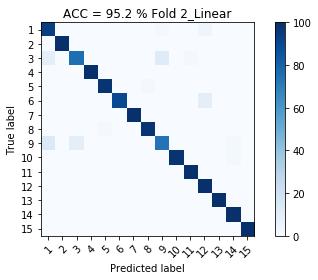

2it [00:58, 29.66s/it]

              precision    recall  f1-score   support

           1       0.80      0.94      0.86        50
           2       1.00      1.00      1.00        50
           3       0.88      0.76      0.82        50
           4       1.00      1.00      1.00        51
           5       0.98      0.98      0.98        50
           6       1.00      0.90      0.95        51
           7       1.00      1.00      1.00        50
           8       0.98      0.98      0.98        51
           9       0.84      0.74      0.79        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.88      1.00      0.93        50
          13       1.00      1.00      1.00        50
          14       0.96      1.00      0.98        51
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

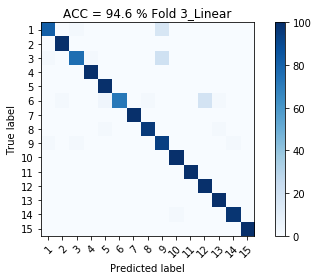

3it [01:32, 30.92s/it]

              precision    recall  f1-score   support

           1       0.95      0.82      0.88        50
           2       0.98      1.00      0.99        50
           3       0.95      0.76      0.84        50
           4       0.98      1.00      0.99        51
           5       0.94      1.00      0.97        51
           6       1.00      0.72      0.84        50
           7       1.00      1.00      1.00        51
           8       0.98      0.96      0.97        50
           9       0.72      0.94      0.82        50
          10       0.98      1.00      0.99        50
          11       1.00      1.00      1.00        50
          12       0.85      1.00      0.92        50
          13       0.96      1.00      0.98        51
          14       0.98      0.98      0.98        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.94       754
weighted avg       0.95   

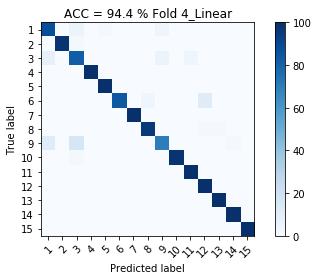

4it [02:03, 30.78s/it]

              precision    recall  f1-score   support

           1       0.81      0.88      0.85        50
           2       1.00      0.98      0.99        51
           3       0.76      0.82      0.79        51
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        50
           6       1.00      0.84      0.91        50
           7       1.00      1.00      1.00        51
           8       0.96      0.96      0.96        50
           9       0.88      0.70      0.78        50
          10       1.00      0.98      0.99        51
          11       0.96      1.00      0.98        50
          12       0.88      1.00      0.93        50
          13       0.98      1.00      0.99        50
          14       0.98      1.00      0.99        50
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.95      0.94      0.94       754
weighted avg       0.95   

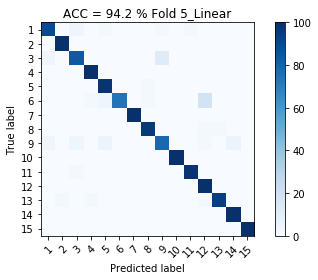

5it [02:33, 30.62s/it]

              precision    recall  f1-score   support

           1       0.92      0.90      0.91        50
           2       0.98      1.00      0.99        51
           3       0.89      0.84      0.87        50
           4       0.96      1.00      0.98        50
           5       0.89      0.98      0.93        50
           6       1.00      0.74      0.85        50
           7       1.00      1.00      1.00        51
           8       0.96      0.96      0.96        50
           9       0.85      0.78      0.81        50
          10       1.00      1.00      1.00        50
          11       0.98      0.98      0.98        50
          12       0.81      1.00      0.89        51
          13       0.98      0.94      0.96        50
          14       0.94      1.00      0.97        51
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

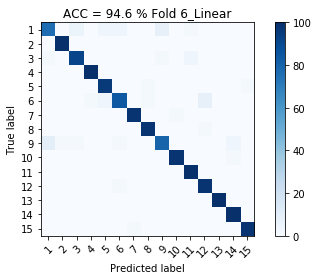

6it [03:03, 30.51s/it]

              precision    recall  f1-score   support

           1       0.87      0.76      0.81        51
           2       0.98      1.00      0.99        50
           3       0.92      0.92      0.92        51
           4       0.98      1.00      0.99        50
           5       0.92      0.96      0.94        50
           6       0.91      0.84      0.88        51
           7       0.98      0.98      0.98        50
           8       0.96      0.98      0.97        51
           9       0.89      0.80      0.84        50
          10       0.98      0.98      0.98        50
          11       0.94      1.00      0.97        50
          12       0.91      0.98      0.94        50
          13       1.00      1.00      1.00        50
          14       0.94      1.00      0.97        50
          15       0.98      0.98      0.98        50

    accuracy                           0.95       754
   macro avg       0.94      0.95      0.94       754
weighted avg       0.94   

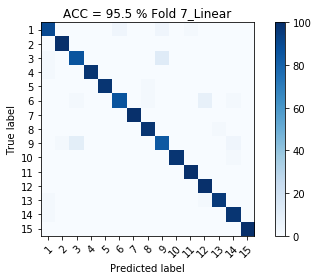

7it [03:35, 30.89s/it]

              precision    recall  f1-score   support

           1       0.92      0.90      0.91        51
           2       0.98      1.00      0.99        51
           3       0.88      0.86      0.87        50
           4       1.00      0.98      0.99        51
           5       1.00      0.98      0.99        50
           6       0.96      0.86      0.91        50
           7       1.00      1.00      1.00        51
           8       0.96      0.98      0.97        50
           9       0.84      0.84      0.84        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.91      1.00      0.95        50
          13       0.98      0.96      0.97        50
          14       0.92      0.98      0.95        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.96      0.95      0.95       754
weighted avg       0.96   

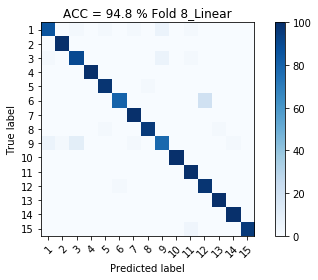

8it [04:06, 30.78s/it]

              precision    recall  f1-score   support

           1       0.91      0.86      0.89        50
           2       0.98      1.00      0.99        50
           3       0.88      0.90      0.89        50
           4       1.00      1.00      1.00        50
           5       0.96      0.98      0.97        50
           6       0.98      0.80      0.88        51
           7       0.96      1.00      0.98        50
           8       0.98      0.96      0.97        51
           9       0.87      0.78      0.82        50
          10       1.00      1.00      1.00        51
          11       0.93      1.00      0.96        50
          12       0.83      0.98      0.90        50
          13       0.98      1.00      0.99        51
          14       0.98      1.00      0.99        50
          15       1.00      0.96      0.98        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

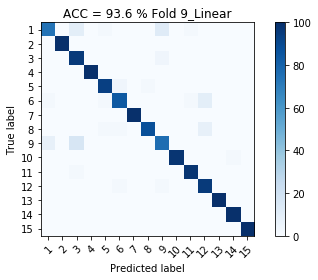

9it [04:35, 30.42s/it]

              precision    recall  f1-score   support

           1       0.88      0.74      0.80        50
           2       1.00      1.00      1.00        51
           3       0.77      0.96      0.86        50
           4       1.00      1.00      1.00        50
           5       0.94      0.94      0.94        50
           6       0.91      0.84      0.87        50
           7       1.00      1.00      1.00        50
           8       0.98      0.88      0.93        50
           9       0.81      0.76      0.79        51
          10       1.00      0.98      0.99        50
          11       0.96      0.98      0.97        50
          12       0.84      0.96      0.90        51
          13       1.00      1.00      1.00        50
          14       0.98      1.00      0.99        50
          15       1.00      1.00      1.00        51

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

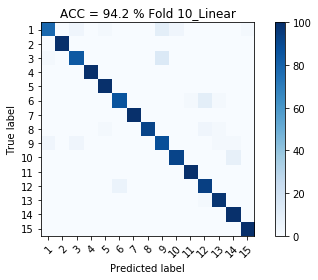

10it [05:06, 30.68s/it]
0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.93      0.78      0.85        51
           2       1.00      1.00      1.00        51
           3       0.91      0.84      0.87        50
           4       1.00      1.00      1.00        50
           5       0.96      1.00      0.98        50
           6       0.93      0.86      0.90        50
           7       1.00      1.00      1.00        50
           8       1.00      0.92      0.96        50
           9       0.79      0.88      0.83        50
          10       0.96      0.92      0.94        50
          11       0.98      1.00      0.99        51
          12       0.86      0.94      0.90        51
          13       0.94      0.98      0.96        50
          14       0.91      1.00      0.95        50
          15       0.98      1.00      0.99        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

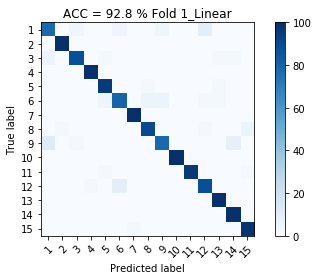

1it [00:31, 31.80s/it]

              precision    recall  f1-score   support

           1       0.81      0.78      0.80        50
           2       0.98      1.00      0.99        50
           3       0.94      0.88      0.91        50
           4       0.98      1.00      0.99        51
           5       0.92      0.96      0.94        50
           6       0.85      0.80      0.82        50
           7       0.98      1.00      0.99        51
           8       0.92      0.90      0.91        50
           9       0.89      0.78      0.83        50
          10       1.00      1.00      1.00        50
          11       1.00      0.96      0.98        51
          12       0.86      0.88      0.87        50
          13       0.94      1.00      0.97        51
          14       0.91      1.00      0.95        50
          15       0.92      0.98      0.95        50

    accuracy                           0.93       754
   macro avg       0.93      0.93      0.93       754
weighted avg       0.93   

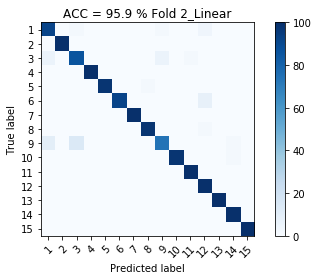

2it [01:03, 31.87s/it]

              precision    recall  f1-score   support

           1       0.85      0.92      0.88        50
           2       1.00      1.00      1.00        50
           3       0.84      0.86      0.85        50
           4       1.00      1.00      1.00        51
           5       1.00      0.98      0.99        50
           6       1.00      0.92      0.96        51
           7       1.00      1.00      1.00        50
           8       0.98      0.98      0.98        51
           9       0.90      0.74      0.81        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.88      1.00      0.93        50
          13       1.00      1.00      1.00        50
          14       0.96      1.00      0.98        51
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

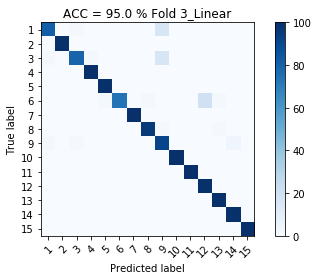

3it [01:38, 32.65s/it]

              precision    recall  f1-score   support

           1       0.95      0.82      0.88        50
           2       1.00      1.00      1.00        50
           3       0.95      0.80      0.87        50
           4       0.98      1.00      0.99        51
           5       0.98      1.00      0.99        51
           6       1.00      0.74      0.85        50
           7       1.00      1.00      1.00        51
           8       0.98      0.96      0.97        50
           9       0.73      0.92      0.81        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.83      1.00      0.91        50
          13       0.96      1.00      0.98        51
          14       0.96      1.00      0.98        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.96      0.95      0.95       754
weighted avg       0.96   

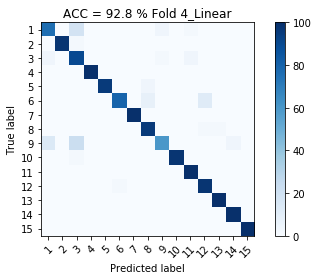

4it [02:11, 32.73s/it]

              precision    recall  f1-score   support

           1       0.81      0.76      0.78        50
           2       1.00      0.98      0.99        51
           3       0.68      0.90      0.77        51
           4       1.00      1.00      1.00        50
           5       1.00      0.96      0.98        50
           6       0.98      0.80      0.88        50
           7       1.00      1.00      1.00        51
           8       0.89      0.96      0.92        50
           9       0.91      0.60      0.72        50
          10       1.00      0.98      0.99        51
          11       0.94      1.00      0.97        50
          12       0.88      0.98      0.92        50
          13       0.98      1.00      0.99        50
          14       0.96      1.00      0.98        50
          15       1.00      1.00      1.00        50

    accuracy                           0.93       754
   macro avg       0.93      0.93      0.93       754
weighted avg       0.93   

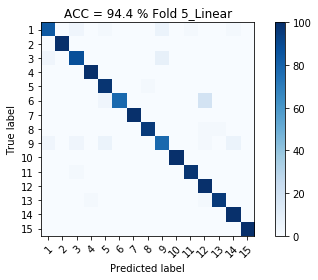

5it [02:58, 37.12s/it]

              precision    recall  f1-score   support

           1       0.91      0.84      0.87        50
           2       1.00      1.00      1.00        51
           3       0.90      0.88      0.89        50
           4       0.98      1.00      0.99        50
           5       0.89      0.98      0.93        50
           6       1.00      0.78      0.88        50
           7       1.00      1.00      1.00        51
           8       0.98      0.96      0.97        50
           9       0.85      0.78      0.81        50
          10       1.00      1.00      1.00        50
          11       0.98      0.98      0.98        50
          12       0.81      1.00      0.89        51
          13       0.98      0.96      0.97        50
          14       0.93      1.00      0.96        51
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.95      0.94      0.94       754
weighted avg       0.95   

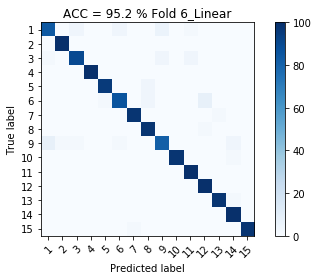

6it [03:31, 35.79s/it]

              precision    recall  f1-score   support

           1       0.90      0.84      0.87        51
           2       0.98      1.00      0.99        50
           3       0.94      0.90      0.92        51
           4       1.00      1.00      1.00        50
           5       0.98      0.96      0.97        50
           6       0.94      0.86      0.90        51
           7       0.98      0.98      0.98        50
           8       0.93      0.98      0.95        51
           9       0.89      0.82      0.85        50
          10       1.00      0.98      0.99        50
          11       0.94      1.00      0.97        50
          12       0.91      1.00      0.95        50
          13       0.98      0.98      0.98        50
          14       0.93      1.00      0.96        50
          15       1.00      0.98      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

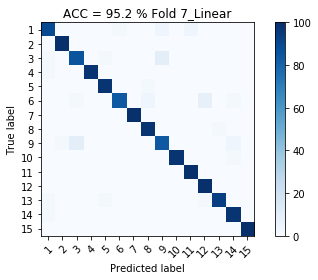

7it [03:53, 31.80s/it]

              precision    recall  f1-score   support

           1       0.92      0.90      0.91        51
           2       0.98      1.00      0.99        51
           3       0.88      0.86      0.87        50
           4       1.00      0.98      0.99        51
           5       0.96      0.98      0.97        50
           6       0.98      0.84      0.90        50
           7       1.00      1.00      1.00        51
           8       0.94      0.98      0.96        50
           9       0.86      0.84      0.85        50
          10       1.00      0.98      0.99        50
          11       0.96      1.00      0.98        50
          12       0.91      1.00      0.95        50
          13       0.98      0.94      0.96        50
          14       0.92      0.98      0.95        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

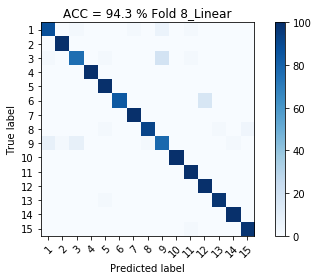

8it [04:24, 31.57s/it]

              precision    recall  f1-score   support

           1       0.90      0.88      0.89        50
           2       0.98      1.00      0.99        50
           3       0.88      0.76      0.82        50
           4       1.00      1.00      1.00        50
           5       0.94      1.00      0.97        50
           6       1.00      0.84      0.91        51
           7       0.98      1.00      0.99        50
           8       0.98      0.92      0.95        51
           9       0.76      0.78      0.77        50
          10       1.00      1.00      1.00        51
          11       0.94      1.00      0.97        50
          12       0.86      1.00      0.93        50
          13       0.98      0.98      0.98        51
          14       0.98      1.00      0.99        50
          15       0.96      0.98      0.97        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

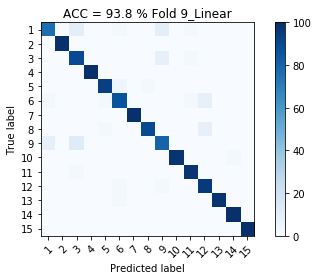

9it [05:01, 33.04s/it]

              precision    recall  f1-score   support

           1       0.88      0.76      0.82        50
           2       1.00      1.00      1.00        51
           3       0.79      0.90      0.84        50
           4       1.00      1.00      1.00        50
           5       0.96      0.94      0.95        50
           6       0.90      0.86      0.88        50
           7       1.00      1.00      1.00        50
           8       0.98      0.90      0.94        50
           9       0.80      0.80      0.80        51
          10       1.00      0.98      0.99        50
          11       0.94      0.98      0.96        50
          12       0.86      0.96      0.91        51
          13       1.00      0.98      0.99        50
          14       0.98      1.00      0.99        50
          15       1.00      1.00      1.00        51

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

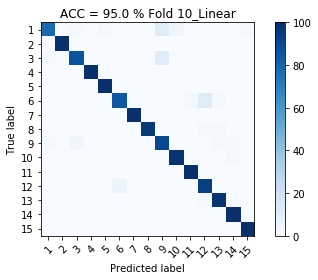

10it [05:33, 33.35s/it]
0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.95      0.78      0.86        51
           2       1.00      1.00      1.00        51
           3       0.93      0.86      0.90        50
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        50
           6       0.93      0.84      0.88        50
           7       1.00      1.00      1.00        50
           8       1.00      0.96      0.98        50
           9       0.79      0.90      0.84        50
          10       0.96      0.98      0.97        50
          11       0.98      1.00      0.99        51
          12       0.86      0.94      0.90        51
          13       0.94      0.98      0.96        50
          14       0.96      1.00      0.98        50
          15       0.98      1.00      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

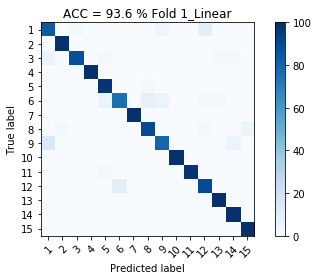

1it [00:23, 23.07s/it]

              precision    recall  f1-score   support

           1       0.81      0.84      0.82        50
           2       0.98      1.00      0.99        50
           3       0.98      0.88      0.93        50
           4       1.00      1.00      1.00        51
           5       0.91      0.98      0.94        50
           6       0.88      0.76      0.82        50
           7       1.00      1.00      1.00        51
           8       0.90      0.90      0.90        50
           9       0.89      0.80      0.84        50
          10       1.00      1.00      1.00        50
          11       1.00      0.98      0.99        51
          12       0.87      0.90      0.88        50
          13       0.96      1.00      0.98        51
          14       0.93      1.00      0.96        50
          15       0.94      1.00      0.97        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

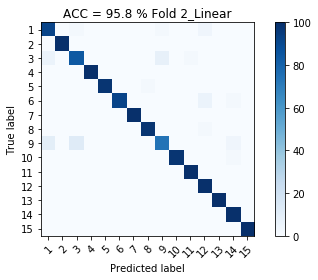

2it [00:57, 26.52s/it]

              precision    recall  f1-score   support

           1       0.85      0.92      0.88        50
           2       1.00      1.00      1.00        50
           3       0.86      0.84      0.85        50
           4       1.00      1.00      1.00        51
           5       1.00      0.98      0.99        50
           6       1.00      0.92      0.96        51
           7       1.00      1.00      1.00        50
           8       0.98      0.98      0.98        51
           9       0.88      0.74      0.80        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.89      1.00      0.94        50
          13       1.00      1.00      1.00        50
          14       0.93      1.00      0.96        51
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

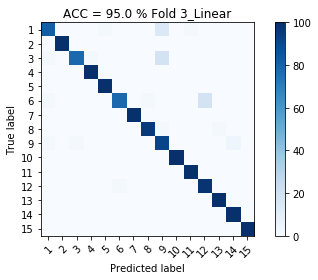

3it [01:41, 31.70s/it]

              precision    recall  f1-score   support

           1       0.93      0.82      0.87        50
           2       1.00      1.00      1.00        50
           3       0.97      0.78      0.87        50
           4       0.98      1.00      0.99        51
           5       0.98      1.00      0.99        51
           6       0.97      0.78      0.87        50
           7       1.00      1.00      1.00        51
           8       0.98      0.96      0.97        50
           9       0.73      0.92      0.81        50
          10       1.00      1.00      1.00        50
          11       0.98      1.00      0.99        50
          12       0.84      0.98      0.91        50
          13       0.98      1.00      0.99        51
          14       0.96      1.00      0.98        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

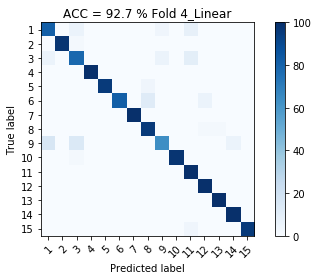

4it [02:08, 30.16s/it]

              precision    recall  f1-score   support

           1       0.79      0.82      0.80        50
           2       1.00      0.98      0.99        51
           3       0.77      0.78      0.78        51
           4       1.00      1.00      1.00        50
           5       1.00      0.96      0.98        50
           6       1.00      0.82      0.90        50
           7       1.00      1.00      1.00        51
           8       0.86      0.96      0.91        50
           9       0.86      0.64      0.74        50
          10       1.00      0.98      0.99        51
          11       0.82      1.00      0.90        50
          12       0.93      1.00      0.96        50
          13       0.98      1.00      0.99        50
          14       0.94      1.00      0.97        50
          15       1.00      0.96      0.98        50

    accuracy                           0.93       754
   macro avg       0.93      0.93      0.93       754
weighted avg       0.93   

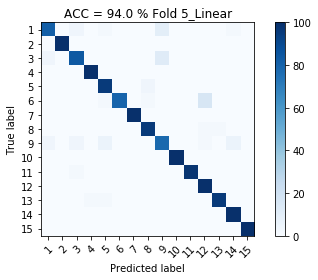

5it [02:42, 31.57s/it]

              precision    recall  f1-score   support

           1       0.91      0.82      0.86        50
           2       1.00      1.00      1.00        51
           3       0.89      0.84      0.87        50
           4       0.98      1.00      0.99        50
           5       0.89      0.96      0.92        50
           6       1.00      0.80      0.89        50
           7       1.00      1.00      1.00        51
           8       0.94      0.96      0.95        50
           9       0.78      0.78      0.78        50
          10       1.00      1.00      1.00        50
          11       1.00      0.98      0.99        50
          12       0.84      1.00      0.91        51
          13       0.98      0.96      0.97        50
          14       0.93      1.00      0.96        51
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

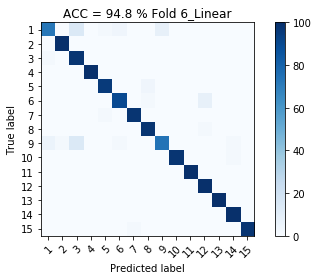

6it [03:18, 32.79s/it]

              precision    recall  f1-score   support

           1       0.90      0.73      0.80        51
           2       0.98      1.00      0.99        50
           3       0.78      0.98      0.87        51
           4       1.00      1.00      1.00        50
           5       0.96      0.96      0.96        50
           6       0.94      0.90      0.92        51
           7       0.98      0.98      0.98        50
           8       0.94      0.98      0.96        51
           9       0.90      0.74      0.81        50
          10       1.00      0.98      0.99        50
          11       1.00      1.00      1.00        50
          12       0.91      1.00      0.95        50
          13       1.00      1.00      1.00        50
          14       0.96      1.00      0.98        50
          15       1.00      0.98      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

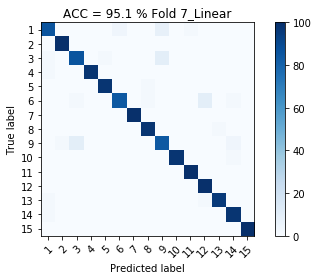

7it [03:53, 33.56s/it]

              precision    recall  f1-score   support

           1       0.92      0.86      0.89        51
           2       0.98      1.00      0.99        51
           3       0.88      0.86      0.87        50
           4       1.00      0.98      0.99        51
           5       0.98      0.98      0.98        50
           6       0.95      0.84      0.89        50
           7       1.00      1.00      1.00        51
           8       0.96      0.98      0.97        50
           9       0.82      0.84      0.83        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.89      1.00      0.94        50
          13       0.98      0.96      0.97        50
          14       0.92      0.98      0.95        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

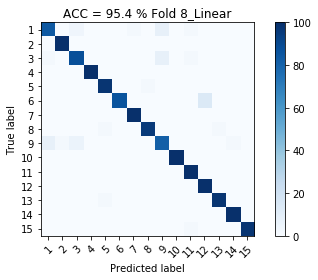

8it [04:28, 33.89s/it]

              precision    recall  f1-score   support

           1       0.89      0.84      0.87        50
           2       0.98      1.00      0.99        50
           3       0.90      0.88      0.89        50
           4       1.00      1.00      1.00        50
           5       0.96      0.98      0.97        50
           6       1.00      0.86      0.93        51
           7       0.98      1.00      0.99        50
           8       0.98      0.96      0.97        51
           9       0.84      0.82      0.83        50
          10       1.00      1.00      1.00        51
          11       0.94      1.00      0.97        50
          12       0.88      1.00      0.93        50
          13       0.98      0.98      0.98        51
          14       0.98      1.00      0.99        50
          15       1.00      0.98      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

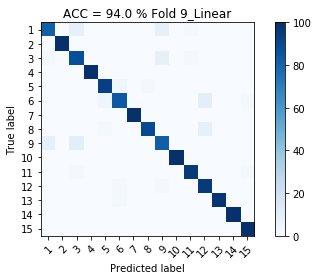

9it [04:50, 30.27s/it]

              precision    recall  f1-score   support

           1       0.89      0.82      0.85        50
           2       1.00      1.00      1.00        51
           3       0.81      0.88      0.85        50
           4       1.00      1.00      1.00        50
           5       0.94      0.94      0.94        50
           6       0.91      0.84      0.87        50
           7       1.00      1.00      1.00        50
           8       0.98      0.90      0.94        50
           9       0.82      0.82      0.82        51
          10       1.00      1.00      1.00        50
          11       0.96      0.96      0.96        50
          12       0.84      0.96      0.90        51
          13       1.00      0.98      0.99        50
          14       1.00      1.00      1.00        50
          15       0.96      1.00      0.98        51

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

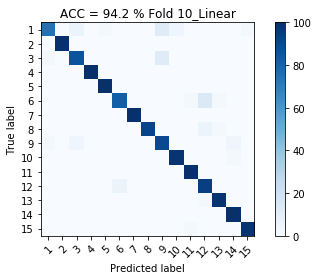

10it [05:26, 32.68s/it]
0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.95      0.75      0.84        51
           2       1.00      1.00      1.00        51
           3       0.90      0.86      0.88        50
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        50
           6       0.93      0.82      0.87        50
           7       1.00      1.00      1.00        50
           8       1.00      0.92      0.96        50
           9       0.79      0.90      0.84        50
          10       0.96      0.98      0.97        50
          11       0.96      1.00      0.98        51
          12       0.81      0.94      0.87        51
          13       0.96      0.98      0.97        50
          14       0.94      1.00      0.97        50
          15       0.98      0.98      0.98        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

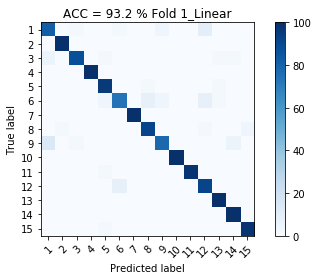

1it [00:22, 22.60s/it]

              precision    recall  f1-score   support

           1       0.80      0.82      0.81        50
           2       0.98      1.00      0.99        50
           3       0.96      0.88      0.92        50
           4       1.00      1.00      1.00        51
           5       0.91      0.96      0.93        50
           6       0.88      0.74      0.80        50
           7       1.00      1.00      1.00        51
           8       0.90      0.92      0.91        50
           9       0.91      0.78      0.84        50
          10       1.00      1.00      1.00        50
          11       1.00      0.98      0.99        51
          12       0.82      0.92      0.87        50
          13       0.94      1.00      0.97        51
          14       0.93      1.00      0.96        50
          15       0.96      0.98      0.97        50

    accuracy                           0.93       754
   macro avg       0.93      0.93      0.93       754
weighted avg       0.93   

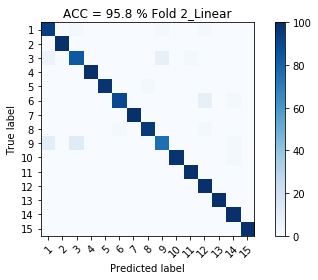

2it [01:00, 27.07s/it]

              precision    recall  f1-score   support

           1       0.85      0.94      0.90        50
           2       1.00      1.00      1.00        50
           3       0.86      0.84      0.85        50
           4       1.00      1.00      1.00        51
           5       1.00      0.98      0.99        50
           6       0.98      0.90      0.94        51
           7       1.00      1.00      1.00        50
           8       0.98      0.96      0.97        51
           9       0.88      0.76      0.82        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.89      1.00      0.94        50
          13       1.00      1.00      1.00        50
          14       0.94      1.00      0.97        51
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

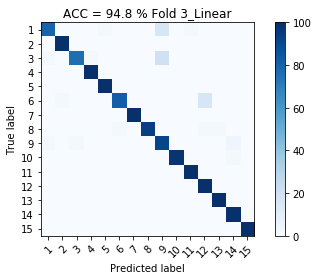

3it [01:24, 26.16s/it]

              precision    recall  f1-score   support

           1       0.95      0.80      0.87        50
           2       0.98      1.00      0.99        50
           3       0.97      0.76      0.85        50
           4       0.98      1.00      0.99        51
           5       0.98      1.00      0.99        51
           6       0.98      0.82      0.89        50
           7       1.00      1.00      1.00        51
           8       1.00      0.94      0.97        50
           9       0.72      0.92      0.81        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.85      1.00      0.92        50
          13       0.98      1.00      0.99        51
          14       0.94      1.00      0.97        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

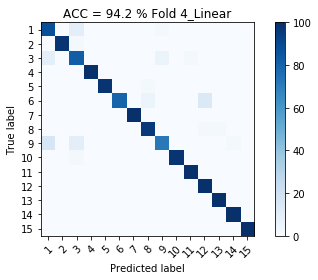

4it [02:03, 30.09s/it]

              precision    recall  f1-score   support

           1       0.77      0.88      0.82        50
           2       1.00      0.98      0.99        51
           3       0.78      0.82      0.80        51
           4       1.00      1.00      1.00        50
           5       1.00      0.98      0.99        50
           6       1.00      0.80      0.89        50
           7       1.00      1.00      1.00        51
           8       0.92      0.96      0.94        50
           9       0.90      0.72      0.80        50
          10       1.00      0.98      0.99        51
          11       0.98      1.00      0.99        50
          12       0.86      1.00      0.93        50
          13       0.98      1.00      0.99        50
          14       0.98      1.00      0.99        50
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.95      0.94      0.94       754
weighted avg       0.95   

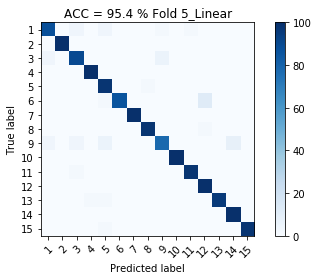

5it [02:25, 27.74s/it]

              precision    recall  f1-score   support

           1       0.92      0.88      0.90        50
           2       1.00      1.00      1.00        51
           3       0.90      0.90      0.90        50
           4       0.98      1.00      0.99        50
           5       0.86      0.98      0.92        50
           6       1.00      0.86      0.92        50
           7       1.00      1.00      1.00        51
           8       0.98      0.98      0.98        50
           9       0.91      0.78      0.84        50
          10       1.00      1.00      1.00        50
          11       0.98      0.98      0.98        50
          12       0.88      1.00      0.94        51
          13       1.00      0.96      0.98        50
          14       0.93      1.00      0.96        51
          15       1.00      0.98      0.99        50

    accuracy                           0.95       754
   macro avg       0.96      0.95      0.95       754
weighted avg       0.96   

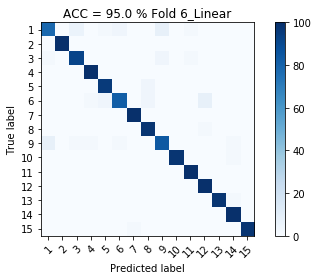

6it [03:04, 31.07s/it]

              precision    recall  f1-score   support

           1       0.89      0.78      0.83        51
           2       1.00      1.00      1.00        50
           3       0.92      0.92      0.92        51
           4       0.96      1.00      0.98        50
           5       0.94      0.96      0.95        50
           6       0.93      0.82      0.87        51
           7       0.98      1.00      0.99        50
           8       0.93      0.98      0.95        51
           9       0.88      0.84      0.86        50
          10       1.00      0.98      0.99        50
          11       0.96      1.00      0.98        50
          12       0.91      1.00      0.95        50
          13       1.00      0.98      0.99        50
          14       0.94      1.00      0.97        50
          15       1.00      0.98      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

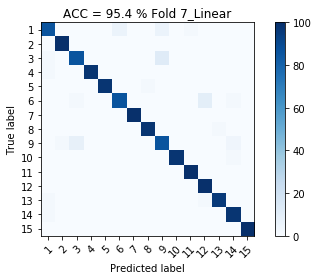

7it [03:42, 33.03s/it]

              precision    recall  f1-score   support

           1       0.92      0.86      0.89        51
           2       0.98      1.00      0.99        51
           3       0.90      0.86      0.88        50
           4       1.00      0.98      0.99        51
           5       1.00      0.98      0.99        50
           6       0.93      0.86      0.90        50
           7       1.00      1.00      1.00        51
           8       0.98      0.98      0.98        50
           9       0.83      0.86      0.84        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.89      1.00      0.94        50
          13       0.98      0.96      0.97        50
          14       0.92      0.98      0.95        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

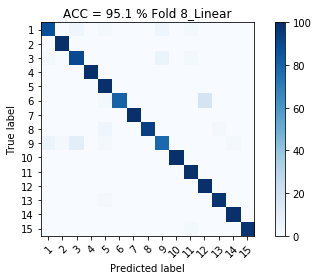

8it [04:19, 34.36s/it]

              precision    recall  f1-score   support

           1       0.92      0.88      0.90        50
           2       0.98      1.00      0.99        50
           3       0.87      0.90      0.88        50
           4       1.00      1.00      1.00        50
           5       0.89      1.00      0.94        50
           6       1.00      0.80      0.89        51
           7       1.00      1.00      1.00        50
           8       1.00      0.94      0.97        51
           9       0.89      0.78      0.83        50
          10       1.00      1.00      1.00        51
          11       0.94      1.00      0.97        50
          12       0.85      1.00      0.92        50
          13       0.98      0.98      0.98        51
          14       0.98      1.00      0.99        50
          15       1.00      0.98      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

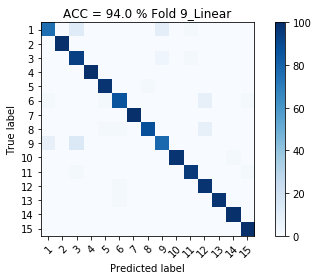

9it [04:57, 35.33s/it]

              precision    recall  f1-score   support

           1       0.88      0.76      0.82        50
           2       1.00      1.00      1.00        51
           3       0.77      0.94      0.85        50
           4       1.00      1.00      1.00        50
           5       0.96      0.98      0.97        50
           6       0.93      0.86      0.90        50
           7       1.00      1.00      1.00        50
           8       0.98      0.88      0.93        50
           9       0.85      0.78      0.82        51
          10       1.00      0.98      0.99        50
          11       0.96      0.96      0.96        50
          12       0.86      0.98      0.92        51
          13       1.00      0.98      0.99        50
          14       0.98      1.00      0.99        50
          15       0.96      1.00      0.98        51

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

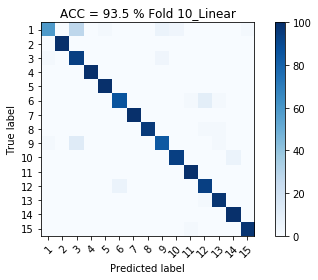

10it [05:36, 33.61s/it]
0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.94      0.59      0.72        51
           2       1.00      1.00      1.00        51
           3       0.70      0.94      0.80        50
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        50
           6       0.93      0.86      0.90        50
           7       1.00      1.00      1.00        50
           8       1.00      0.96      0.98        50
           9       0.89      0.84      0.87        50
          10       0.96      0.94      0.95        50
          11       0.96      1.00      0.98        51
          12       0.87      0.94      0.91        51
          13       0.94      0.98      0.96        50
          14       0.94      1.00      0.97        50
          15       0.98      0.98      0.98        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.93       754
weighted avg       0.94   

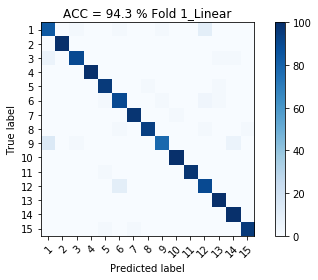

1it [00:41, 41.69s/it]

              precision    recall  f1-score   support

           1       0.81      0.84      0.82        50
           2       1.00      1.00      1.00        50
           3       0.96      0.90      0.93        50
           4       1.00      1.00      1.00        51
           5       0.94      0.96      0.95        50
           6       0.87      0.90      0.88        50
           7       0.98      0.98      0.98        51
           8       0.98      0.94      0.96        50
           9       0.95      0.78      0.86        50
          10       0.98      1.00      0.99        50
          11       1.00      0.98      0.99        51
          12       0.85      0.90      0.87        50
          13       0.94      1.00      0.97        51
          14       0.93      1.00      0.96        50
          15       0.98      0.96      0.97        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

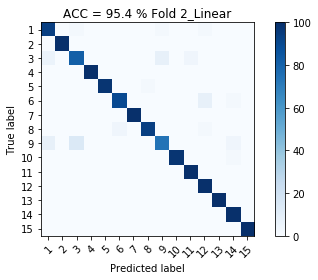

2it [01:24, 42.02s/it]

              precision    recall  f1-score   support

           1       0.87      0.94      0.90        50
           2       1.00      1.00      1.00        50
           3       0.84      0.82      0.83        50
           4       1.00      1.00      1.00        51
           5       1.00      0.98      0.99        50
           6       0.96      0.90      0.93        51
           7       1.00      1.00      1.00        50
           8       0.98      0.94      0.96        51
           9       0.88      0.74      0.80        50
          10       1.00      0.98      0.99        50
          11       0.96      1.00      0.98        50
          12       0.89      1.00      0.94        50
          13       1.00      1.00      1.00        50
          14       0.93      1.00      0.96        51
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

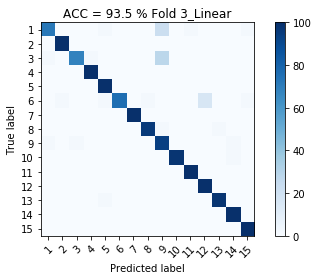

3it [01:49, 36.80s/it]

              precision    recall  f1-score   support

           1       0.95      0.72      0.82        50
           2       0.98      1.00      0.99        50
           3       0.97      0.68      0.80        50
           4       0.98      1.00      0.99        51
           5       0.94      1.00      0.97        51
           6       1.00      0.76      0.86        50
           7       1.00      1.00      1.00        51
           8       0.98      0.96      0.97        50
           9       0.64      0.94      0.76        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.86      1.00      0.93        50
          13       0.98      0.98      0.98        51
          14       0.96      1.00      0.98        50
          15       0.96      1.00      0.98        50

    accuracy                           0.94       754
   macro avg       0.95      0.93      0.93       754
weighted avg       0.95   

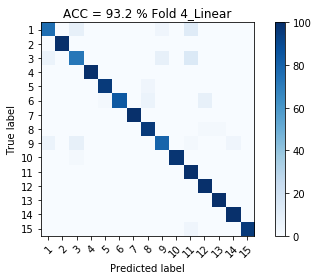

4it [02:13, 33.12s/it]

              precision    recall  f1-score   support

           1       0.86      0.76      0.81        50
           2       1.00      1.00      1.00        51
           3       0.80      0.73      0.76        51
           4       1.00      1.00      1.00        50
           5       0.98      0.96      0.97        50
           6       1.00      0.84      0.91        50
           7       1.00      1.00      1.00        51
           8       0.91      0.96      0.93        50
           9       0.87      0.80      0.83        50
          10       1.00      0.98      0.99        51
          11       0.76      1.00      0.86        50
          12       0.91      1.00      0.95        50
          13       0.98      1.00      0.99        50
          14       0.96      1.00      0.98        50
          15       1.00      0.96      0.98        50

    accuracy                           0.93       754
   macro avg       0.94      0.93      0.93       754
weighted avg       0.94   

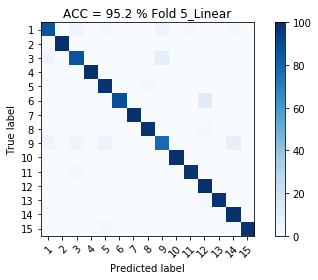

5it [02:38, 30.68s/it]

              precision    recall  f1-score   support

           1       0.91      0.86      0.89        50
           2       1.00      1.00      1.00        51
           3       0.90      0.86      0.88        50
           4       1.00      1.00      1.00        50
           5       0.91      0.98      0.94        50
           6       1.00      0.88      0.94        50
           7       1.00      1.00      1.00        51
           8       0.98      0.98      0.98        50
           9       0.85      0.78      0.81        50
          10       1.00      1.00      1.00        50
          11       0.98      0.98      0.98        50
          12       0.86      1.00      0.93        51
          13       1.00      0.98      0.99        50
          14       0.91      1.00      0.95        51
          15       1.00      0.98      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

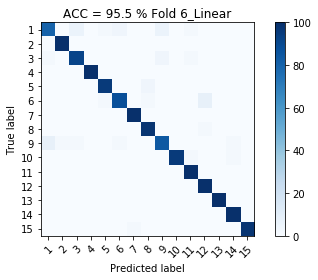

6it [03:20, 34.03s/it]

              precision    recall  f1-score   support

           1       0.89      0.80      0.85        51
           2       0.98      1.00      0.99        50
           3       0.92      0.92      0.92        51
           4       1.00      1.00      1.00        50
           5       0.96      0.96      0.96        50
           6       0.94      0.88      0.91        51
           7       0.98      1.00      0.99        50
           8       0.94      0.98      0.96        51
           9       0.89      0.84      0.87        50
          10       1.00      0.96      0.98        50
          11       0.94      1.00      0.97        50
          12       0.91      1.00      0.95        50
          13       1.00      1.00      1.00        50
          14       0.96      1.00      0.98        50
          15       1.00      0.98      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.96      0.95       754
weighted avg       0.95   

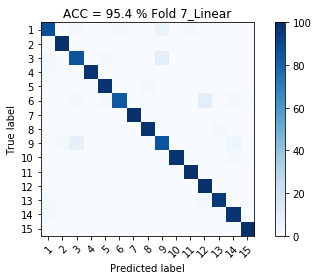

7it [04:00, 35.88s/it]

              precision    recall  f1-score   support

           1       0.92      0.88      0.90        51
           2       0.98      1.00      0.99        51
           3       0.88      0.86      0.87        50
           4       1.00      0.98      0.99        51
           5       0.96      0.98      0.97        50
           6       0.98      0.84      0.90        50
           7       1.00      1.00      1.00        51
           8       0.98      0.98      0.98        50
           9       0.84      0.86      0.85        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.89      1.00      0.94        50
          13       0.98      0.96      0.97        50
          14       0.92      0.98      0.95        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

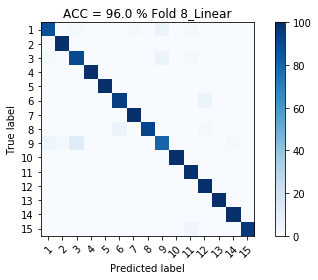

8it [04:40, 36.97s/it]

              precision    recall  f1-score   support

           1       0.94      0.88      0.91        50
           2       0.98      1.00      0.99        50
           3       0.87      0.90      0.88        50
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        50
           6       0.94      0.94      0.94        51
           7       0.98      1.00      0.99        50
           8       1.00      0.92      0.96        51
           9       0.87      0.80      0.83        50
          10       1.00      1.00      1.00        51
          11       0.93      1.00      0.96        50
          12       0.93      1.00      0.96        50
          13       1.00      1.00      1.00        51
          14       0.98      1.00      0.99        50
          15       1.00      0.96      0.98        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

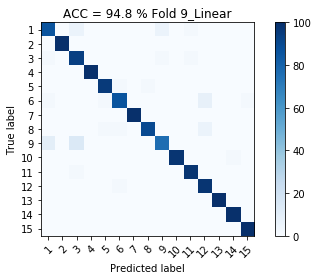

9it [05:04, 33.24s/it]

              precision    recall  f1-score   support

           1       0.86      0.86      0.86        50
           2       1.00      1.00      1.00        51
           3       0.81      0.94      0.87        50
           4       1.00      1.00      1.00        50
           5       0.96      0.96      0.96        50
           6       0.93      0.86      0.90        50
           7       1.00      1.00      1.00        50
           8       0.98      0.90      0.94        50
           9       0.91      0.76      0.83        51
          10       1.00      0.98      0.99        50
          11       0.96      0.98      0.97        50
          12       0.88      0.98      0.93        51
          13       1.00      1.00      1.00        50
          14       0.98      1.00      0.99        50
          15       0.98      1.00      0.99        51

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

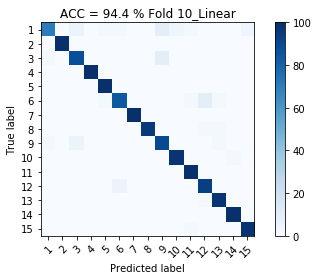

10it [05:35, 33.53s/it]
0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.95      0.71      0.81        51
           2       1.00      1.00      1.00        51
           3       0.88      0.88      0.88        50
           4       1.00      1.00      1.00        50
           5       0.96      1.00      0.98        50
           6       0.91      0.84      0.87        50
           7       1.00      1.00      1.00        50
           8       1.00      0.96      0.98        50
           9       0.82      0.90      0.86        50
          10       0.96      0.98      0.97        50
          11       0.94      1.00      0.97        51
          12       0.87      0.94      0.91        51
          13       0.94      0.98      0.96        50
          14       0.98      1.00      0.99        50
          15       0.96      0.98      0.97        50

    accuracy                           0.94       754
   macro avg       0.95      0.94      0.94       754
weighted avg       0.95   

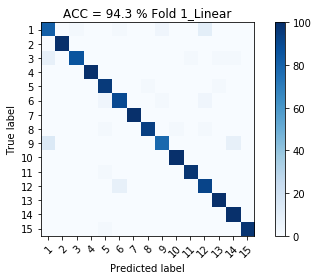

1it [00:25, 25.61s/it]

              precision    recall  f1-score   support

           1       0.79      0.82      0.80        50
           2       1.00      1.00      1.00        50
           3       0.98      0.86      0.91        50
           4       1.00      1.00      1.00        51
           5       0.91      0.96      0.93        50
           6       0.90      0.90      0.90        50
           7       1.00      1.00      1.00        51
           8       0.98      0.94      0.96        50
           9       0.93      0.78      0.85        50
          10       0.98      1.00      0.99        50
          11       0.98      0.98      0.98        51
          12       0.85      0.92      0.88        50
          13       0.96      1.00      0.98        51
          14       0.91      1.00      0.95        50
          15       1.00      0.98      0.99        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

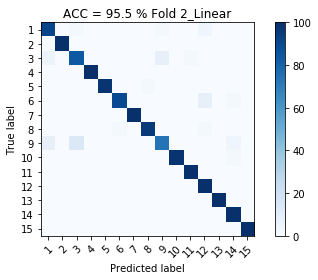

2it [01:08, 30.87s/it]

              precision    recall  f1-score   support

           1       0.87      0.92      0.89        50
           2       1.00      1.00      1.00        50
           3       0.84      0.84      0.84        50
           4       1.00      1.00      1.00        51
           5       1.00      0.98      0.99        50
           6       0.98      0.90      0.94        51
           7       1.00      1.00      1.00        50
           8       0.98      0.96      0.97        51
           9       0.88      0.74      0.80        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.88      1.00      0.93        50
          13       1.00      1.00      1.00        50
          14       0.93      1.00      0.96        51
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.96      0.95      0.95       754
weighted avg       0.96   

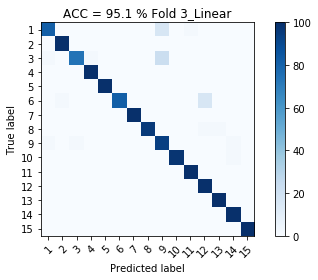

3it [01:51, 34.39s/it]

              precision    recall  f1-score   support

           1       0.95      0.82      0.88        50
           2       0.98      1.00      0.99        50
           3       0.97      0.74      0.84        50
           4       0.98      1.00      0.99        51
           5       1.00      1.00      1.00        51
           6       1.00      0.82      0.90        50
           7       1.00      1.00      1.00        51
           8       1.00      0.96      0.98        50
           9       0.71      0.94      0.81        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.85      1.00      0.92        50
          13       0.98      1.00      0.99        51
          14       0.96      1.00      0.98        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.96      0.95      0.95       754
weighted avg       0.96   

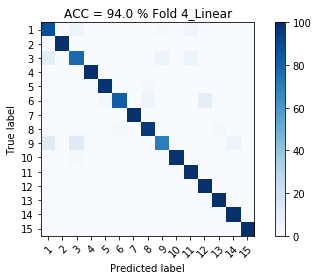

4it [02:36, 37.54s/it]

              precision    recall  f1-score   support

           1       0.80      0.88      0.84        50
           2       1.00      1.00      1.00        51
           3       0.80      0.78      0.79        51
           4       1.00      1.00      1.00        50
           5       0.98      0.98      0.98        50
           6       0.98      0.82      0.89        50
           7       1.00      1.00      1.00        51
           8       0.92      0.96      0.94        50
           9       0.90      0.70      0.79        50
          10       1.00      0.98      0.99        51
          11       0.91      1.00      0.95        50
          12       0.91      1.00      0.95        50
          13       0.98      1.00      0.99        50
          14       0.94      1.00      0.97        50
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

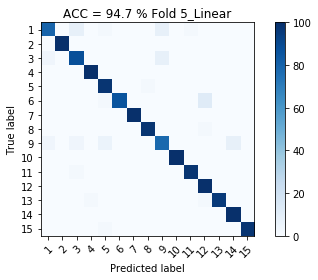

5it [03:18, 39.09s/it]

              precision    recall  f1-score   support

           1       0.91      0.80      0.85        50
           2       1.00      1.00      1.00        51
           3       0.86      0.88      0.87        50
           4       0.98      1.00      0.99        50
           5       0.89      0.98      0.93        50
           6       1.00      0.86      0.92        50
           7       1.00      1.00      1.00        51
           8       0.98      0.98      0.98        50
           9       0.83      0.78      0.80        50
          10       1.00      1.00      1.00        50
          11       0.98      0.98      0.98        50
          12       0.86      1.00      0.93        51
          13       1.00      0.96      0.98        50
          14       0.93      1.00      0.96        51
          15       1.00      0.98      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

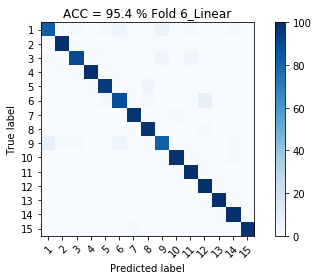

6it [04:01, 40.27s/it]

              precision    recall  f1-score   support

           1       0.89      0.82      0.86        51
           2       0.98      1.00      0.99        50
           3       0.96      0.90      0.93        51
           4       1.00      1.00      1.00        50
           5       0.96      0.96      0.96        50
           6       0.92      0.88      0.90        51
           7       0.98      0.98      0.98        50
           8       0.94      0.98      0.96        51
           9       0.89      0.82      0.85        50
          10       0.98      0.98      0.98        50
          11       0.94      1.00      0.97        50
          12       0.91      1.00      0.95        50
          13       1.00      1.00      1.00        50
          14       0.94      1.00      0.97        50
          15       1.00      0.98      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

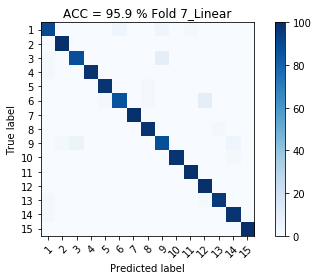

7it [04:45, 41.31s/it]

              precision    recall  f1-score   support

           1       0.92      0.90      0.91        51
           2       0.98      1.00      0.99        51
           3       0.94      0.88      0.91        50
           4       1.00      0.98      0.99        51
           5       0.98      0.98      0.98        50
           6       0.96      0.86      0.91        50
           7       1.00      1.00      1.00        51
           8       0.96      0.98      0.97        50
           9       0.86      0.88      0.87        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.89      1.00      0.94        50
          13       0.98      0.96      0.97        50
          14       0.94      0.98      0.96        50
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

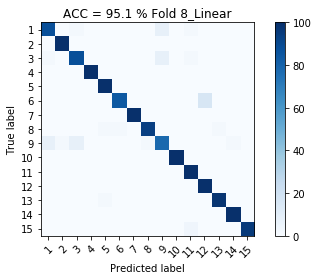

8it [05:28, 41.68s/it]

              precision    recall  f1-score   support

           1       0.90      0.88      0.89        50
           2       0.98      1.00      0.99        50
           3       0.90      0.88      0.89        50
           4       1.00      1.00      1.00        50
           5       0.96      1.00      0.98        50
           6       0.98      0.84      0.91        51
           7       1.00      1.00      1.00        50
           8       0.98      0.94      0.96        51
           9       0.83      0.78      0.80        50
          10       1.00      1.00      1.00        51
          11       0.93      1.00      0.96        50
          12       0.86      1.00      0.93        50
          13       0.98      0.98      0.98        51
          14       0.98      1.00      0.99        50
          15       1.00      0.96      0.98        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

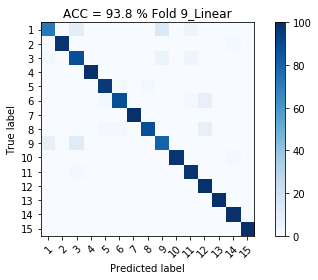

9it [05:56, 37.53s/it]

              precision    recall  f1-score   support

           1       0.88      0.72      0.79        50
           2       1.00      0.98      0.99        51
           3       0.79      0.88      0.83        50
           4       1.00      1.00      1.00        50
           5       0.96      0.96      0.96        50
           6       0.96      0.88      0.92        50
           7       1.00      1.00      1.00        50
           8       0.98      0.88      0.93        50
           9       0.80      0.80      0.80        51
          10       1.00      0.98      0.99        50
          11       0.91      0.98      0.94        50
          12       0.86      1.00      0.93        51
          13       1.00      1.00      1.00        50
          14       0.96      1.00      0.98        50
          15       1.00      1.00      1.00        51

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

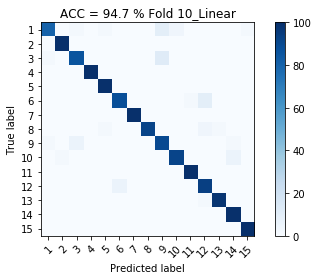

10it [06:39, 39.98s/it]
0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.95      0.80      0.87        51
           2       0.98      1.00      0.99        51
           3       0.91      0.86      0.89        50
           4       1.00      1.00      1.00        50
           5       0.96      1.00      0.98        50
           6       0.94      0.88      0.91        50
           7       1.00      1.00      1.00        50
           8       1.00      0.92      0.96        50
           9       0.80      0.90      0.85        50
          10       0.96      0.92      0.94        50
          11       0.98      1.00      0.99        51
          12       0.86      0.94      0.90        51
          13       0.98      0.98      0.98        50
          14       0.93      1.00      0.96        50
          15       0.98      1.00      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

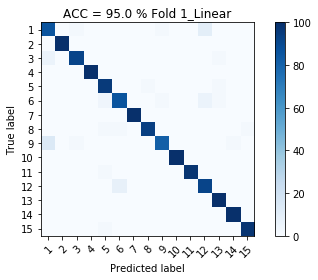

1it [00:45, 45.04s/it]

              precision    recall  f1-score   support

           1       0.81      0.86      0.83        50
           2       1.00      1.00      1.00        50
           3       0.96      0.92      0.94        50
           4       1.00      1.00      1.00        51
           5       0.91      0.96      0.93        50
           6       0.90      0.86      0.88        50
           7       1.00      1.00      1.00        51
           8       0.98      0.94      0.96        50
           9       0.95      0.82      0.88        50
          10       1.00      1.00      1.00        50
          11       1.00      0.98      0.99        51
          12       0.85      0.92      0.88        50
          13       0.94      1.00      0.97        51
          14       0.98      1.00      0.99        50
          15       0.98      0.98      0.98        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

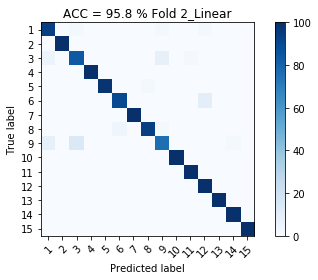

2it [01:35, 46.65s/it]

              precision    recall  f1-score   support

           1       0.87      0.94      0.90        50
           2       1.00      1.00      1.00        50
           3       0.84      0.84      0.84        50
           4       1.00      1.00      1.00        51
           5       1.00      0.98      0.99        50
           6       0.96      0.90      0.93        51
           7       1.00      1.00      1.00        50
           8       0.98      0.94      0.96        51
           9       0.86      0.76      0.81        50
          10       1.00      1.00      1.00        50
          11       0.98      1.00      0.99        50
          12       0.89      1.00      0.94        50
          13       1.00      1.00      1.00        50
          14       0.98      1.00      0.99        51
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

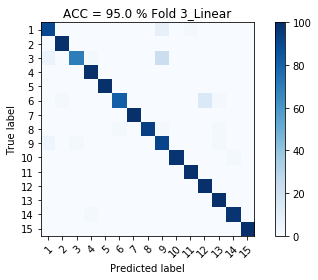

3it [02:05, 41.73s/it]

              precision    recall  f1-score   support

           1       0.90      0.90      0.90        50
           2       0.98      1.00      0.99        50
           3       0.97      0.70      0.81        50
           4       0.96      1.00      0.98        51
           5       1.00      1.00      1.00        51
           6       0.98      0.82      0.89        50
           7       1.00      1.00      1.00        51
           8       1.00      0.94      0.97        50
           9       0.74      0.92      0.82        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.88      1.00      0.93        50
          13       0.94      1.00      0.97        51
          14       0.98      0.98      0.98        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

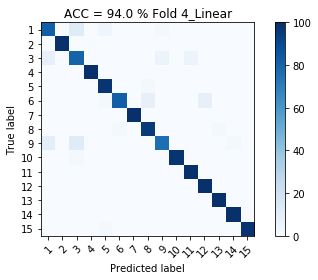

4it [02:36, 38.54s/it]

              precision    recall  f1-score   support

           1       0.82      0.82      0.82        50
           2       1.00      1.00      1.00        51
           3       0.76      0.80      0.78        51
           4       1.00      1.00      1.00        50
           5       0.92      0.98      0.95        50
           6       0.98      0.82      0.89        50
           7       1.00      1.00      1.00        51
           8       0.91      0.96      0.93        50
           9       0.90      0.76      0.83        50
          10       1.00      0.98      0.99        51
          11       0.94      1.00      0.97        50
          12       0.93      1.00      0.96        50
          13       0.98      1.00      0.99        50
          14       0.98      1.00      0.99        50
          15       1.00      0.98      0.99        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

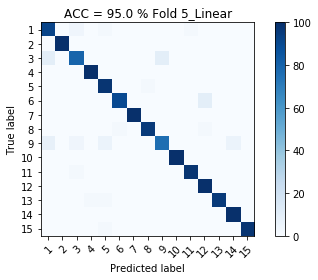

5it [03:08, 36.57s/it]

              precision    recall  f1-score   support

           1       0.84      0.92      0.88        50
           2       1.00      1.00      1.00        51
           3       0.89      0.80      0.84        50
           4       0.98      1.00      0.99        50
           5       0.89      0.98      0.93        50
           6       0.98      0.90      0.94        50
           7       1.00      1.00      1.00        51
           8       0.98      0.96      0.97        50
           9       0.88      0.76      0.82        50
          10       1.00      1.00      1.00        50
          11       0.98      0.98      0.98        50
          12       0.89      1.00      0.94        51
          13       1.00      0.96      0.98        50
          14       0.94      1.00      0.97        51
          15       1.00      0.98      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

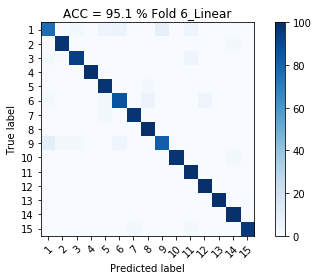

6it [04:09, 43.89s/it]

              precision    recall  f1-score   support

           1       0.85      0.76      0.80        51
           2       0.98      0.98      0.98        50
           3       0.96      0.94      0.95        51
           4       1.00      1.00      1.00        50
           5       0.92      0.98      0.95        50
           6       0.90      0.86      0.88        51
           7       0.98      0.98      0.98        50
           8       0.93      1.00      0.96        51
           9       0.91      0.82      0.86        50
          10       1.00      0.98      0.99        50
          11       0.91      1.00      0.95        50
          12       0.96      1.00      0.98        50
          13       1.00      1.00      1.00        50
          14       0.96      1.00      0.98        50
          15       1.00      0.96      0.98        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

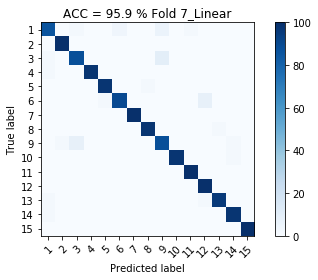

7it [05:01, 46.36s/it]

              precision    recall  f1-score   support

           1       0.92      0.86      0.89        51
           2       0.98      1.00      0.99        51
           3       0.90      0.88      0.89        50
           4       1.00      0.98      0.99        51
           5       0.98      0.98      0.98        50
           6       0.96      0.90      0.93        50
           7       1.00      1.00      1.00        51
           8       0.98      0.98      0.98        50
           9       0.85      0.88      0.86        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.91      1.00      0.95        50
          13       0.98      0.96      0.97        50
          14       0.96      0.98      0.97        50
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

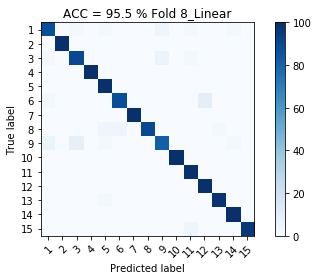

8it [05:48, 46.41s/it]

              precision    recall  f1-score   support

           1       0.90      0.88      0.89        50
           2       1.00      1.00      1.00        50
           3       0.90      0.90      0.90        50
           4       1.00      1.00      1.00        50
           5       0.91      1.00      0.95        50
           6       0.96      0.88      0.92        51
           7       1.00      1.00      1.00        50
           8       1.00      0.90      0.95        51
           9       0.89      0.82      0.85        50
          10       1.00      1.00      1.00        51
          11       0.93      1.00      0.96        50
          12       0.91      1.00      0.95        50
          13       0.98      0.98      0.98        51
          14       0.96      1.00      0.98        50
          15       1.00      0.96      0.98        50

    accuracy                           0.95       754
   macro avg       0.96      0.95      0.95       754
weighted avg       0.96   

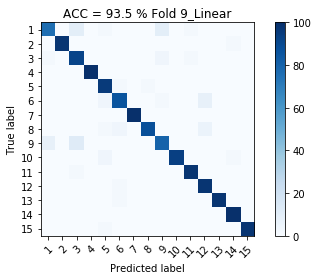

9it [06:35, 46.68s/it]

              precision    recall  f1-score   support

           1       0.88      0.76      0.82        50
           2       1.00      0.98      0.99        51
           3       0.79      0.92      0.85        50
           4       1.00      1.00      1.00        50
           5       0.87      0.96      0.91        50
           6       0.90      0.86      0.88        50
           7       1.00      1.00      1.00        50
           8       0.98      0.88      0.93        50
           9       0.84      0.80      0.82        51
          10       1.00      0.94      0.97        50
          11       0.96      0.98      0.97        50
          12       0.88      0.98      0.93        51
          13       1.00      0.98      0.99        50
          14       0.96      1.00      0.98        50
          15       1.00      0.98      0.99        51

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.93       754
weighted avg       0.94   

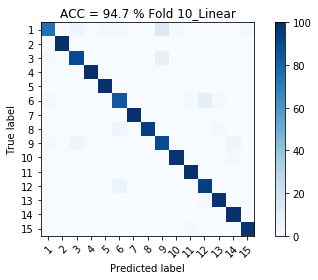

10it [07:32, 45.28s/it]
0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.93      0.75      0.83        51
           2       1.00      1.00      1.00        51
           3       0.92      0.90      0.91        50
           4       1.00      1.00      1.00        50
           5       0.98      1.00      0.99        50
           6       0.88      0.84      0.86        50
           7       1.00      1.00      1.00        50
           8       1.00      0.94      0.97        50
           9       0.80      0.90      0.85        50
          10       0.98      0.98      0.98        50
          11       0.96      1.00      0.98        51
          12       0.89      0.94      0.91        51
          13       0.96      0.98      0.97        50
          14       0.94      1.00      0.97        50
          15       0.98      0.98      0.98        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

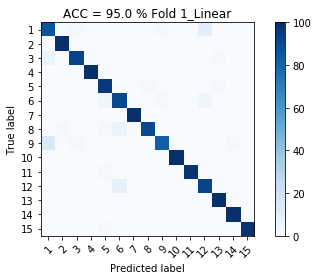

1it [00:47, 47.17s/it]

              precision    recall  f1-score   support

           1       0.81      0.86      0.83        50
           2       0.98      1.00      0.99        50
           3       0.96      0.92      0.94        50
           4       1.00      1.00      1.00        51
           5       0.91      0.96      0.93        50
           6       0.87      0.90      0.88        50
           7       1.00      1.00      1.00        51
           8       0.98      0.90      0.94        50
           9       0.95      0.82      0.88        50
          10       1.00      1.00      1.00        50
          11       1.00      0.98      0.99        51
          12       0.87      0.92      0.89        50
          13       0.96      1.00      0.98        51
          14       0.98      1.00      0.99        50
          15       1.00      0.98      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

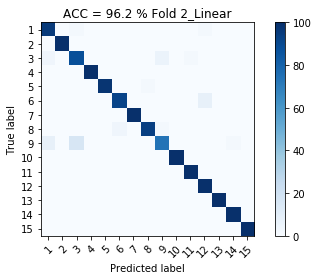

2it [01:35, 47.50s/it]

              precision    recall  f1-score   support

           1       0.89      0.96      0.92        50
           2       1.00      1.00      1.00        50
           3       0.83      0.88      0.85        50
           4       1.00      1.00      1.00        51
           5       1.00      0.98      0.99        50
           6       0.96      0.92      0.94        51
           7       1.00      1.00      1.00        50
           8       0.98      0.94      0.96        51
           9       0.90      0.74      0.81        50
          10       1.00      1.00      1.00        50
          11       0.98      1.00      0.99        50
          12       0.91      1.00      0.95        50
          13       1.00      1.00      1.00        50
          14       0.98      1.00      0.99        51
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

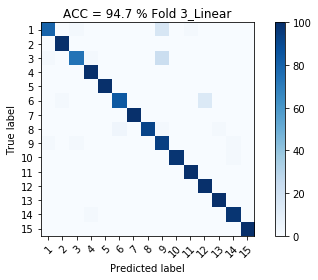

3it [02:04, 42.05s/it]

              precision    recall  f1-score   support

           1       0.95      0.80      0.87        50
           2       0.98      1.00      0.99        50
           3       0.95      0.74      0.83        50
           4       0.96      1.00      0.98        51
           5       1.00      1.00      1.00        51
           6       0.95      0.84      0.89        50
           7       1.00      1.00      1.00        51
           8       1.00      0.92      0.96        50
           9       0.70      0.94      0.80        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.88      1.00      0.93        50
          13       0.98      1.00      0.99        51
          14       0.96      0.98      0.97        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

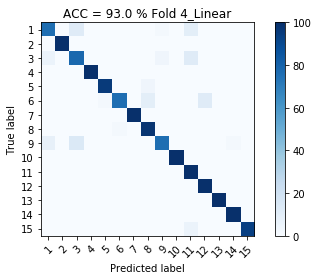

4it [02:33, 38.06s/it]

              precision    recall  f1-score   support

           1       0.84      0.76      0.80        50
           2       1.00      1.00      1.00        51
           3       0.75      0.78      0.77        51
           4       1.00      1.00      1.00        50
           5       0.98      0.96      0.97        50
           6       0.97      0.76      0.85        50
           7       1.00      1.00      1.00        51
           8       0.88      0.98      0.92        50
           9       0.93      0.76      0.84        50
          10       1.00      1.00      1.00        51
          11       0.78      1.00      0.88        50
          12       0.89      1.00      0.94        50
          13       1.00      1.00      1.00        50
          14       0.98      1.00      0.99        50
          15       1.00      0.94      0.97        50

    accuracy                           0.93       754
   macro avg       0.93      0.93      0.93       754
weighted avg       0.93   

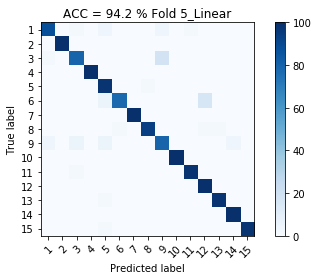

5it [03:02, 35.39s/it]

              precision    recall  f1-score   support

           1       0.94      0.88      0.91        50
           2       1.00      1.00      1.00        51
           3       0.89      0.80      0.84        50
           4       1.00      1.00      1.00        50
           5       0.83      0.98      0.90        50
           6       0.97      0.78      0.87        50
           7       1.00      1.00      1.00        51
           8       0.98      0.94      0.96        50
           9       0.78      0.80      0.79        50
          10       1.00      1.00      1.00        50
          11       0.98      0.98      0.98        50
          12       0.85      1.00      0.92        51
          13       0.98      0.98      0.98        50
          14       0.96      1.00      0.98        51
          15       1.00      0.98      0.99        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

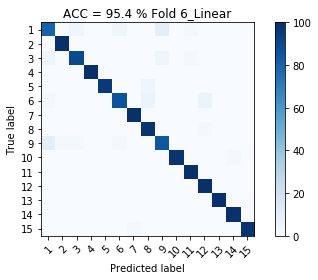

6it [03:51, 39.27s/it]

              precision    recall  f1-score   support

           1       0.84      0.80      0.82        51
           2       0.98      1.00      0.99        50
           3       0.94      0.90      0.92        51
           4       1.00      1.00      1.00        50
           5       1.00      0.96      0.98        50
           6       0.94      0.86      0.90        51
           7       0.98      1.00      0.99        50
           8       0.91      0.98      0.94        51
           9       0.86      0.84      0.85        50
          10       1.00      0.98      0.99        50
          11       0.96      1.00      0.98        50
          12       0.93      1.00      0.96        50
          13       1.00      1.00      1.00        50
          14       0.98      1.00      0.99        50
          15       1.00      0.98      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

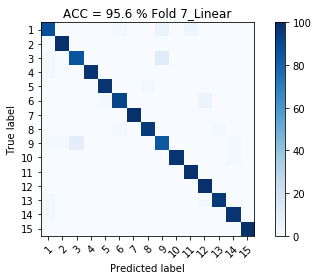

7it [04:42, 42.79s/it]

              precision    recall  f1-score   support

           1       0.90      0.88      0.89        51
           2       0.98      1.00      0.99        51
           3       0.90      0.86      0.88        50
           4       1.00      0.98      0.99        51
           5       0.98      0.98      0.98        50
           6       0.96      0.92      0.94        50
           7       1.00      1.00      1.00        51
           8       0.98      0.96      0.97        50
           9       0.82      0.84      0.83        50
          10       1.00      0.98      0.99        50
          11       0.96      1.00      0.98        50
          12       0.93      1.00      0.96        50
          13       0.98      0.96      0.97        50
          14       0.96      0.98      0.97        50
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

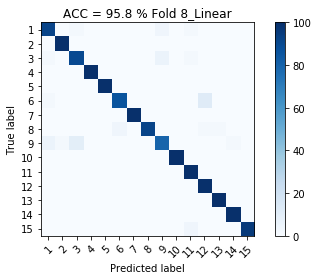

8it [05:30, 44.45s/it]

              precision    recall  f1-score   support

           1       0.90      0.92      0.91        50
           2       0.98      1.00      0.99        50
           3       0.88      0.90      0.89        50
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        50
           6       0.96      0.86      0.91        51
           7       1.00      1.00      1.00        50
           8       1.00      0.92      0.96        51
           9       0.89      0.80      0.84        50
          10       1.00      1.00      1.00        51
          11       0.93      1.00      0.96        50
          12       0.88      1.00      0.93        50
          13       0.98      1.00      0.99        51
          14       0.98      1.00      0.99        50
          15       1.00      0.96      0.98        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

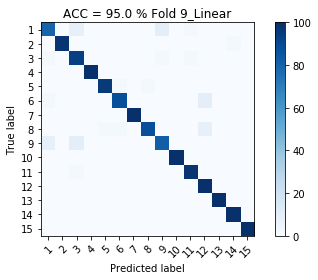

9it [06:18, 45.61s/it]

              precision    recall  f1-score   support

           1       0.87      0.80      0.83        50
           2       1.00      0.98      0.99        51
           3       0.82      0.94      0.88        50
           4       1.00      1.00      1.00        50
           5       0.98      0.96      0.97        50
           6       0.96      0.88      0.92        50
           7       1.00      1.00      1.00        50
           8       0.98      0.88      0.93        50
           9       0.88      0.82      0.85        51
          10       1.00      1.00      1.00        50
          11       0.96      0.98      0.97        50
          12       0.85      1.00      0.92        51
          13       1.00      1.00      1.00        50
          14       0.98      1.00      0.99        50
          15       1.00      1.00      1.00        51

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

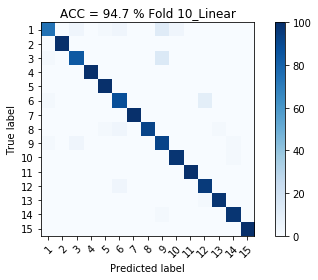

10it [07:24, 44.49s/it]
0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.93      0.75      0.83        51
           2       1.00      1.00      1.00        51
           3       0.91      0.84      0.87        50
           4       1.00      1.00      1.00        50
           5       0.96      1.00      0.98        50
           6       0.88      0.88      0.88        50
           7       1.00      1.00      1.00        50
           8       1.00      0.92      0.96        50
           9       0.77      0.92      0.84        50
          10       0.96      0.98      0.97        50
          11       1.00      1.00      1.00        51
          12       0.89      0.96      0.92        51
          13       0.98      0.98      0.98        50
          14       0.96      0.98      0.97        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

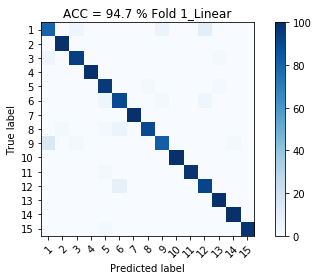

1it [01:13, 73.00s/it]

              precision    recall  f1-score   support

           1       0.82      0.80      0.81        50
           2       0.98      1.00      0.99        50
           3       0.94      0.94      0.94        50
           4       1.00      1.00      1.00        51
           5       0.91      0.96      0.93        50
           6       0.87      0.90      0.88        50
           7       1.00      1.00      1.00        51
           8       0.98      0.90      0.94        50
           9       0.91      0.82      0.86        50
          10       1.00      1.00      1.00        50
          11       1.00      0.98      0.99        51
          12       0.87      0.92      0.89        50
          13       0.96      1.00      0.98        51
          14       0.98      1.00      0.99        50
          15       1.00      0.98      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

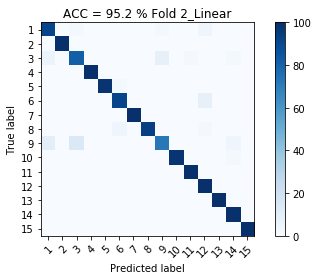

2it [02:03, 66.15s/it]

              precision    recall  f1-score   support

           1       0.85      0.92      0.88        50
           2       1.00      1.00      1.00        50
           3       0.84      0.82      0.83        50
           4       1.00      1.00      1.00        51
           5       1.00      0.98      0.99        50
           6       0.94      0.92      0.93        51
           7       1.00      1.00      1.00        50
           8       1.00      0.94      0.97        51
           9       0.88      0.72      0.79        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.88      1.00      0.93        50
          13       1.00      1.00      1.00        50
          14       0.93      1.00      0.96        51
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

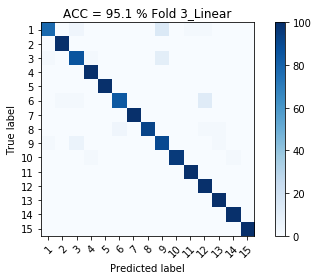

3it [02:58, 62.87s/it]

              precision    recall  f1-score   support

           1       0.95      0.78      0.86        50
           2       0.98      1.00      0.99        50
           3       0.88      0.86      0.87        50
           4       0.96      1.00      0.98        51
           5       1.00      1.00      1.00        51
           6       0.95      0.84      0.89        50
           7       1.00      1.00      1.00        51
           8       1.00      0.92      0.96        50
           9       0.79      0.90      0.84        50
          10       1.00      0.96      0.98        50
          11       0.98      1.00      0.99        50
          12       0.86      1.00      0.93        50
          13       0.96      1.00      0.98        51
          14       0.98      1.00      0.99        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

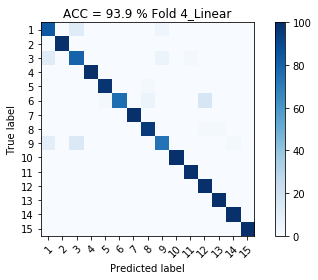

4it [03:51, 59.89s/it]

              precision    recall  f1-score   support

           1       0.79      0.84      0.82        50
           2       1.00      1.00      1.00        51
           3       0.76      0.80      0.78        51
           4       1.00      1.00      1.00        50
           5       0.98      0.98      0.98        50
           6       1.00      0.76      0.86        50
           7       1.00      1.00      1.00        51
           8       0.92      0.96      0.94        50
           9       0.88      0.74      0.80        50
          10       1.00      1.00      1.00        51
          11       0.98      1.00      0.99        50
          12       0.85      1.00      0.92        50
          13       0.98      1.00      0.99        50
          14       0.98      1.00      0.99        50
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

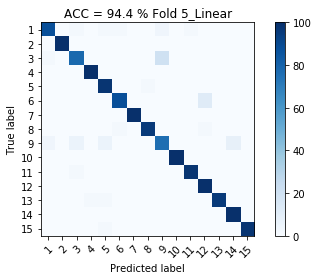

5it [05:03, 63.46s/it]

              precision    recall  f1-score   support

           1       0.94      0.88      0.91        50
           2       1.00      1.00      1.00        51
           3       0.89      0.78      0.83        50
           4       0.98      1.00      0.99        50
           5       0.89      0.98      0.93        50
           6       0.96      0.88      0.92        50
           7       1.00      1.00      1.00        51
           8       0.98      0.96      0.97        50
           9       0.76      0.76      0.76        50
          10       1.00      1.00      1.00        50
          11       0.98      0.98      0.98        50
          12       0.88      1.00      0.94        51
          13       1.00      0.96      0.98        50
          14       0.93      1.00      0.96        51
          15       1.00      0.98      0.99        50

    accuracy                           0.94       754
   macro avg       0.95      0.94      0.94       754
weighted avg       0.95   

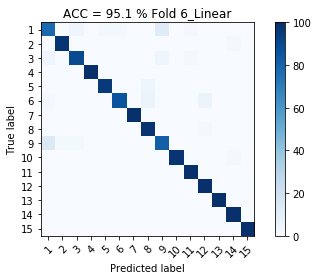

6it [05:54, 59.91s/it]

              precision    recall  f1-score   support

           1       0.80      0.78      0.79        51
           2       0.98      0.98      0.98        50
           3       0.94      0.90      0.92        51
           4       1.00      1.00      1.00        50
           5       0.98      0.96      0.97        50
           6       0.98      0.86      0.92        51
           7       1.00      1.00      1.00        50
           8       0.91      0.98      0.94        51
           9       0.84      0.82      0.83        50
          10       1.00      0.98      0.99        50
          11       0.96      1.00      0.98        50
          12       0.93      1.00      0.96        50
          13       1.00      1.00      1.00        50
          14       0.96      1.00      0.98        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

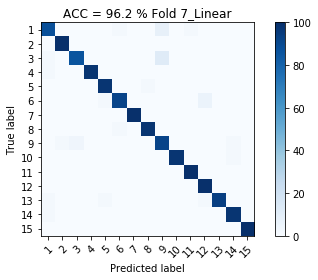

7it [06:49, 58.46s/it]

              precision    recall  f1-score   support

           1       0.92      0.88      0.90        51
           2       0.98      1.00      0.99        51
           3       0.96      0.86      0.91        50
           4       1.00      0.98      0.99        51
           5       0.96      0.98      0.97        50
           6       0.96      0.92      0.94        50
           7       1.00      1.00      1.00        51
           8       0.98      0.98      0.98        50
           9       0.82      0.92      0.87        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.93      1.00      0.96        50
          13       1.00      0.94      0.97        50
          14       0.96      0.98      0.97        50
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

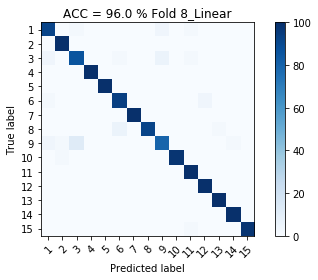

8it [07:20, 50.15s/it]

              precision    recall  f1-score   support

           1       0.90      0.92      0.91        50
           2       0.96      1.00      0.98        50
           3       0.86      0.86      0.86        50
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        50
           6       0.92      0.94      0.93        51
           7       1.00      1.00      1.00        50
           8       1.00      0.92      0.96        51
           9       0.89      0.80      0.84        50
          10       1.00      0.98      0.99        51
          11       0.94      1.00      0.97        50
          12       0.96      1.00      0.98        50
          13       0.98      1.00      0.99        51
          14       0.98      1.00      0.99        50
          15       1.00      0.98      0.99        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

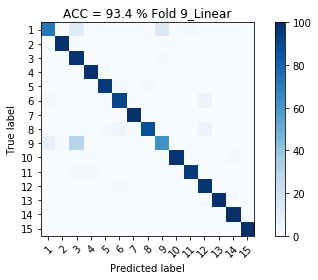

9it [08:10, 50.02s/it]

              precision    recall  f1-score   support

           1       0.88      0.72      0.79        50
           2       1.00      1.00      1.00        51
           3       0.69      0.98      0.81        50
           4       0.98      1.00      0.99        50
           5       0.98      0.96      0.97        50
           6       0.92      0.92      0.92        50
           7       1.00      1.00      1.00        50
           8       0.98      0.88      0.93        50
           9       0.80      0.63      0.70        51
          10       1.00      0.98      0.99        50
          11       0.98      0.96      0.97        50
          12       0.89      0.98      0.93        51
          13       1.00      1.00      1.00        50
          14       0.98      1.00      0.99        50
          15       1.00      1.00      1.00        51

    accuracy                           0.93       754
   macro avg       0.94      0.93      0.93       754
weighted avg       0.94   

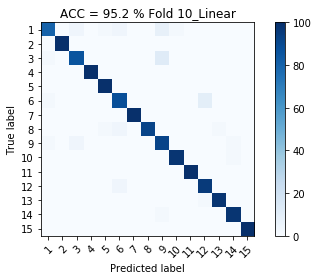

10it [09:00, 54.05s/it]
0it [00:00, ?it/s]

              precision    recall  f1-score   support

           1       0.93      0.80      0.86        51
           2       1.00      1.00      1.00        51
           3       0.91      0.86      0.89        50
           4       1.00      1.00      1.00        50
           5       0.96      1.00      0.98        50
           6       0.88      0.88      0.88        50
           7       1.00      1.00      1.00        50
           8       1.00      0.92      0.96        50
           9       0.81      0.92      0.86        50
          10       0.98      0.98      0.98        50
          11       1.00      1.00      1.00        51
          12       0.89      0.96      0.92        51
          13       0.98      0.98      0.98        50
          14       0.96      0.98      0.97        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

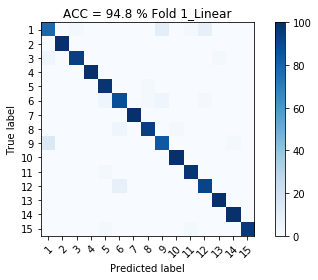

1it [00:52, 52.04s/it]

              precision    recall  f1-score   support

           1       0.81      0.78      0.80        50
           2       1.00      1.00      1.00        50
           3       0.98      0.94      0.96        50
           4       1.00      1.00      1.00        51
           5       0.92      0.98      0.95        50
           6       0.88      0.88      0.88        50
           7       1.00      1.00      1.00        51
           8       0.96      0.94      0.95        50
           9       0.86      0.84      0.85        50
          10       0.98      1.00      0.99        50
          11       0.96      0.98      0.97        51
          12       0.90      0.92      0.91        50
          13       0.98      1.00      0.99        51
          14       0.98      1.00      0.99        50
          15       1.00      0.96      0.98        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

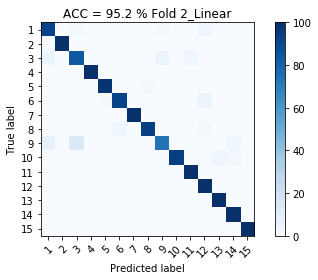

2it [01:47, 53.13s/it]

              precision    recall  f1-score   support

           1       0.87      0.92      0.89        50
           2       1.00      1.00      1.00        50
           3       0.84      0.84      0.84        50
           4       1.00      1.00      1.00        51
           5       0.98      0.98      0.98        50
           6       0.96      0.92      0.94        51
           7       1.00      1.00      1.00        50
           8       0.98      0.94      0.96        51
           9       0.90      0.74      0.81        50
          10       1.00      0.94      0.97        50
          11       0.96      1.00      0.98        50
          12       0.89      1.00      0.94        50
          13       0.96      1.00      0.98        50
          14       0.94      1.00      0.97        51
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

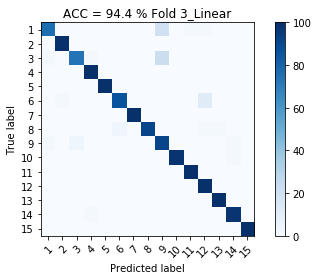

3it [02:20, 46.90s/it]

              precision    recall  f1-score   support

           1       0.95      0.76      0.84        50
           2       0.98      1.00      0.99        50
           3       0.95      0.74      0.83        50
           4       0.96      1.00      0.98        51
           5       1.00      1.00      1.00        51
           6       0.96      0.86      0.91        50
           7       1.00      1.00      1.00        51
           8       1.00      0.92      0.96        50
           9       0.69      0.92      0.79        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.86      1.00      0.93        50
          13       0.98      1.00      0.99        51
          14       0.96      0.98      0.97        50
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.95      0.94      0.94       754
weighted avg       0.95   

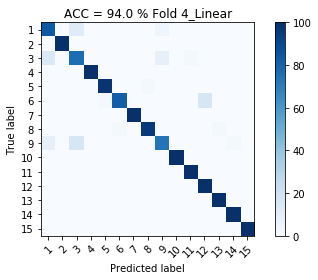

4it [03:28, 53.47s/it]

              precision    recall  f1-score   support

           1       0.79      0.84      0.82        50
           2       1.00      1.00      1.00        51
           3       0.74      0.76      0.75        51
           4       1.00      1.00      1.00        50
           5       0.98      0.98      0.98        50
           6       0.98      0.82      0.89        50
           7       1.00      1.00      1.00        51
           8       0.98      0.96      0.97        50
           9       0.86      0.74      0.80        50
          10       1.00      1.00      1.00        51
          11       0.98      1.00      0.99        50
          12       0.86      1.00      0.93        50
          13       0.98      1.00      0.99        50
          14       0.98      1.00      0.99        50
          15       1.00      1.00      1.00        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

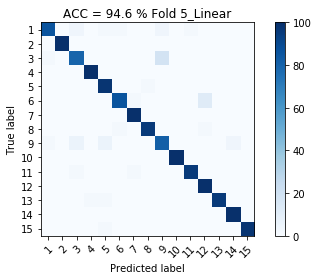

5it [04:24, 54.05s/it]

              precision    recall  f1-score   support

           1       0.96      0.86      0.91        50
           2       1.00      1.00      1.00        51
           3       0.87      0.80      0.83        50
           4       0.98      1.00      0.99        50
           5       0.89      0.98      0.93        50
           6       0.96      0.86      0.91        50
           7       0.96      1.00      0.98        51
           8       0.98      0.96      0.97        50
           9       0.79      0.82      0.80        50
          10       1.00      1.00      1.00        50
          11       0.98      0.96      0.97        50
          12       0.88      1.00      0.94        51
          13       1.00      0.96      0.98        50
          14       0.96      1.00      0.98        51
          15       1.00      0.98      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

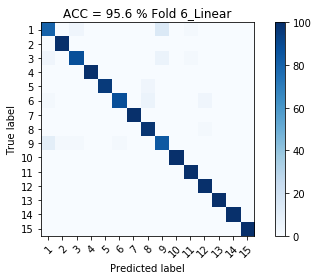

6it [05:18, 54.03s/it]

              precision    recall  f1-score   support

           1       0.84      0.80      0.82        51
           2       0.98      1.00      0.99        50
           3       0.94      0.88      0.91        51
           4       1.00      1.00      1.00        50
           5       1.00      0.96      0.98        50
           6       0.98      0.88      0.93        51
           7       1.00      1.00      1.00        50
           8       0.91      0.98      0.94        51
           9       0.81      0.84      0.82        50
          10       1.00      1.00      1.00        50
          11       0.96      1.00      0.98        50
          12       0.94      1.00      0.97        50
          13       1.00      1.00      1.00        50
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

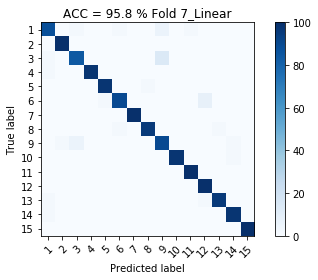

7it [06:12, 54.16s/it]

              precision    recall  f1-score   support

           1       0.92      0.88      0.90        51
           2       0.98      1.00      0.99        51
           3       0.91      0.84      0.87        50
           4       1.00      0.98      0.99        51
           5       0.98      0.98      0.98        50
           6       0.96      0.90      0.93        50
           7       1.00      1.00      1.00        51
           8       0.98      0.96      0.97        50
           9       0.82      0.90      0.86        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.91      1.00      0.95        50
          13       0.98      0.96      0.97        50
          14       0.96      0.98      0.97        50
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

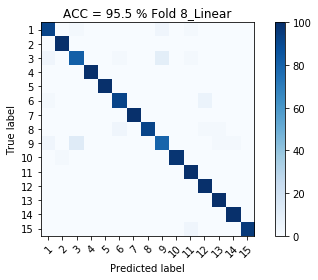

8it [07:03, 53.25s/it]

              precision    recall  f1-score   support

           1       0.90      0.92      0.91        50
           2       0.98      1.00      0.99        50
           3       0.85      0.82      0.84        50
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        50
           6       0.94      0.92      0.93        51
           7       1.00      1.00      1.00        50
           8       1.00      0.92      0.96        51
           9       0.85      0.80      0.82        50
          10       1.00      0.98      0.99        51
          11       0.93      1.00      0.96        50
          12       0.93      1.00      0.96        50
          13       0.96      1.00      0.98        51
          14       0.98      1.00      0.99        50
          15       1.00      0.96      0.98        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

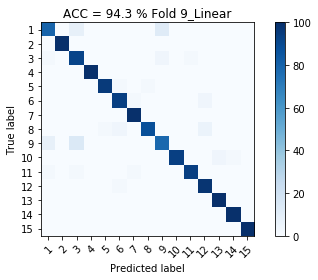

9it [07:56, 53.01s/it]

              precision    recall  f1-score   support

           1       0.87      0.80      0.83        50
           2       1.00      1.00      1.00        51
           3       0.79      0.92      0.85        50
           4       1.00      1.00      1.00        50
           5       0.98      0.96      0.97        50
           6       0.92      0.94      0.93        50
           7       0.96      1.00      0.98        50
           8       0.98      0.88      0.93        50
           9       0.83      0.78      0.81        51
          10       1.00      0.94      0.97        50
          11       0.98      0.94      0.96        50
          12       0.91      0.98      0.94        51
          13       0.96      1.00      0.98        50
          14       0.98      1.00      0.99        50
          15       1.00      1.00      1.00        51

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

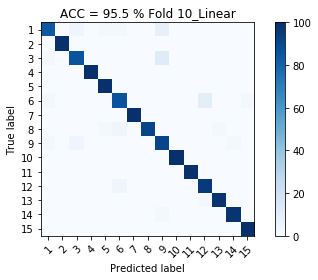

10it [08:59, 53.97s/it]

              precision    recall  f1-score   support

           1       0.93      0.84      0.89        51
           2       1.00      1.00      1.00        51
           3       0.91      0.86      0.89        50
           4       1.00      1.00      1.00        50
           5       0.96      1.00      0.98        50
           6       0.90      0.86      0.88        50
           7       1.00      1.00      1.00        50
           8       1.00      0.92      0.96        50
           9       0.81      0.92      0.86        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        51
          12       0.89      0.96      0.92        51
          13       0.98      0.98      0.98        50
          14       0.98      0.98      0.98        50
          15       0.98      1.00      0.99        50

    accuracy                           0.95       754
   macro avg       0.96      0.95      0.95       754
weighted avg       0.96   

In [ ]:
# Traininig/Testing loop

for feature in range(0,len(ftr_vec)): # For loop over regions
  print("Region = ", str(feature+1) +'/'+ str(21))
  fold = 0
  # Initializa variables
  train_idx    = []
  test_idx     = []
  cm_L         = np.zeros((n_partitions,n_classes,n_classes))
  cr_L         = []
  best_mod_L   = []
  best_pms_L   = []
  for train_index, test_index in tqdm(sss.split(X,y)):
      # Training/testing index storage
      train_idx += [train_index]
      test_idx  += [test_index]
      
      # Number of partitions flag
      fold = fold + 1
      print("Iteration = ", str(fold) +'/'+ str(n_partitions))
      
      # Iteration file name 
      filename = img_path + "/Fold" + str(fold) + "Region" + str(feature+1)

      # Train/Test partition and matrix storing to apply CKA over them for 
      # visualization
      X_train, X_test = X[train_index,0:ftr_vec[feature]], X[test_index,0:ftr_vec[feature]]
      y_train, y_test = y[train_index], y[test_index]

      # ---------------------------------------------------------------------------------------------------------------------------
      # Training
      
      # Linear
      print('Linear Model')
      # Using GridSearchCV 
      hs_Lineal = GridSearchCV(Pipeline(steps[0]), parameters[0], n_jobs = 25, cv = 5, scoring = 'balanced_accuracy', verbose = 50)
      # Using RandomizedSearchCV
      # hs_Lineal = RandomizedSearchCV(Pipeline(steps[0]), param_distributions=parameters[0],n_iter=10, cv=5, iid=False, n_jobs=2)
      hs_Lineal.fit(X_train,y_train)
      # Projection matrix from CKA
      # W_cka_L += [hs_Lineal.best_estimator_.named_steps['Projection'].Wcka]


      # ---------------------------------------------------------------------------------------------------------------------------
      # Validation
      
      # Linear
      y_pred_L           = hs_Lineal.best_estimator_.predict(X_test)
      accuracy_L[fold-1,feature] = accuracy_score(y_test,y_pred_L)
      cm_temp            = confusion_matrix(y_test,y_pred_L)
      cm_L[fold-1,:,:]   = 100*cm_temp.astype('float') / cm_temp.sum(axis=1)[:, np.newaxis]
      plot_confusion_matrix(y_test, y_pred_L, classes=np.unique(y),normalize=True,title='ACC = %.1f %% Fold %d' % (100*accuracy_L[fold-1,feature],fold) + '_'+ label_models[0])
      plt.autoscale()
      save_fig(img_path,label_models[0]+'_Fold'+str(fold)+ "Region" + str(feature+1))                      
      plt.show()
      cr_L += [classification_report(y_test,y_pred_L)]
      print(cr_L[-1])
      # Best model storage
      # best_mod_L += [hs_Lineal.best_estimator_, accuracy_L,cm_L,cr_L, sel_fts_L]
      # best_mod_L += [hs_Lineal.best_estimator_]
      # best_pms_L += [hs_Lineal.best_params_,accuracy_L,cm_L,cr_L,W_cka_L]
      best_pms_L += [hs_Lineal.best_params_]
      # joblib.dump(best_pms_L, filename + "LinealCKA" + ".pkl")

  # Results dictionary creation
  L_dict = {'accuracy_L': accuracy_L,
            'cm_L': cm_L,
            'cr_L': cr_L,
            'best_pms_L':best_pms_L}

  Results = [L_dict]

  joblib.dump(Results, rslt_dir + "Region" + str(feature+1) +".pkl")

([<matplotlib.axis.XTick at 0x7fc290070c50>,
 <a list of 21 Text xticklabel objects>)

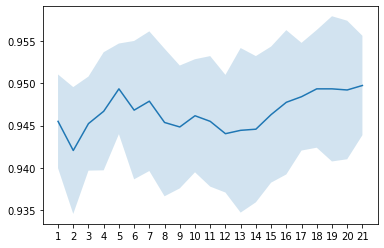

In [ ]:
# Get mean and standard deviation vectors 
mean_vec_l    = np.mean(Results[0]['accuracy_L'], axis = 0)
std_vec_l     = np.std(Results[0]['accuracy_L'], axis = 0)
# mean_vec_lr   = np.mean(Results[1]['accuracy_LogR'], axis = 0)
# std_vec_lr    = np.std(Results[1]['accuracy_LogR'], axis = 0)
# mean_vec_lsvm = np.mean(Results[2]['accuracy_lSVM'], axis = 0)
# std_vec_lsvm  = np.std(Results[2]['accuracy_lSVM'], axis = 0)
reg_vec  = np.arange(1,22,1)

# Plotting
plt.figure()
plt.plot(reg_vec,mean_vec_l)
plt.fill_between(reg_vec, mean_vec_l-std_vec_l, mean_vec_l+std_vec_l, alpha=0.2)
# plt.ylim(0.7,0.9)
# # plt.plot(reg_vec,mean_vec_lr)
# # plt.fill_between(reg_vec, mean_vec_lr-std_vec_lr, mean_vec_lr+std_vec_lr, alpha=0.2)
# # plt.plot(reg_vec,mean_vec_lsvm)
# # plt.fill_between(reg_vec, mean_vec_lsvm-std_vec_lsvm, mean_vec_lsvm+std_vec_lsvm, alpha=0.2)
plt.xticks(reg_vec, reg_vec)

In [ ]:
# Storing the data
Data = np.c_[reg_vec.reshape(1,-1).T,mean_vec_l.T,std_vec_l.T]
np.savetxt(img_path + '/SLDBRSL.dat', Data, delimiter='   ')

In [ ]:
# Computing optimal number of regiones acording to target
Results      = np.loadtxt(img_path + 'SLDBRSL.dat')
# Normalizing the number of regions
Results[:,0] = Results[:,0] - min(Results[:,0])
Results[:,0] = Results[:,0]/max(Results[:,0])
# Normalizing the accuracy
Results[:,1] = Results[:,1] - min(Results[:,1])
Results[:,1] = Results[:,1]/max(Results[:,1])
# Normalizing the standard deviation
Results[:,2] = Results[:,2] - min(Results[:,2])
Results[:,2] = Results[:,2]/max(Results[:,2])
# Ideal result
Target       = np.array((0,1,0))
# Computing the minimum distance between the ideal result and our results
dist         = cdist(Target.reshape(1,-1),Results, 'euclidean')
# Showing the optimum number of regions
print('The ideal number of regions is: ' + str((np.argmin(dist)+1)))

The ideal number of regions is: 5


# **Step 6: Projecting the selected regions using CKA**

In [ ]:
# Selecting the regions to project
X       = X[:,0:7500]

In [ ]:
# Variable declaration
n_partitions = 10
test_per     = 0.67
n_classes    = len(np.unique(y))
fold         = 0
train_idx    = []
test_idx     = []
alpha_L      = []
alpha_LogR   = []
alpha_lSVM   = []
sel_fts_L    = []
sel_fts_LogR = []
sel_fts_lSVM = []
thld_L       = []
thld_LogR    = []
thld_lSVM    = []
sel_fts_Lt   = []
sel_fts_LogRt= []
sel_fts_lSVMt= []
nfeats_L     = []
nfeats_LogR  = []
nfeats_lSVM  = []
accuracy_L   = np.zeros((n_partitions))
accuracy_LogR= np.zeros((n_partitions))
accuracy_lSVM= np.zeros((n_partitions))
cm_L         = np.zeros((n_partitions,n_classes,n_classes))
cm_LogR      = np.zeros((n_partitions,n_classes,n_classes))
cm_lSVM      = np.zeros((n_partitions,n_classes,n_classes))
cr_L         = []
cr_LogR      = []
cr_lSVM      = []
best_mod_L   = []
best_mod_LogR= []
best_mod_lSVM= []
best_pms_L   = []
best_pms_LogR= []
best_pms_lSVM= [] 

In [ ]:
# Setting the data partition scheme to work like HoldOut validation
sss = StratifiedShuffleSplit(n_splits = n_partitions, test_size = test_per, random_state=42)

In [ ]:
# Matrix declaration to store train/test matrices and their labels, and projection matrices from CKA
X_train_cka = []
X_test_cka  = []
y_train_cka = []
y_test_cka  = []
W_cka_L     = []
W_cka_LogR  = []
W_cka_lSVM  = []
    
# Step declaration
steps = [
        [('Preprocessing', StandardScaler()),
          ('Projection', MiniBatchCKA(Q = 0.95)),
          ('Preprocessing2',StandardScaler()),
          ('Classification',SGDClassifier())],      # Clasificador Lineal
        [('Preprocessing', StandardScaler()),
          ('Projection', MiniBatchCKA(Q = 0.95)),
          ('Preprocessing2',StandardScaler()),
          ('Classification',LogisticRegression())], # Regresion Logistica
        [('Preprocessing', StandardScaler()),
          ('Projection', MiniBatchCKA(Q = 0.95)),
          ('Preprocessing2',StandardScaler()),
          ('Classification',LinearSVC())],          # Maquina de Vectores de Soporte
        ]
    
# Grid declaration
parameters = [
            {'Classification__penalty': ['l1', 'l2', 'elasticnet'] },
            {'Classification__C': [0.01,0.1,1,10]},
            {'Classification__C': [0.1,1,10,100,1000]}
            ]

# Model labels
label_models = ['LinearCKA','LogisticRegressionCKA','LinearSVCKA']

In [ ]:
# Directory to save results and plots
rslt_dir     = img_dir + '/RegionSelection/ReliefF_CKA_RS_BoCF/Results_ReliefF_CKA_RS_BoCF_Py'
sys.path.append(rslt_dir)
img_path     = img_dir + '/RegionSelection/ReliefF_CKA_RS_BoCF/'
sys.path.append(img_path)

Loop to optimize CKA projection


0it [00:00, ?it/s]

Iteration =  1/10
Linear Model
it:1/50---cost:-1.66e+00--- elapsed:6.91 [s]



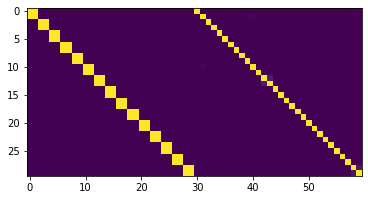

Logistic Regression Model
it:1/50---cost:-1.65e+00--- elapsed:7.21 [s]



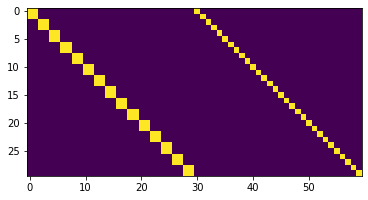

Linear SVM Model
it:1/50---cost:-1.66e+00--- elapsed:6.79 [s]



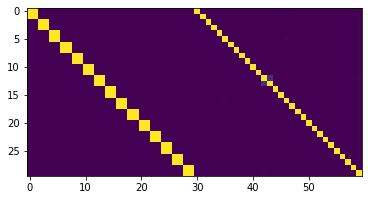

Guardando... LinearCKA_Fold1


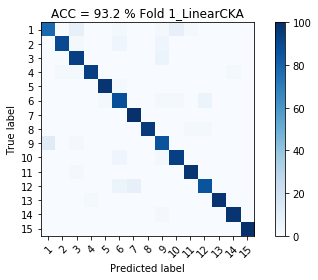

              precision    recall  f1-score   support

           1       0.87      0.78      0.82        50
           2       0.98      0.90      0.94        50
           3       0.85      0.94      0.90        50
           4       0.98      0.94      0.96        51
           5       0.98      0.98      0.98        50
           6       0.83      0.88      0.85        50
           7       0.93      1.00      0.96        51
           8       1.00      0.96      0.98        50
           9       0.83      0.86      0.84        50
          10       0.90      0.94      0.92        50
          11       0.96      0.98      0.97        51
          12       0.91      0.86      0.89        50
          13       1.00      0.98      0.99        51
          14       0.98      0.98      0.98        50
          15       1.00      1.00      1.00        50

    accuracy                           0.93       754
   macro avg       0.93      0.93      0.93       754
weighted avg       0.93   

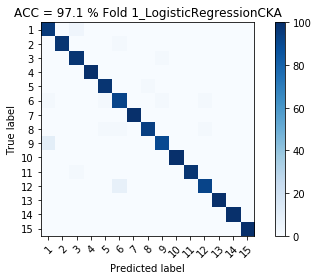

              precision    recall  f1-score   support

           1       0.89      0.96      0.92        50
           2       1.00      0.98      0.99        50
           3       0.94      0.98      0.96        50
           4       1.00      1.00      1.00        51
           5       0.96      0.98      0.97        50
           6       0.88      0.92      0.90        50
           7       1.00      1.00      1.00        51
           8       0.98      0.94      0.96        50
           9       0.96      0.90      0.93        50
          10       1.00      1.00      1.00        50
          11       1.00      0.98      0.99        51
          12       0.96      0.92      0.94        50
          13       1.00      1.00      1.00        51
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   

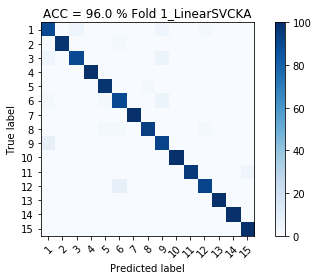

              precision    recall  f1-score   support

           1       0.87      0.90      0.88        50
           2       1.00      0.98      0.99        50
           3       0.96      0.90      0.93        50
           4       1.00      1.00      1.00        51
           5       0.96      0.98      0.97        50
           6       0.88      0.90      0.89        50
           7       1.00      1.00      1.00        51
           8       0.98      0.94      0.96        50
           9       0.85      0.92      0.88        50
          10       1.00      1.00      1.00        50
          11       1.00      0.96      0.98        51
          12       0.96      0.92      0.94        50
          13       1.00      1.00      1.00        51
          14       1.00      1.00      1.00        50
          15       0.96      1.00      0.98        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   


1it [01:47, 107.25s/it]

Iteration =  2/10
Linear Model
it:1/50---cost:-1.66e+00--- elapsed:94.86 [s]



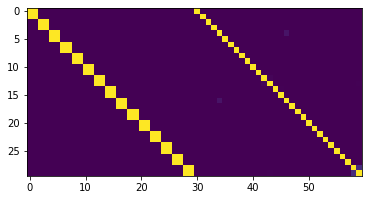

Logistic Regression Model
it:1/50---cost:-1.65e+00--- elapsed:37.54 [s]



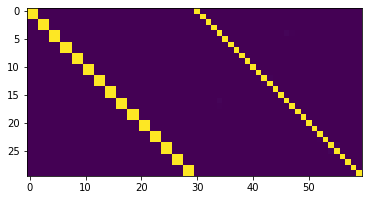

Linear SVM Model
it:1/50---cost:-1.66e+00--- elapsed:22.77 [s]



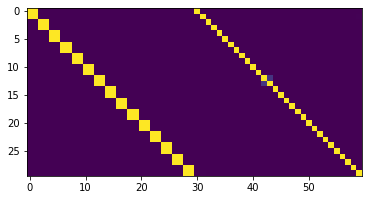

Guardando... LinearCKA_Fold2


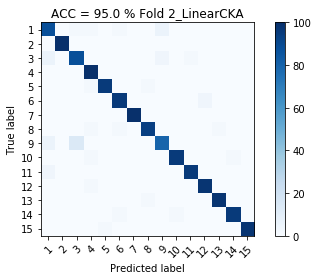

              precision    recall  f1-score   support

           1       0.85      0.88      0.86        50
           2       1.00      1.00      1.00        50
           3       0.85      0.88      0.86        50
           4       0.91      1.00      0.95        51
           5       0.98      0.96      0.97        50
           6       0.94      0.96      0.95        51
           7       1.00      1.00      1.00        50
           8       0.96      0.94      0.95        51
           9       0.89      0.80      0.84        50
          10       0.98      0.96      0.97        50
          11       0.98      0.96      0.97        50
          12       0.96      0.98      0.97        50
          13       0.98      0.98      0.98        50
          14       0.98      0.96      0.97        51
          15       1.00      0.98      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

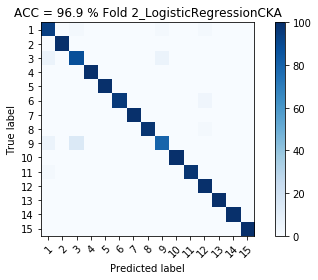

              precision    recall  f1-score   support

           1       0.87      0.94      0.90        50
           2       1.00      1.00      1.00        50
           3       0.85      0.88      0.86        50
           4       1.00      1.00      1.00        51
           5       1.00      1.00      1.00        50
           6       1.00      0.96      0.98        51
           7       1.00      1.00      1.00        50
           8       1.00      0.98      0.99        51
           9       0.91      0.80      0.85        50
          10       1.00      1.00      1.00        50
          11       1.00      0.98      0.99        50
          12       0.93      1.00      0.96        50
          13       1.00      1.00      1.00        50
          14       1.00      1.00      1.00        51
          15       1.00      1.00      1.00        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   

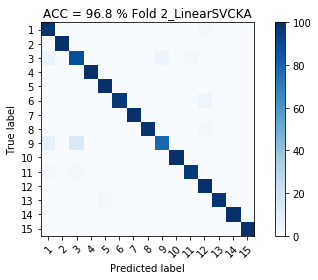

              precision    recall  f1-score   support

           1       0.86      0.98      0.92        50
           2       1.00      1.00      1.00        50
           3       0.85      0.88      0.86        50
           4       1.00      1.00      1.00        51
           5       0.98      1.00      0.99        50
           6       1.00      0.96      0.98        51
           7       1.00      1.00      1.00        50
           8       1.00      0.98      0.99        51
           9       0.95      0.78      0.86        50
          10       1.00      1.00      1.00        50
          11       0.98      0.96      0.97        50
          12       0.93      1.00      0.96        50
          13       1.00      0.98      0.99        50
          14       1.00      1.00      1.00        51
          15       1.00      1.00      1.00        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   


2it [08:24, 194.36s/it]

Iteration =  3/10
Linear Model
it:1/50---cost:-1.66e+00--- elapsed:20.54 [s]



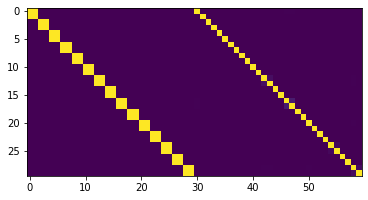

Logistic Regression Model
it:1/50---cost:-1.65e+00--- elapsed:33.99 [s]



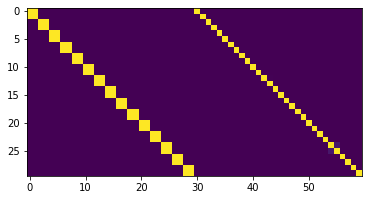

Linear SVM Model
it:1/50---cost:-1.66e+00--- elapsed:56.12 [s]



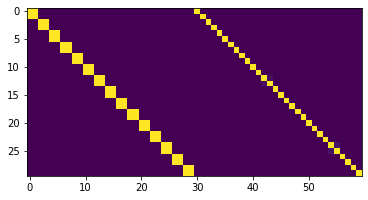

Guardando... LinearCKA_Fold3


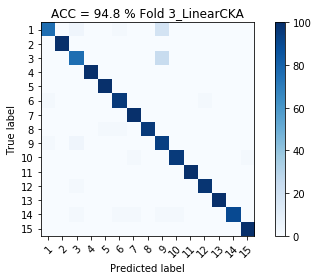

              precision    recall  f1-score   support

           1       0.95      0.76      0.84        50
           2       1.00      1.00      1.00        50
           3       0.86      0.76      0.81        50
           4       1.00      1.00      1.00        51
           5       0.98      1.00      0.99        51
           6       0.94      0.96      0.95        50
           7       0.96      1.00      0.98        51
           8       1.00      0.96      0.98        50
           9       0.68      0.94      0.79        50
          10       0.98      0.96      0.97        50
          11       1.00      1.00      1.00        50
          12       0.98      0.98      0.98        50
          13       1.00      1.00      1.00        51
          14       1.00      0.90      0.95        50
          15       0.98      1.00      0.99        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

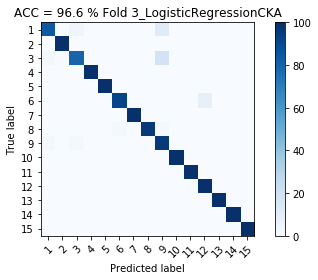

              precision    recall  f1-score   support

           1       0.95      0.84      0.89        50
           2       1.00      1.00      1.00        50
           3       0.93      0.80      0.86        50
           4       1.00      1.00      1.00        51
           5       1.00      1.00      1.00        51
           6       0.98      0.92      0.95        50
           7       1.00      1.00      1.00        51
           8       1.00      0.96      0.98        50
           9       0.75      0.96      0.84        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.93      1.00      0.96        50
          13       1.00      1.00      1.00        51
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   

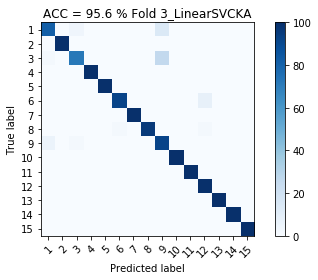

              precision    recall  f1-score   support

           1       0.91      0.82      0.86        50
           2       1.00      1.00      1.00        50
           3       0.92      0.72      0.81        50
           4       1.00      1.00      1.00        51
           5       1.00      1.00      1.00        51
           6       0.98      0.92      0.95        50
           7       1.00      1.00      1.00        51
           8       1.00      0.96      0.98        50
           9       0.70      0.92      0.79        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.91      1.00      0.95        50
          13       1.00      1.00      1.00        51
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   


3it [13:55, 235.19s/it]

Iteration =  4/10
Linear Model
it:1/50---cost:-1.68e+00--- elapsed:27.03 [s]



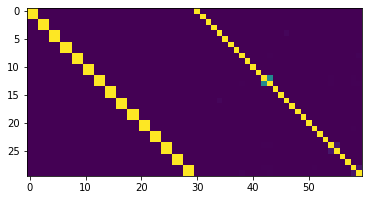

Logistic Regression Model
it:1/50---cost:-1.65e+00--- elapsed:31.40 [s]



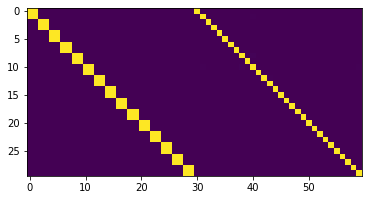

Linear SVM Model
it:1/50---cost:-1.65e+00--- elapsed:27.03 [s]



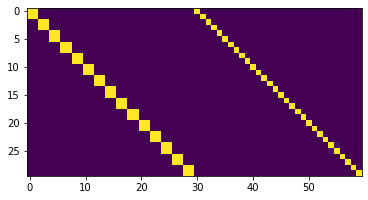

Guardando... LinearCKA_Fold4


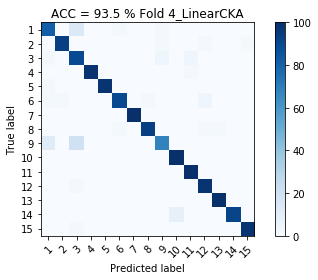

              precision    recall  f1-score   support

           1       0.82      0.82      0.82        50
           2       0.98      0.94      0.96        51
           3       0.71      0.90      0.79        51
           4       1.00      0.98      0.99        50
           5       1.00      0.98      0.99        50
           6       0.96      0.90      0.93        50
           7       1.00      1.00      1.00        51
           8       0.98      0.94      0.96        50
           9       0.89      0.68      0.77        50
          10       0.93      1.00      0.96        51
          11       0.94      1.00      0.97        50
          12       0.92      0.98      0.95        50
          13       0.98      1.00      0.99        50
          14       1.00      0.92      0.96        50
          15       0.98      0.98      0.98        50

    accuracy                           0.94       754
   macro avg       0.94      0.93      0.94       754
weighted avg       0.94   

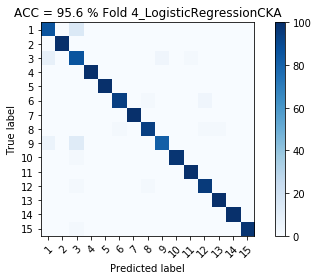

              precision    recall  f1-score   support

           1       0.86      0.86      0.86        50
           2       1.00      1.00      1.00        51
           3       0.73      0.86      0.79        51
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        50
           6       0.98      0.94      0.96        50
           7       1.00      1.00      1.00        51
           8       0.96      0.94      0.95        50
           9       0.95      0.82      0.88        50
          10       1.00      0.98      0.99        51
          11       0.98      1.00      0.99        50
          12       0.94      0.96      0.95        50
          13       0.98      1.00      0.99        50
          14       1.00      1.00      1.00        50
          15       1.00      0.98      0.99        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

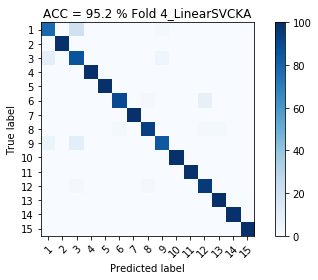

              precision    recall  f1-score   support

           1       0.83      0.78      0.80        50
           2       1.00      1.00      1.00        51
           3       0.73      0.86      0.79        51
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        50
           6       0.98      0.90      0.94        50
           7       1.00      1.00      1.00        51
           8       0.96      0.94      0.95        50
           9       0.93      0.84      0.88        50
          10       1.00      1.00      1.00        51
          11       1.00      1.00      1.00        50
          12       0.91      0.96      0.93        50
          13       0.98      1.00      0.99        50
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   


4it [18:33, 248.06s/it]

Iteration =  5/10
Linear Model
it:1/50---cost:-1.66e+00--- elapsed:16.79 [s]



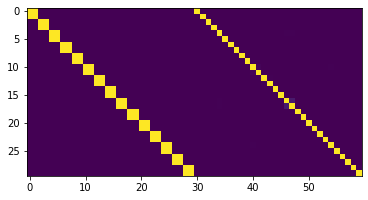

Logistic Regression Model
it:1/50---cost:-1.68e+00--- elapsed:10.38 [s]



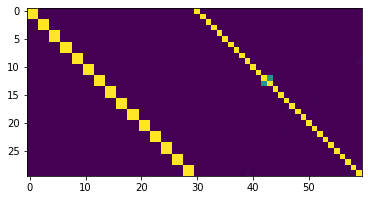

Linear SVM Model
it:1/50---cost:-1.66e+00--- elapsed:8.39 [s]



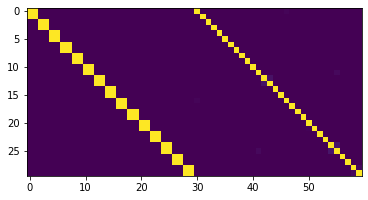

Guardando... LinearCKA_Fold5


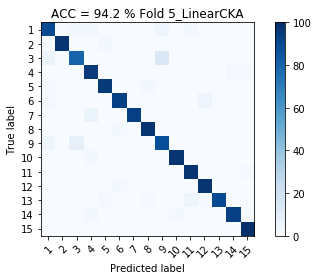

              precision    recall  f1-score   support

           1       0.87      0.90      0.88        50
           2       1.00      0.98      0.99        51
           3       0.89      0.80      0.84        50
           4       0.89      0.96      0.92        50
           5       0.96      0.96      0.96        50
           6       0.96      0.94      0.95        50
           7       1.00      0.94      0.97        51
           8       0.96      0.98      0.97        50
           9       0.83      0.88      0.85        50
          10       0.98      0.98      0.98        50
          11       0.94      0.98      0.96        50
          12       0.94      0.98      0.96        51
          13       1.00      0.90      0.95        50
          14       0.98      0.94      0.96        51
          15       0.94      1.00      0.97        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

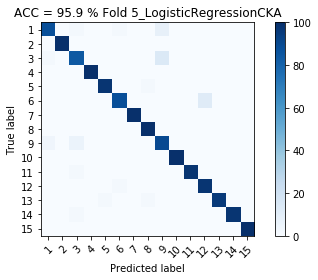

              precision    recall  f1-score   support

           1       0.94      0.88      0.91        50
           2       1.00      1.00      1.00        51
           3       0.88      0.84      0.86        50
           4       1.00      1.00      1.00        50
           5       0.98      0.98      0.98        50
           6       0.96      0.88      0.92        50
           7       1.00      1.00      1.00        51
           8       0.96      1.00      0.98        50
           9       0.80      0.90      0.85        50
          10       1.00      1.00      1.00        50
          11       1.00      0.98      0.99        50
          12       0.89      0.98      0.93        51
          13       1.00      0.96      0.98        50
          14       1.00      0.98      0.99        51
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

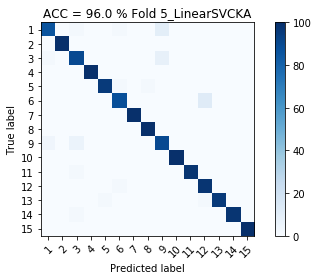

              precision    recall  f1-score   support

           1       0.93      0.86      0.90        50
           2       1.00      1.00      1.00        51
           3       0.88      0.90      0.89        50
           4       1.00      1.00      1.00        50
           5       0.98      0.96      0.97        50
           6       0.94      0.88      0.91        50
           7       1.00      1.00      1.00        51
           8       0.98      1.00      0.99        50
           9       0.83      0.90      0.87        50
          10       1.00      1.00      1.00        50
          11       1.00      0.98      0.99        50
          12       0.88      0.98      0.93        51
          13       1.00      0.96      0.98        50
          14       1.00      0.98      0.99        51
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   


5it [21:11, 220.97s/it]

Iteration =  6/10
Linear Model
it:1/50---cost:-1.66e+00--- elapsed:6.85 [s]



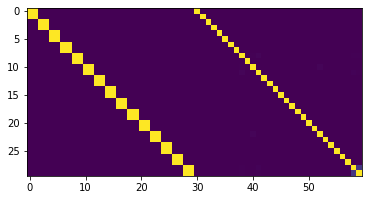

Logistic Regression Model
it:1/50---cost:-1.66e+00--- elapsed:8.23 [s]



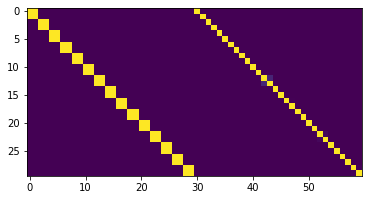

Linear SVM Model
it:1/50---cost:-1.66e+00--- elapsed:5.59 [s]



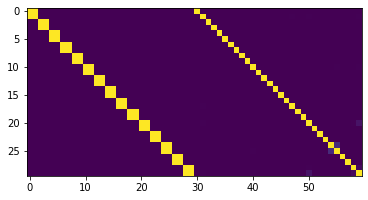

Guardando... LinearCKA_Fold6


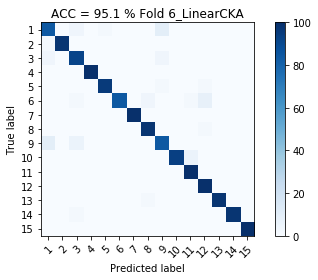

              precision    recall  f1-score   support

           1       0.84      0.84      0.84        51
           2       1.00      0.98      0.99        50
           3       0.87      0.92      0.90        51
           4       1.00      1.00      1.00        50
           5       0.98      0.96      0.97        50
           6       1.00      0.84      0.91        51
           7       1.00      1.00      1.00        50
           8       0.94      0.98      0.96        51
           9       0.84      0.84      0.84        50
          10       1.00      0.94      0.97        50
          11       0.93      1.00      0.96        50
          12       0.89      1.00      0.94        50
          13       1.00      0.98      0.99        50
          14       1.00      0.98      0.99        50
          15       1.00      1.00      1.00        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

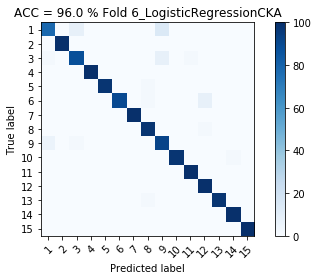

              precision    recall  f1-score   support

           1       0.91      0.78      0.84        51
           2       1.00      1.00      1.00        50
           3       0.90      0.88      0.89        51
           4       1.00      1.00      1.00        50
           5       1.00      0.98      0.99        50
           6       1.00      0.90      0.95        51
           7       1.00      1.00      1.00        50
           8       0.94      0.98      0.96        51
           9       0.81      0.92      0.86        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.91      1.00      0.95        50
          13       1.00      0.98      0.99        50
          14       0.98      1.00      0.99        50
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

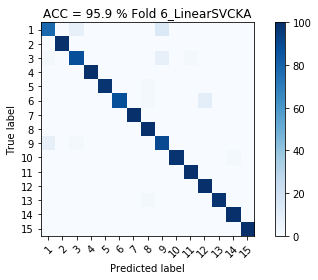

              precision    recall  f1-score   support

           1       0.89      0.78      0.83        51
           2       1.00      1.00      1.00        50
           3       0.90      0.88      0.89        51
           4       1.00      1.00      1.00        50
           5       1.00      0.98      0.99        50
           6       1.00      0.88      0.94        51
           7       1.00      1.00      1.00        50
           8       0.94      1.00      0.97        51
           9       0.80      0.90      0.85        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        50
          12       0.91      1.00      0.95        50
          13       1.00      0.98      0.99        50
          14       0.98      1.00      0.99        50
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   


6it [23:11, 190.88s/it]

Iteration =  7/10
Linear Model
it:1/50---cost:-1.66e+00--- elapsed:6.41 [s]



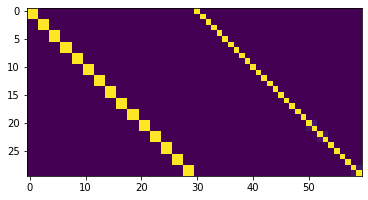

Logistic Regression Model
it:1/50---cost:-1.66e+00--- elapsed:5.79 [s]



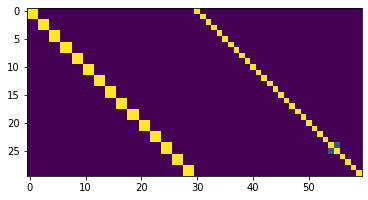

Linear SVM Model
it:1/50---cost:-1.67e+00--- elapsed:7.10 [s]



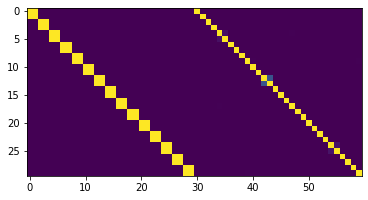

Guardando... LinearCKA_Fold7


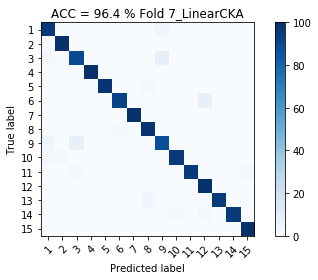

              precision    recall  f1-score   support

           1       0.92      0.96      0.94        51
           2       0.98      1.00      0.99        51
           3       0.90      0.90      0.90        50
           4       1.00      1.00      1.00        51
           5       1.00      0.98      0.99        50
           6       0.98      0.92      0.95        50
           7       1.00      1.00      1.00        51
           8       0.94      0.98      0.96        50
           9       0.88      0.88      0.88        50
          10       0.98      0.96      0.97        50
          11       1.00      0.96      0.98        50
          12       0.91      1.00      0.95        50
          13       1.00      0.96      0.98        50
          14       1.00      0.96      0.98        50
          15       0.98      1.00      0.99        50

    accuracy                           0.96       754
   macro avg       0.97      0.96      0.96       754
weighted avg       0.97   

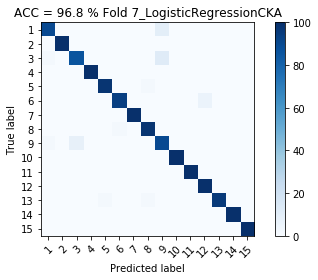

              precision    recall  f1-score   support

           1       0.96      0.90      0.93        51
           2       1.00      1.00      1.00        51
           3       0.91      0.86      0.89        50
           4       1.00      1.00      1.00        51
           5       0.98      0.98      0.98        50
           6       0.98      0.94      0.96        50
           7       1.00      1.00      1.00        51
           8       0.96      0.98      0.97        50
           9       0.80      0.90      0.85        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.94      1.00      0.97        50
          13       1.00      0.96      0.98        50
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   

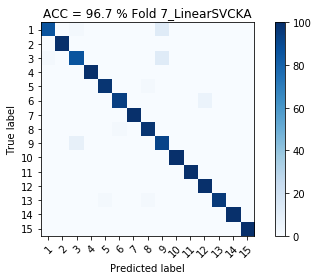

              precision    recall  f1-score   support

           1       0.98      0.86      0.92        51
           2       1.00      1.00      1.00        51
           3       0.90      0.86      0.88        50
           4       1.00      1.00      1.00        51
           5       0.98      0.98      0.98        50
           6       0.98      0.94      0.96        50
           7       1.00      1.00      1.00        51
           8       0.96      0.98      0.97        50
           9       0.79      0.92      0.85        50
          10       1.00      1.00      1.00        50
          11       1.00      1.00      1.00        50
          12       0.94      1.00      0.97        50
          13       1.00      0.96      0.98        50
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   


7it [25:09, 168.87s/it]

Iteration =  8/10
Linear Model
it:1/50---cost:-1.66e+00--- elapsed:8.39 [s]



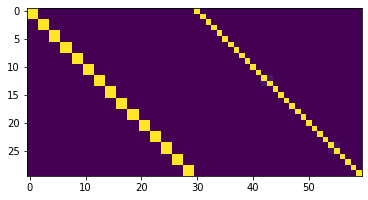

Logistic Regression Model
it:1/50---cost:-1.67e+00--- elapsed:7.04 [s]



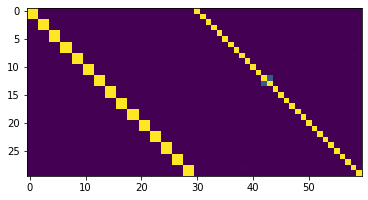

Linear SVM Model
it:1/50---cost:-1.65e+00--- elapsed:6.96 [s]



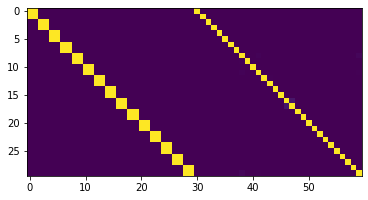

Guardando... LinearCKA_Fold8


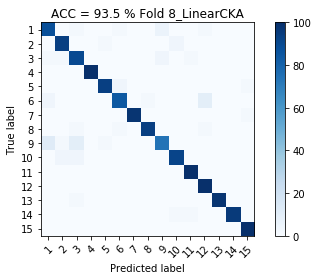

              precision    recall  f1-score   support

           1       0.83      0.88      0.85        50
           2       0.92      0.94      0.93        50
           3       0.82      0.90      0.86        50
           4       1.00      1.00      1.00        50
           5       0.96      0.94      0.95        50
           6       0.91      0.84      0.88        51
           7       1.00      0.98      0.99        50
           8       0.98      0.94      0.96        51
           9       0.88      0.74      0.80        50
          10       0.94      0.92      0.93        51
          11       0.96      1.00      0.98        50
          12       0.88      1.00      0.93        50
          13       1.00      0.98      0.99        51
          14       1.00      0.96      0.98        50
          15       0.96      1.00      0.98        50

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.93       754
weighted avg       0.94   

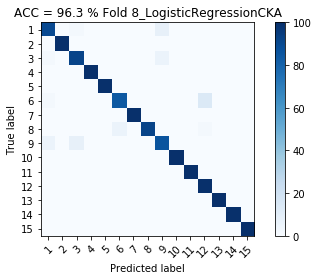

              precision    recall  f1-score   support

           1       0.90      0.90      0.90        50
           2       1.00      1.00      1.00        50
           3       0.90      0.92      0.91        50
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        50
           6       0.93      0.84      0.89        51
           7       1.00      1.00      1.00        50
           8       1.00      0.92      0.96        51
           9       0.86      0.86      0.86        50
          10       1.00      1.00      1.00        51
          11       1.00      1.00      1.00        50
          12       0.86      1.00      0.93        50
          13       1.00      1.00      1.00        51
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   

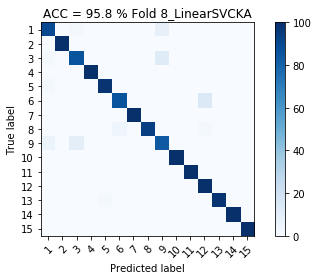

              precision    recall  f1-score   support

           1       0.90      0.90      0.90        50
           2       1.00      1.00      1.00        50
           3       0.88      0.86      0.87        50
           4       1.00      1.00      1.00        50
           5       0.98      0.98      0.98        50
           6       0.96      0.86      0.91        51
           7       1.00      1.00      1.00        50
           8       1.00      0.94      0.97        51
           9       0.81      0.84      0.82        50
          10       1.00      1.00      1.00        51
          11       1.00      1.00      1.00        50
          12       0.86      1.00      0.93        50
          13       1.00      0.98      0.99        51
          14       1.00      1.00      1.00        50
          15       1.00      1.00      1.00        50

    accuracy                           0.96       754
   macro avg       0.96      0.96      0.96       754
weighted avg       0.96   


8it [27:14, 155.72s/it]

Iteration =  9/10
Linear Model
it:1/50---cost:-1.65e+00--- elapsed:5.83 [s]



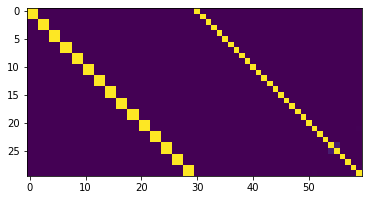

Logistic Regression Model
it:1/50---cost:-1.66e+00--- elapsed:5.41 [s]



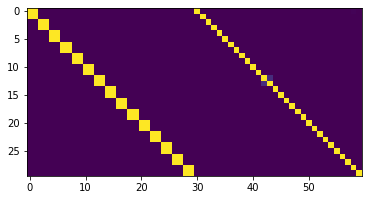

Linear SVM Model
it:1/50---cost:-1.65e+00--- elapsed:33.03 [s]



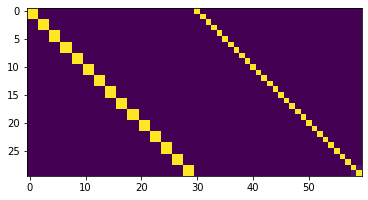

Guardando... LinearCKA_Fold9


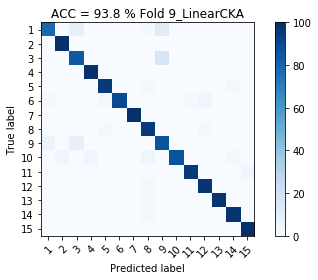

              precision    recall  f1-score   support

           1       0.91      0.78      0.84        50
           2       0.96      1.00      0.98        51
           3       0.84      0.84      0.84        50
           4       0.96      1.00      0.98        50
           5       0.96      0.96      0.96        50
           6       1.00      0.90      0.95        50
           7       1.00      1.00      1.00        50
           8       0.87      0.96      0.91        50
           9       0.76      0.86      0.81        51
          10       1.00      0.86      0.92        50
          11       0.98      0.96      0.97        50
          12       0.94      0.98      0.96        51
          13       1.00      0.98      0.99        50
          14       0.96      0.98      0.97        50
          15       0.96      1.00      0.98        51

    accuracy                           0.94       754
   macro avg       0.94      0.94      0.94       754
weighted avg       0.94   

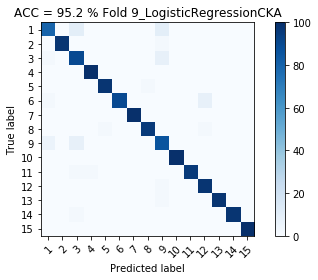

              precision    recall  f1-score   support

           1       0.89      0.80      0.84        50
           2       1.00      0.98      0.99        51
           3       0.80      0.90      0.85        50
           4       0.98      1.00      0.99        50
           5       0.98      0.98      0.98        50
           6       1.00      0.90      0.95        50
           7       1.00      1.00      1.00        50
           8       0.98      0.96      0.97        50
           9       0.79      0.86      0.82        51
          10       1.00      1.00      1.00        50
          11       1.00      0.96      0.98        50
          12       0.91      0.98      0.94        51
          13       1.00      0.98      0.99        50
          14       1.00      0.98      0.99        50
          15       1.00      1.00      1.00        51

    accuracy                           0.95       754
   macro avg       0.96      0.95      0.95       754
weighted avg       0.95   

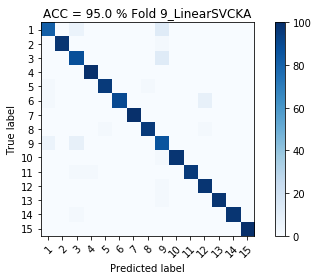

              precision    recall  f1-score   support

           1       0.89      0.82      0.85        50
           2       1.00      0.98      0.99        51
           3       0.83      0.88      0.85        50
           4       0.98      1.00      0.99        50
           5       0.98      0.96      0.97        50
           6       1.00      0.90      0.95        50
           7       1.00      1.00      1.00        50
           8       0.98      0.96      0.97        50
           9       0.73      0.86      0.79        51
          10       1.00      0.98      0.99        50
          11       1.00      0.96      0.98        50
          12       0.91      0.98      0.94        51
          13       1.00      0.98      0.99        50
          14       1.00      0.98      0.99        50
          15       1.00      1.00      1.00        51

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   


9it [30:17, 163.98s/it]

Iteration =  10/10
Linear Model
it:1/50---cost:-1.67e+00--- elapsed:19.59 [s]



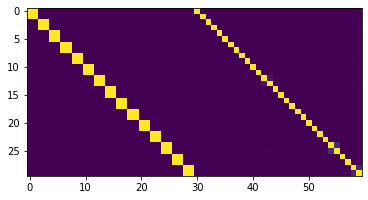

Logistic Regression Model
it:1/50---cost:-1.66e+00--- elapsed:18.49 [s]



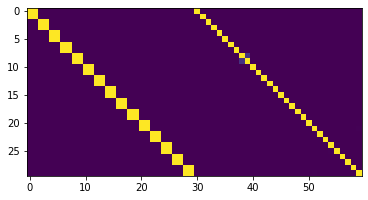

Linear SVM Model
it:1/50---cost:-1.68e+00--- elapsed:16.64 [s]



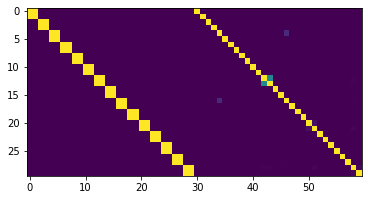

Guardando... LinearCKA_Fold10


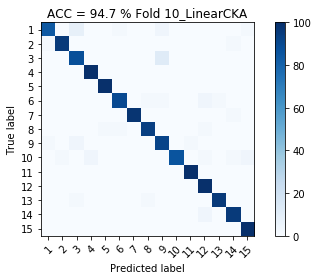

              precision    recall  f1-score   support

           1       0.96      0.84      0.90        51
           2       0.98      0.96      0.97        51
           3       0.86      0.88      0.87        50
           4       0.96      1.00      0.98        50
           5       0.98      1.00      0.99        50
           6       0.96      0.90      0.93        50
           7       1.00      0.98      0.99        50
           8       0.96      0.94      0.95        50
           9       0.84      0.92      0.88        50
          10       1.00      0.86      0.92        50
          11       0.98      1.00      0.99        51
          12       0.89      1.00      0.94        51
          13       0.98      0.96      0.97        50
          14       0.94      0.96      0.95        50
          15       0.94      1.00      0.97        50

    accuracy                           0.95       754
   macro avg       0.95      0.95      0.95       754
weighted avg       0.95   

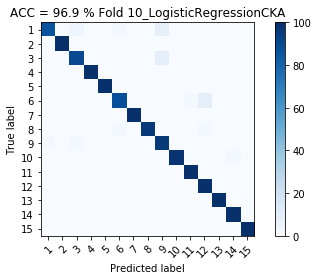

              precision    recall  f1-score   support

           1       0.98      0.86      0.92        51
           2       1.00      1.00      1.00        51
           3       0.94      0.90      0.92        50
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        50
           6       0.96      0.88      0.92        50
           7       1.00      1.00      1.00        50
           8       1.00      0.96      0.98        50
           9       0.84      0.96      0.90        50
          10       1.00      0.98      0.99        50
          11       0.98      1.00      0.99        51
          12       0.89      1.00      0.94        51
          13       1.00      1.00      1.00        50
          14       0.98      1.00      0.99        50
          15       1.00      1.00      1.00        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   

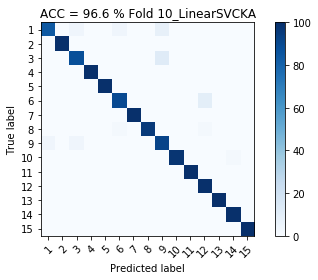

              precision    recall  f1-score   support

           1       0.96      0.84      0.90        51
           2       1.00      1.00      1.00        51
           3       0.92      0.88      0.90        50
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        50
           6       0.94      0.90      0.92        50
           7       1.00      1.00      1.00        50
           8       1.00      0.96      0.98        50
           9       0.82      0.92      0.87        50
          10       1.00      0.98      0.99        50
          11       1.00      1.00      1.00        51
          12       0.89      1.00      0.94        51
          13       1.00      1.00      1.00        50
          14       0.98      1.00      0.99        50
          15       1.00      1.00      1.00        50

    accuracy                           0.97       754
   macro avg       0.97      0.97      0.97       754
weighted avg       0.97   


10it [34:50, 209.10s/it]


In [ ]:
# Traininig/Testing loop
fold = 0

for train_index, test_index in tqdm(sss.split(X,y)):
    # Training/testing index storage
    train_idx += [train_index]
    test_idx  += [test_index]
    
    # Number of partitions flag
    fold = fold + 1
    print("Iteration = ", str(fold) +'/'+ str(n_partitions))
    
    # Iteration file name 
    filename = img_path + "/Fold" + str(fold)

    # Train/Test partition and matrix storing to apply CKA over them for 
    # visualization
    X_train, X_test = X[train_index,:], X[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    X_train_cka += [X_train]
    X_test_cka  += [X_test]
    y_train_cka += [y_train]
    y_test_cka  += [y_test]

    # ---------------------------------------------------------------------------------------------------------------------------
    # Training
    
    # Linear
    print('Linear Model')
    # Using GridSearchCV 
    # hs_Lineal = GridSearchCV(Pipeline(steps[0]), parameters[0], n_jobs = 6, cv = 5, scoring = 'balanced_accuracy', verbose = 50)
    # Using RandomizedSearchCV
    hs_Lineal = RandomizedSearchCV(Pipeline(steps[0]), param_distributions=parameters[0],n_iter=10, cv=5, iid=False, n_jobs=15)
    hs_Lineal.fit(X_train,y_train)
    # Projection matrix from CKA
    W_cka_L += [hs_Lineal.best_estimator_.named_steps['Projection'].Wcka]


    # Logistic Regression
    print('Logistic Regression Model')
    # Usaing GridSearchCV 
    # hs_LogR = GridSearchCV(Pipeline(steps[1]), parameters[1], n_jobs = 6, cv = 5, scoring = 'balanced_accuracy', verbose = 50)
    # Using RandomizedSearchCV
    hs_LogR = RandomizedSearchCV(Pipeline(steps[1]), param_distributions=parameters[1],n_iter=10, cv=5, iid=False,n_jobs=15)
    hs_LogR.fit(X_train,y_train)
    # Projection matrix from CKA
    W_cka_LogR += [hs_LogR.best_estimator_.named_steps['Projection'].Wcka]
  

    # Linear SVM
    print('Linear SVM Model')
    # Using GridSearchCV 
    #hs_lSVM = GridSearchCV(Pipeline(steps[2]), parameters[2], n_jobs = 6, cv = 5, scoring = 'balanced_accuracy', verbose = 50)
    # Using RandomizedSearchCV
    hs_lSVM = RandomizedSearchCV(Pipeline(steps[2]), param_distributions=parameters[2],n_iter=10, cv=5, iid=False, n_jobs=15)  
    hs_lSVM.fit(X_train,y_train)
    # Projection matrix from CKA
    W_cka_lSVM += [hs_lSVM.best_estimator_.named_steps['Projection'].Wcka]

    # ---------------------------------------------------------------------------------------------------------------------------
    # Validation
    
    # Linear
    y_pred_L           = hs_Lineal.best_estimator_.predict(X_test)
    accuracy_L[fold-1] = accuracy_score(y_test,y_pred_L)
    cm_temp            = confusion_matrix(y_test,y_pred_L)
    cm_L[fold-1,:,:]   = 100*cm_temp.astype('float') / cm_temp.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(y_test, y_pred_L, classes=np.unique(y),normalize=True,title='ACC = %.1f %% Fold %d' % (100*accuracy_L[fold-1],fold) + '_'+ label_models[0])
    plt.autoscale()
    save_fig(img_path,label_models[0]+'_Fold'+str(fold))                      
    plt.show()
    cr_L += [classification_report(y_test,y_pred_L)]
    print(cr_L[-1])
    # Best model storage
    # best_mod_L += [hs_Lineal.best_estimator_, accuracy_L,cm_L,cr_L, sel_fts_L]
    # best_mod_L += [hs_Lineal.best_estimator_]
    best_pms_L += [hs_Lineal.best_params_,accuracy_L,cm_L,cr_L,W_cka_L]
    joblib.dump(best_pms_L, filename + "LinealCKA" + ".pkl")


    # Logistic Regression
    y_pred_LogR          = hs_LogR.best_estimator_.predict(X_test)
    accuracy_LogR[fold-1]= accuracy_score(y_test,y_pred_LogR)
    cm_temp              = confusion_matrix(y_test,y_pred_LogR)
    cm_LogR[fold-1,:,:]  = 100*cm_temp.astype('float') / cm_temp.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(y_test, y_pred_LogR, classes=np.unique(y),normalize=True,title='ACC = %.1f %% Fold %d' % (100*accuracy_LogR[fold-1],fold) + '_'+ label_models[1])
    plt.autoscale()
    save_fig(img_path,label_models[1]+'_Fold'+str(fold))                      
    plt.show()
    cr_LogR += [classification_report(y_test,y_pred_LogR)]
    print(cr_LogR[-1])
    # Best model storage
    # best_mod_LogR += [hs_LogR.best_estimator_, accuracy_LogR,cm_LogR,cr_LogR, sel_fts_LogR]
    # best_mod_LogR += [hs_LogR.best_estimator_]
    best_pms_LogR += [hs_LogR.best_params_,accuracy_LogR,cm_LogR,cr_LogR,W_cka_LogR]
    joblib.dump(best_pms_LogR, filename + "LogRCKA" + ".pkl")


    # Linear SVM
    y_pred_lSVM          = hs_lSVM.best_estimator_.predict(X_test)
    accuracy_lSVM[fold-1]= accuracy_score(y_test,y_pred_lSVM)
    cm_temp              = confusion_matrix(y_test,y_pred_lSVM)
    cm_LogR[fold-1,:,:]  = 100*cm_temp.astype('float') / cm_temp.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(y_test, y_pred_lSVM, classes=np.unique(y),normalize=True,title='ACC = %.1f %% Fold %d' % (100*accuracy_lSVM[fold-1],fold) + '_'+ label_models[2])
    plt.autoscale()
    save_fig(img_path,label_models[2]+'_Fold'+str(fold))                      
    plt.show()
    cr_lSVM += [classification_report(y_test,y_pred_lSVM)]
    print(cr_lSVM[-1])
    # Best model storage
    # best_mod_lSVM += [hs_lSVM.best_estimator_, accuracy_lSVM,cm_lSVM,cr_lSVM, sel_fts_lSVM]
    # best_mod_lSVM += [hs_lSVM.best_estimator_]
    best_pms_lSVM += [hs_lSVM.best_params_,accuracy_lSVM,cm_lSVM,cr_lSVM,W_cka_lSVM]
    joblib.dump(best_pms_lSVM, filename + "lSVMCKA" + ".pkl")
    
    # Results dictionary creation
    L_dict = {'accuracy_L': accuracy_L,
              'cm_L': cm_L,
              'cr_L': cr_L,
              'W_cka_L': W_cka_L,
              'X_train_cka': X_train_cka,
              'X_test_cka': X_test_cka,
              'y_train_cka':y_train_cka,
              'y_test_cka':y_test_cka}

    LogR_dict = {'accuracy_LogR': accuracy_LogR,
                'cm_LogR': cm_LogR,
                'cr_LogR': cr_LogR,
                'W_cka_LogR': W_cka_LogR,
                'X_train_cka': X_train_cka,
                'X_test_cka': X_test_cka,
                'y_train_cka':y_train_cka,
                'y_test_cka':y_test_cka}

    lSVM_dict = {'accuracy_lSVM': accuracy_lSVM,
                'cm_lSVM': cm_lSVM,
                'cr_lSVM': cr_lSVM,
                'W_cka_lSVM': W_cka_lSVM,
                'X_train_cka': X_train_cka,
                'X_test_cka': X_test_cka,
                'y_train_cka':y_train_cka,
                'y_test_cka':y_test_cka}

    Results = [L_dict, LogR_dict, lSVM_dict]

    joblib.dump(Results, rslt_dir + ".pkl")

Average result printing

In [ ]:
print('Linear Classifier')
print(str(np.mean(np.array(Results[0]['accuracy_L']))*100) + '+/-' + str(np.std(np.array(Results[0]['accuracy_L']))*100))

print('Logistic Regression Classifier')
print(str(np.mean(np.array(Results[1]['accuracy_LogR']))*100) + '+/-' + str(np.std(np.array(Results[1]['accuracy_LogR']))*100))

print('Linear SVM Classifier')
print(str(np.mean(np.array(Results[2]['accuracy_lSVM']))*100) + '+/-' + str(np.std(np.array(Results[2]['accuracy_lSVM']))*100))

Linear Classifier
94.41644562334217+/-0.9254405848498394
Logistic Regression Classifier
96.3395225464191+/-0.6025366945146167
Linear SVM Classifier
95.9549071618037+/-0.5758167996310984


Projection matrix plotting

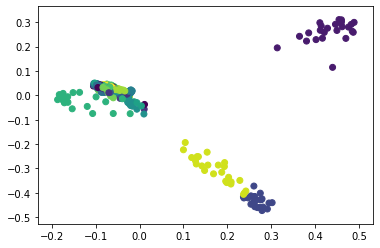

In [ ]:
W    = Results[1]['W_cka_LogR'][0]
Xp   = X_train_cka[0].dot(W)
# Plotting the projection matrix
plt.scatter(Xp[:,1],Xp[:,2],c = y_train_cka[0])